# Prepare Environment

## 1. Mount Drive
Mount Google Drive (only needed in Colab).



In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


## 2. Install packages
Install all required audio, transcription, and utility packages.



In [ ]:
# Install core packages
!pip -q install --upgrade pip

# System dependency (needed by Whisper / stempeg)
!apt-get -y install -qq ffmpeg

# Audio + ASR toolchain
!pip -q install openai-whisper jiwer librosa soundfile tqdm ffmpeg-python pydub stempeg python-Levenshtein

# NOTE:
# - We rely on Colab's built-in PyTorch. If you hit torch/torchaudio issues, use the optional line below.
# !pip -q install torch torchaudio --index-url https://download.pytorch.org/whl/cu121


## 3. Import packages
Load all Python libraries used later.




In [ ]:
# General utilities
import os, glob
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

# Audio processing
import librosa, librosa.display
import soundfile as sf
import ffmpeg
from pydub import AudioSegment

# Deep learning / models
import torch
import whisper


## 4. Set paths
Define project root and subfolders (change `ROOT` to your clone path).

In [ ]:
# Cell — Config paths (simple + GitHub-friendly)
import os, sys, json, shutil
from pathlib import Path

# detect if running in Colab
IN_COLAB = "google.colab" in sys.modules

# CONFIG: project root folder
# Change this path to the folder where you cloned/downloaded the repo
ROOT = Path("/content/drive/MyDrive/GitHub/musdb18-asr-dl")

# canonical subfolders
DATA_RAW        = ROOT / "data" / "raw"
DATA_PROCESSED  = ROOT / "data" / "processed"
OUT_DIR         = ROOT / "outputs"
CHECKPOINTS_DIR = ROOT / "checkpoints"
LOGS_DIR        = ROOT / "logs"
STEMS_DIR       = ROOT / "stems"

# Hugging Face cache (persistent if on Colab + Drive)
HF_CACHE = Path(
    os.environ.get(
        "HF_CACHE",
        "/content/drive/MyDrive/hf_cache" if IN_COLAB else (Path.home() / ".cache" / "huggingface")
    )
)
os.environ["HF_HOME"] = str(HF_CACHE)
os.environ["HF_DATASETS_CACHE"] = str(HF_CACHE)
os.environ["TRANSFORMERS_CACHE"] = str(HF_CACHE)

# ensure dirs exist
for d in [DATA_RAW, DATA_PROCESSED, OUT_DIR, CHECKPOINTS_DIR, LOGS_DIR, STEMS_DIR, HF_CACHE]:
    d.mkdir(parents=True, exist_ok=True)

# quick printout
print("ROOT         :", ROOT)
print("DATA_RAW     :", DATA_RAW)
print("DATA_PROCESSED:", DATA_PROCESSED)
print("OUT_DIR      :", OUT_DIR)
print("CHECKPOINTS  :", CHECKPOINTS_DIR)
print("LOGS_DIR     :", LOGS_DIR)
print("STEMS_DIR    :", STEMS_DIR)
print("HF_CACHE     :", HF_CACHE)


ROOT         : /content/drive/MyDrive/GitHub/musdb18-asr-dl
NOTEBOOKS_DIR: /content/drive/MyDrive/GitHub/musdb18-asr-dl/notebooks
DATA_RAW     : /content/drive/MyDrive/GitHub/musdb18-asr-dl/data/raw
DATA_PROCESSED: /content/drive/MyDrive/GitHub/musdb18-asr-dl/data/processed
OUT_DIR      : /content/drive/MyDrive/GitHub/musdb18-asr-dl/outputs
CHECKPOINTS  : /content/drive/MyDrive/GitHub/musdb18-asr-dl/checkpoints
LOGS_DIR     : /content/drive/MyDrive/GitHub/musdb18-asr-dl/logs
STEMS_DIR    : /content/drive/MyDrive/GitHub/musdb18-asr-dl/stems
HF_CACHE     : /content/drive/MyDrive/hf_cache


# Tracklist Preparation (Lyrics-Annotated Subset)


## Convert MUSDB18 track list from README to CSV
Parse the track metadata from the MUSDB18 README file into a structured CSV. This will help tag tracks by language and choose which songs to include in the dataset.


In [ ]:
import re
import pandas as pd

# Load the README file
readme_path = DATA_RAW / "README.md"
with open(readme_path, "r", encoding="utf-8") as f:
    content = f.read()

# Extract track metadata
track_list = re.findall(r"- ([^-]+?) - ([^,]+),([^,]+),([^,\n]+)", content)

# Create DataFrame
df_tracks = pd.DataFrame(track_list, columns=["Artist", "Track", "Genre", "Source_License"])

# Add empty columns for annotation
df_tracks["Language"] = ""
df_tracks["Include"] = ""

# Save to CSV
csv_path = DATA_PROCESSED / "musdb18_tracklist.csv"
df_tracks.to_csv(csv_path, index=False)

# Display preview
df_tracks.head()


,Artist,Track,Genre,Source_License,Language,Include
0,`3`,The rest of the accompaniment,\n- `4` - The vocals.\n\nFor each file,the mixture correspond to the sum of all the ...,,
1,A Classic Education,NightOwl,Singer/Songwriter,MedleyDB,,
2,Actions,Devil's Words,Pop/Rock,DSD,,
3,Actions,One Minute Smile,Pop/Rock,DSD,,
4,Actions,South Of The Water,Pop/Rock,DSD,,


## Download and extract the lyrics extension dataset from Zenodo
This archive contains time-aligned lyrics for many MUSDB18 English tracks. It will be used for training and evaluation.


In [ ]:
# Path to the lyrics extension
lyrics_dir = DATA_RAW / "lyrics_extension"

assert lyrics_dir.exists(), f"Lyrics extension not found at {lyrics_dir}"
print("Lyrics extension folder:", lyrics_dir)


Lyrics extension folder: /content/drive/MyDrive/GitHub/musdb18-asr-dl/data/raw/lyrics_extension


## Add lyrics availability flag to the track list
Check whether each track has a corresponding lyrics file in the extension dataset and add a new column `Has_Lyrics` to indicate that.


In [ ]:
import pandas as pd
from pathlib import Path

# Load the CSV created earlier (from processed folder)
tracklist_path = DATA_PROCESSED / "musdb18_tracklist.csv"
df = pd.read_csv(tracklist_path)

# Paths to the lyrics annotation folders (already downloaded in DATA_RAW)
lyrics_base = DATA_RAW / "lyrics_extension"
train_lyrics_path = lyrics_base / "train_lyrics"
test_lyrics_path  = lyrics_base / "test_lyrics"

# Extract base names of all available lyric files (without extension)
train_tracks = {f.stem for f in train_lyrics_path.glob("*.txt")}
test_tracks  = {f.stem for f in test_lyrics_path.glob("*.txt")}
all_lyric_tracks = train_tracks.union(test_tracks)

# Join Artist and Track name to match filename format
df["FullName"] = df["Artist"].str.strip() + " - " + df["Track"].str.strip()

# Add a flag indicating if the joined name is in the lyric annotations
df["Has_Lyrics"] = df["FullName"].apply(
    lambda name: "yes" if name in all_lyric_tracks else "no"
)

# Save the updated file (to processed folder)
updated_csv_path = DATA_PROCESSED / "musdb18_tracklist_with_lyrics_flag.csv"
df.to_csv(updated_csv_path, index=False)

print("Updated tracklist saved to:", updated_csv_path)
df.head()


Updated tracklist saved to: /content/drive/MyDrive/GitHub/musdb18-asr-dl/data/processed/musdb18_tracklist_with_lyrics_flag.csv


,Artist,Track,Genre,Source_License,Language,Include,FullName,Has_Lyrics
0,`3`,The rest of the accompaniment,\n- `4` - The vocals.\n\nFor each file,the mixture correspond to the sum of all the ...,NaN,NaN,`3` - The rest of the accompaniment,no
1,A Classic Education,NightOwl,Singer/Songwriter,MedleyDB,NaN,NaN,A Classic Education - NightOwl,yes
2,Actions,Devil's Words,Pop/Rock,DSD,NaN,NaN,Actions - Devil's Words,yes
3,Actions,One Minute Smile,Pop/Rock,DSD,NaN,NaN,Actions - One Minute Smile,yes
4,Actions,South Of The Water,Pop/Rock,DSD,NaN,NaN,Actions - South Of The Water,yes


## Filter tracklist to include only usable English tracks with lyrics
Only keep songs that have aligned lyrics available (lyrics is available only in English)


In [ ]:
import pandas as pd
from pathlib import Path

# Load tracklist with lyrics flag (processed)
tracklist_path = DATA_PROCESSED / "musdb18_tracklist_with_lyrics_flag.csv"
df = pd.read_csv(tracklist_path)

# Add FullName column for matching
df["FullName"] = df["Artist"].str.strip() + " - " + df["Track"].str.strip()

# Get official MUSDB18 train/test track names (from .stem.mp4 filenames)
train_dir = DATA_RAW / "musdb18" / "train"
test_dir  = DATA_RAW / "musdb18" / "test"
original_train_tracks = {f.stem for f in train_dir.glob("*.stem.mp4")}
original_test_tracks  = {f.stem for f in test_dir.glob("*.stem.mp4")}

# Filter for matching lyric files
lyrics_base = DATA_RAW / "lyrics_extension"
train_with_lyrics = {f.stem for f in (lyrics_base / "train_lyrics").glob("*.txt")}
test_with_lyrics  = {f.stem for f in (lyrics_base / "test_lyrics").glob("*.txt")}

# Cleaned train and test DataFrames
df_train_clean = df[
    (df["Has_Lyrics"] == "yes") & (df["FullName"].isin(train_with_lyrics))
].copy()

df_test_clean = df[
    (df["Has_Lyrics"] == "yes") & (df["FullName"].isin(test_with_lyrics))
].copy()

# Save outputs (to processed folder)
train_clean_csv = DATA_PROCESSED / "musdb18_train_tracklist_cleaned.csv"
test_clean_csv  = DATA_PROCESSED / "musdb18_test_tracklist_cleaned.csv"
df_train_clean.to_csv(train_clean_csv, index=False)
df_test_clean.to_csv(test_clean_csv, index=False)

# Print summary
print(f"Train tracks with lyrics: {len(df_train_clean)} out of {len(original_train_tracks)} original train tracks")
print(f"Test tracks with lyrics:  {len(df_test_clean)} out of {len(original_test_tracks)} original test tracks")
print("Saved train list to:", train_clean_csv)
print("Saved test list to :", test_clean_csv)


Train tracks with lyrics: 95 out of 0 original train tracks
Test tracks with lyrics:  44 out of 0 original test tracks
Saved train list to: /content/drive/MyDrive/GitHub/musdb18-asr-dl/data/processed/musdb18_train_tracklist_cleaned.csv
Saved test list to : /content/drive/MyDrive/GitHub/musdb18-asr-dl/data/processed/musdb18_test_tracklist_cleaned.csv


## Exploratory Data Analysis (EDA) on filtered MUSDB18 dataset
Visualize the structure of the dataset: genre distribution and train/test composition.


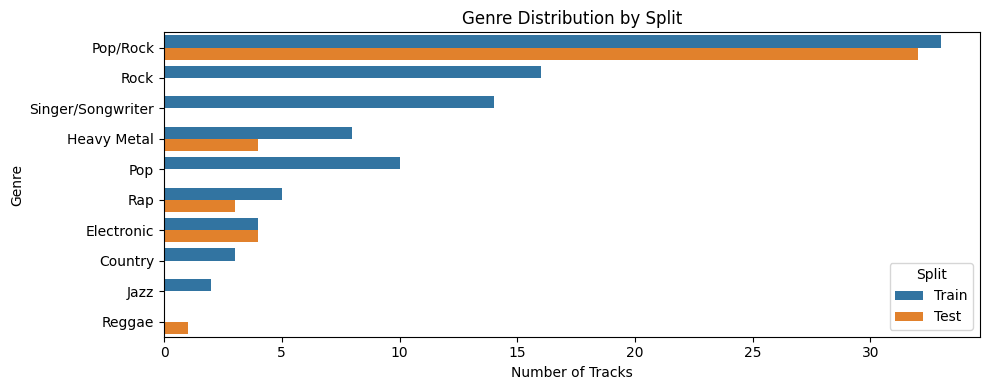

Saved plot to: /content/drive/MyDrive/GitHub/musdb18-asr-dl/outputs/genre_distribution_by_split.png


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned tracklists (from processed folder)
train_df = pd.read_csv(DATA_PROCESSED / "musdb18_train_tracklist_cleaned.csv")
test_df  = pd.read_csv(DATA_PROCESSED / "musdb18_test_tracklist_cleaned.csv")

# Add a split label
train_df["Split"] = "Train"
test_df["Split"]  = "Test"
full_df = pd.concat([train_df, test_df], ignore_index=True)

# Plot genre distribution
plt.figure(figsize=(10, 4))
sns.countplot(
    data=full_df,
    y="Genre",
    order=full_df["Genre"].value_counts().index,
    hue="Split"
)
plt.title("Genre Distribution by Split")
plt.xlabel("Number of Tracks")
plt.ylabel("Genre")
plt.tight_layout()

# Show and save figure
plot_path = OUT_DIR / "genre_distribution_by_split.png"
plt.savefig(plot_path)
plt.show()
print("Saved plot to:", plot_path)

Examine the lyrics

In [ ]:
# Print the first few lines of a lyrics file for inspection
sample_path = DATA_RAW / "lyrics_extension" / "train_lyrics" / "Aimee Norwich - Child.txt"

with open(sample_path, "r", encoding="utf-8") as f:
    for i, line in enumerate(f):
        print(f"{i+1}: {line.strip()}")
        if i > 10:
            break

1: 00:00 00:10 d -
2: 00:10 00:20 d -
3: 00:20 00:25 d -
4: 00:24 00:33 b when i was a child
5: 00:33 00:42 a the wind blew my name through the trees the sun painted portraits of me in the sky
6: 00:42 00:50 b when i was a child the animals they smiled at me the
7: 00:49 00:56 a me the dazes held my secrets and dreams in a line when
8: 00:55 00:59 b when i was a child
9: 00:59 01:08 a i'd say i love you for no good reason i embrace the scenes of the changing seasons alright
10: 01:08 01:16 b right when i was a child i saw the good in you and me
11: 01:16 01:22 a very simple how it's supposed to be ah
12: 01:22 01:29 b when i was a child the never was a perfect way


# Lyrics Segmentation

## Parse lyrics into structured DataFrames

parses the time-aligned .txt lyric files for both train and test sets.  
Extracts start/end times and actual lyric text into three DataFrames:
- `train_segments_df` – training lyrics
- `test_segments_df` – test lyrics
- `all_segments_df` – combined full dataset

Each row includes: `Song`, `Split`, `Start`, `End`, `Duration`, `Words`, and `Lyric`.



In [ ]:
import pandas as pd
from pathlib import Path

# === Directories for lyrics (from DATA_RAW) ===
train_lyrics_dir = DATA_RAW / "lyrics_extension" / "train_lyrics"
test_lyrics_dir  = DATA_RAW / "lyrics_extension" / "test_lyrics"

# === Convert mm:ss to float seconds ===
def timestamp_to_seconds(t):
    try:
        return int(t[:2]) * 60 + float(t[3:])
    except Exception:
        return None

# === Parse a lyrics folder into a list of lyric segments ===
def parse_lyrics_dir(folder, split_label):
    segments = []
    for file in folder.glob("*.txt"):
        song = file.stem
        with open(file, "r", encoding="utf-8") as f:
            for line in f:
                parts = line.strip().split(" ", 3)
                if len(parts) == 4:
                    start, end, _, text = parts
                    start_sec = timestamp_to_seconds(start)
                    end_sec = timestamp_to_seconds(end)
                    if start_sec is not None and end_sec is not None:
                        segments.append({
                            "Song": song,
                            "Split": split_label,
                            "Start": start_sec,
                            "End": end_sec,
                            "Duration": end_sec - start_sec,
                            "Words": len(text.strip().split()),
                            "Lyric": text.strip()
                        })
    return segments

# === Parse train and test sets separately ===
train_data = parse_lyrics_dir(train_lyrics_dir, "Train")
train_segments_df = pd.DataFrame(train_data)

test_data = parse_lyrics_dir(test_lyrics_dir, "Test")
test_segments_df = pd.DataFrame(test_data)

# === Combine into full dataset ===
all_segments_df = pd.concat([train_segments_df, test_segments_df], ignore_index=True)

# === Save to processed folder ===
train_segments_csv = DATA_PROCESSED / "train_segments.csv"
test_segments_csv  = DATA_PROCESSED / "test_segments.csv"
all_segments_csv   = DATA_PROCESSED / "all_segments.csv"

train_segments_df.to_csv(train_segments_csv, index=False)
test_segments_df.to_csv(test_segments_csv, index=False)
all_segments_df.to_csv(all_segments_csv, index=False)

print("Saved:", train_segments_csv)
print("Saved:", test_segments_csv)
print("Saved:", all_segments_csv)

Saved: /content/drive/MyDrive/GitHub/musdb18-asr-dl/data/processed/train_segments.csv
Saved: /content/drive/MyDrive/GitHub/musdb18-asr-dl/data/processed/test_segments.csv
Saved: /content/drive/MyDrive/GitHub/musdb18-asr-dl/data/processed/all_segments.csv


In [ ]:
train_segments_df.head()



,Song,Split,Start,End,Duration,Words,Lyric
0,Voelund - Comfort Lives In Belief,Train,0.0,10.0,10.0,1,-
1,Voelund - Comfort Lives In Belief,Train,10.0,18.0,8.0,1,-
2,Voelund - Comfort Lives In Belief,Train,18.0,25.0,7.0,1,oh
3,Voelund - Comfort Lives In Belief,Train,25.0,34.0,9.0,11,hey gather 'round for the story gather around ...
4,Voelund - Comfort Lives In Belief,Train,34.0,41.0,7.0,10,you may bring your comrades forget about heave...


## Segment EDA

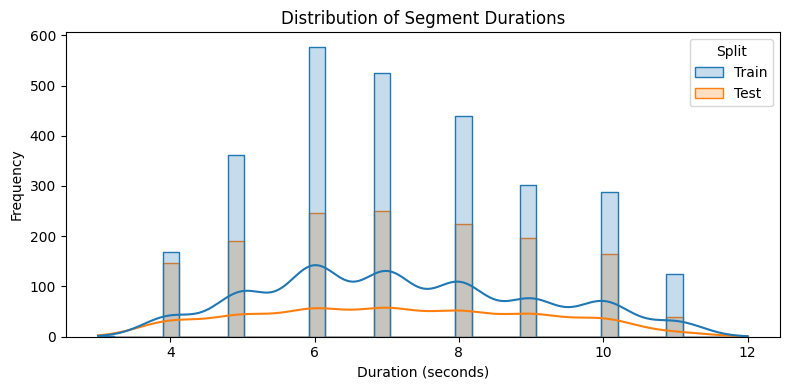

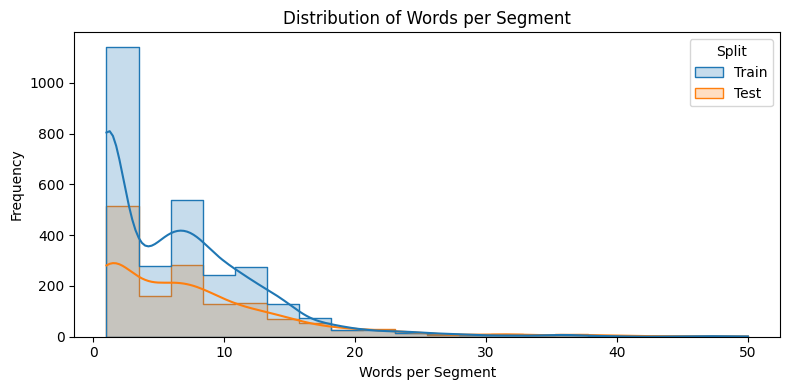

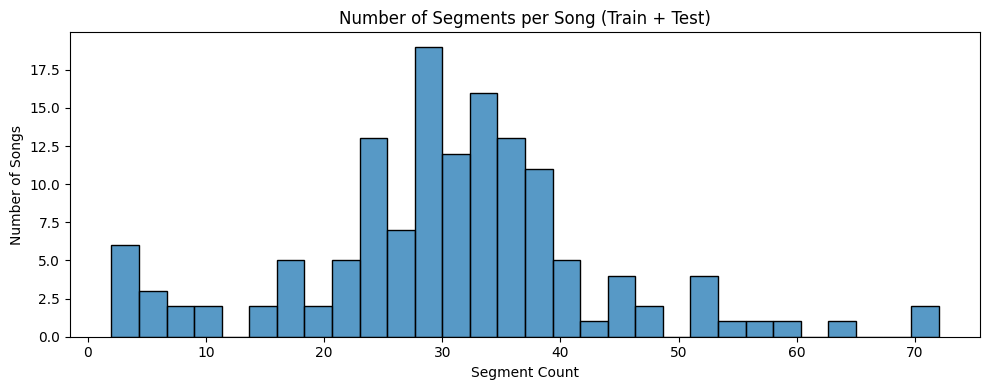

Saved plots to: /content/drive/MyDrive/GitHub/musdb18-asr-dl/outputs
Saved summary CSV: /content/drive/MyDrive/GitHub/musdb18-asr-dl/data/processed/segments_summary_stats.csv


,Measurement,Count,Mean,SD,SE,Q1,Q3
0,Segment Duration (s),4250,7.19,1.89,0.03,6.00,9.0
1,Words per Segment,4250,6.90,6.76,0.10,1.00,10.0
2,Segments per Song,140,30.36,12.83,1.08,24.75,36.0


In [ ]:
# === Segment EDA ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Duration distribution
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(data=all_segments_df, x="Duration", bins=40, kde=True, hue="Split", element="step", ax=ax)
ax.set_title("Distribution of Segment Durations")
ax.set_xlabel("Duration (seconds)")
ax.set_ylabel("Frequency")
fig.tight_layout()
fig.savefig(OUT_DIR / "seg_duration_hist.png")
plt.show()
plt.close(fig)

# 2) Words per segment
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(data=all_segments_df, x="Words", bins=20, kde=True, hue="Split", element="step", ax=ax)
ax.set_title("Distribution of Words per Segment")
ax.set_xlabel("Words per Segment")
ax.set_ylabel("Frequency")
fig.tight_layout()
fig.savefig(OUT_DIR / "seg_words_hist.png")
plt.show()
plt.close(fig)

# 3) Segments per song
segment_counts = all_segments_df.groupby("Song").size().reset_index(name="Count")
fig, ax = plt.subplots(figsize=(10, 4))
sns.histplot(segment_counts["Count"], bins=30, ax=ax)
ax.set_title("Number of Segments per Song (Train + Test)")
ax.set_xlabel("Segment Count")
ax.set_ylabel("Number of Songs")
fig.tight_layout()
fig.savefig(OUT_DIR / "segments_per_song_hist.png")
plt.show()
plt.close(fig)

# 4) Summary table
summary_data = []

duration = all_segments_df["Duration"]
summary_data.append({
    "Measurement": "Segment Duration (s)",
    "Count": len(duration),
    "Mean": duration.mean(),
    "SD": duration.std(),
    "SE": duration.std() / np.sqrt(len(duration)),
    "Q1": duration.quantile(0.25),
    "Q3": duration.quantile(0.75),
})

words = all_segments_df["Words"]
summary_data.append({
    "Measurement": "Words per Segment",
    "Count": len(words),
    "Mean": words.mean(),
    "SD": words.std(),
    "SE": words.std() / np.sqrt(len(words)),
    "Q1": words.quantile(0.25),
    "Q3": words.quantile(0.75),
})

segments_per_song = all_segments_df.groupby("Song").size()
summary_data.append({
    "Measurement": "Segments per Song",
    "Count": len(segments_per_song),
    "Mean": segments_per_song.mean(),
    "SD": segments_per_song.std(),
    "SE": segments_per_song.std() / np.sqrt(len(segments_per_song)),
    "Q1": segments_per_song.quantile(0.25),
    "Q3": segments_per_song.quantile(0.75),
})

summary_df = pd.DataFrame(summary_data)[["Measurement","Count","Mean","SD","SE","Q1","Q3"]]
summary_csv = DATA_PROCESSED / "segments_summary_stats.csv"
summary_df.to_csv(summary_csv, index=False)

print("Saved plots to:", OUT_DIR)
print("Saved summary CSV:", summary_csv)
summary_df.round(2)


# Audio Chunking

## Train Set Audio Chunking

This cell slices the full mixture audio of each training song into lyric-aligned chunks.  
Each chunk is saved as a 16kHz mono WAV file and linked to its corresponding lyric.

In [ ]:
import os
import pandas as pd
from pydub import AudioSegment
from tqdm import tqdm

# ---- Paths  ----
MUSDB_TRAIN_DIR = DATA_RAW / "musdb18" / "train"            # raw audio (mixtures)
TRAIN_SEGMENTS_CSV = DATA_PROCESSED / "train_segments.csv"  # from the lyrics parsing step
CHUNKS_DIR = DATA_PROCESSED / "audio_chunks" / "train"      # where chunk .wav files will be saved
CHUNKS_DIR.mkdir(parents=True, exist_ok=True)


# Load full dataset with lyric segments ===
# This file must contain: 'Song', 'Start', 'End', 'Lyric', 'Split', etc.
train_segments = pd.read_csv(TRAIN_SEGMENTS_CSV)

# Initialize list to hold processed rows ===
chunked_rows = []

# Loop over each unique song and process all its lyric segments ===
for song, group in tqdm(train_segments.groupby('Song'), total=train_segments['Song'].nunique()):
    try:
        # Load full song audio once
        audio_path = MUSDB_TRAIN_DIR / f"{song}.stem.mp4"
        audio = AudioSegment.from_file(audio_path).set_channels(1).set_frame_rate(16000)

        # Slice out each lyric segment from the full audio
        for _, row in group.iterrows():
            start_ms = int(row['Start'] * 1000)
            end_ms = int(row['End'] * 1000)
            chunk_name = f"{song}_{row['Start']:.2f}_{row['End']:.2f}.wav"
            chunk_path = os.path.join(CHUNKS_DIR , chunk_name)

            # Extract, resample, and save as WAV
            chunk = audio[start_ms:end_ms]
            chunk.export(chunk_path, format="wav")

            # Add chunk path to row and store
            row = row.copy()
            row['chunk_path'] = chunk_path
            chunked_rows.append(row)

    except Exception as e:
        print(f"⚠️ Failed to process {song}: {e}")

# Create final DataFrame and export for modeling ===
train_segments_chunked = pd.DataFrame(chunked_rows)
out_csv = DATA_PROCESSED / "train_segments_chunked.csv"
train_segments_chunked.to_csv(out_csv, index=False)


100%|██████████| 95/95 [29:55<00:00, 18.90s/it]


### Additional EDA: Lyric Text Analysis

To support modeling and text preprocessing decisions, I explored additional properties of the lyric segments:

- Distribution of lyric length (in characters)
- Frequency of empty or placeholder lyrics
- Most common words across all segments


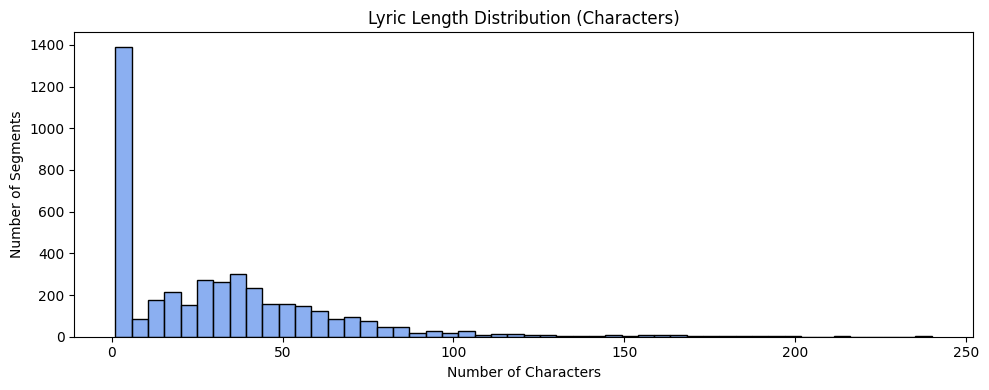

Percentage of segments with '-' as lyrics: 29.29%

Top 20 most frequent words:
the: 1084
you: 1006
i: 868
to: 703
and: 585
me: 544
a: 507
my: 499
in: 354
it: 343
oh: 303
of: 280
on: 272
i'm: 263
for: 250
all: 240
this: 234
your: 224
we: 208
be: 207


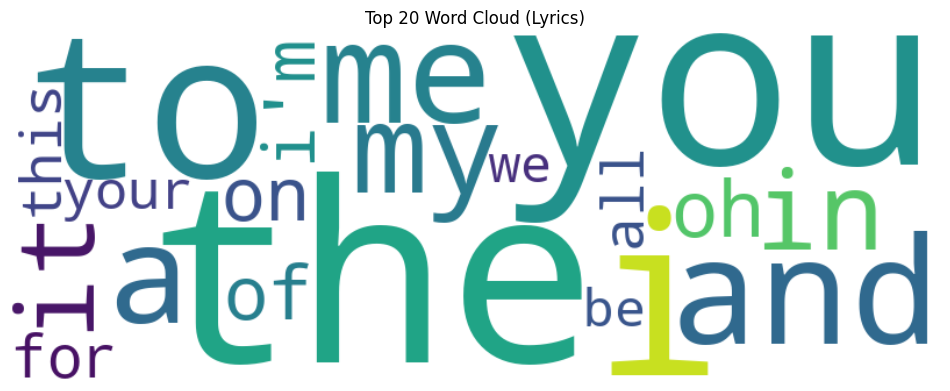

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

# Load data
segments_df = pd.read_csv(DATA_PROCESSED / "all_segments.csv")

# Clean and filter
segments_df = segments_df[segments_df["Lyric"].notna()]
segments_df["Lyric"] = segments_df["Lyric"].str.strip()

# --- Plot lyric length in characters ---
segments_df["LyricLength"] = segments_df["Lyric"].str.len()

plt.figure(figsize=(10, 4))
sns.histplot(segments_df["LyricLength"], bins=50, color="cornflowerblue")
plt.title("Lyric Length Distribution (Characters)")
plt.xlabel("Number of Characters")
plt.ylabel("Number of Segments")
plt.tight_layout()
plt.savefig(OUT_DIR / "lyric_length_distribution.png")
plt.show()

# --- Calculate % of empty or placeholder lyrics ---

empty_ratio = (segments_df["Lyric"].apply(lambda x: isinstance(x, str) and x.strip() in ["", "-"])).mean() * 100
print(f"Percentage of segments with '-' as lyrics: {empty_ratio:.2f}%")

# --- Word frequency (basic tokenization) ---
lyrics_text = " ".join(segments_df[segments_df["Lyric"] != "-"]["Lyric"].tolist()).lower()
words = lyrics_text.split()
common_words = Counter(words).most_common(20)

# Display top 20 words
print("\nTop 20 most frequent words:")
for word, count in common_words:
    print(f"{word}: {count}")

# ---  Word cloud ---
wordcloud = WordCloud(width=800, height=300, background_color="white").generate_from_frequencies(dict(common_words))
plt.figure(figsize=(12, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Top 20 Word Cloud (Lyrics)")
plt.show()


### Add `has_lyrics` Column for Blank Segment Handling

Nearly 30% of the lyric segments contain a placeholder ("-") indicating no vocals.  
To support future masking and model supervision logic, I add a `has_lyrics` column:

- `True` → segment contains real lyrics
- `False` → instrumental or blank segment

These will remain in the dataset to help the model learn when *not* to transcribe.

It will also be used for binary classification modelling


In [ ]:
import pandas as pd

# Paths
train_path = DATA_PROCESSED / "train_segments_chunked.csv"  # chunked audio segments
test_path  = DATA_PROCESSED / "test_segments.csv"           # not chunked, for EDA
all_path   = DATA_PROCESSED / "all_segments.csv"            # not chunked, for EDA

# Load
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
all_df = pd.read_csv(all_path)

# Define lyric validity logic
def has_real_lyrics(text):
    return isinstance(text, str) and text.strip() not in ["", "-"]

# Add has_lyrics column
train_df["has_lyrics"] = train_df["Lyric"].apply(has_real_lyrics)
test_df["has_lyrics"] = test_df["Lyric"].apply(has_real_lyrics)
all_df["has_lyrics"] = all_df["Lyric"].apply(has_real_lyrics)

# Save
train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)
all_df.to_csv(all_path, index=False)

# Report stats
print(f"Train: {train_df['has_lyrics'].mean() * 100:.2f}% real lyrics")
print(f"Test: {test_df['has_lyrics'].mean() * 100:.2f}% real lyrics")
print(f"All: {all_df['has_lyrics'].mean() * 100:.2f}% real lyrics")


Train: 69.56% real lyrics
Test: 72.90% real lyrics
All: 70.71% real lyrics


short example for one entery

In [ ]:
print(
    train_df[
        train_df["chunk_path"] == str(CHUNKS_DIR / "A Classic Education - NightOwl_150.00_158.00.wav")
    ]["Lyric"]
)


19    don't you know it's all passages
Name: Lyric, dtype: object


## Test Set Audio Chunking

This cell slices the full mixture audio of each test song into lyric-aligned chunks.  
Each chunk is saved as a 16kHz mono WAV file and linked to its corresponding lyric.

In [ ]:
import os
import pandas as pd
from pydub import AudioSegment
from tqdm import tqdm

# Define Paths
MUSDB_TEST_DIR = DATA_RAW / "musdb18" / "test"              # raw audio (.stem.mp4 files)
TEST_SEGMENTS_CSV = DATA_PROCESSED / "test_segments.csv"    # aligned lyrics segments
CHUNKS_DIR = DATA_PROCESSED / "audio_chunks" / "test"       # save chunks here
CHUNKS_DIR.mkdir(parents=True, exist_ok=True)

# Load full dataset with lyric segments ===
# This file must contain: 'Song', 'Start', 'End', 'Lyric', 'Split', etc.
test_segments = pd.read_csv(TEST_SEGMENTS_CSV)

# Initialize list to hold processed rows ===
chunked_rows = []

# Loop over each unique song and process all its lyric segments ===
for song, group in tqdm(test_segments.groupby('Song'), total=test_segments['Song'].nunique()):
    try:
        # Load full song audio once
        audio_path = MUSDB_TEST_DIR / f"{song}.stem.mp4"
        audio = AudioSegment.from_file(str(audio_path)).set_channels(1).set_frame_rate(16000)

        # Slice out each lyric segment from the full audio
        for _, row in group.iterrows():
            start_ms = int(row['Start'] * 1000)
            end_ms = int(row['End'] * 1000)
            chunk_name = f"{song}_{row['Start']:.2f}_{row['End']:.2f}.wav"
            chunk_path = CHUNKS_DIR / chunk_name

            # Extract, resample, and save as WAV
            chunk = audio[start_ms:end_ms]
            chunk.export(chunk_path, format="wav")

            # Add chunk path to row and store
            row = row.copy()
            row['chunk_path'] = str(chunk_path)
            chunked_rows.append(row)

    except Exception as e:
        print(f"⚠️ Failed to process {song}: {e}")

# Create final DataFrame and export for modeling ===
test_segments_chunked = pd.DataFrame(chunked_rows)
out_csv = DATA_PROCESSED / "test_segments_chunked.csv"
test_segments_chunked.to_csv(out_csv, index=False)


100%|██████████| 45/45 [03:17<00:00,  4.39s/it]


# Baseline Whisper Transcription

## Load Whisper Model

In [ ]:
# Load the Whisper model
model = whisper.load_model(MODEL_NAME)


100%|███████████████████████████████████████| 139M/139M [00:02<00:00, 65.6MiB/s]


## Few sample transcribe check

###Transcribe  audio chunks using Whisper

In [ ]:
# Helper: transcribe a single audio chunk and return predicted text
def transcribe_chunk(file_path):
    result = model.transcribe(file_path, verbose=False)
    return result['text']

# Run on a small sample (e.g., first 5 rows)
sample_df = df.sample(5, random_state=42).copy()
sample_df['prediction'] = sample_df['chunk_path'].apply(transcribe_chunk)



Detected language: English


100%|██████████| 1000/1000 [00:00<00:00, 1067.81frames/s]


Detected language: English


100%|██████████| 500/500 [00:00<00:00, 5154.34frames/s]


Detected language: English


100%|██████████| 600/600 [00:00<00:00, 2148.28frames/s]


Detected language: English


100%|██████████| 700/700 [00:00<00:00, 745.15frames/s]


Detected language: English


100%|██████████| 800/800 [00:01<00:00, 709.01frames/s]


###Normalize both Whisper transcription and true lyrics (gold-label)

normalization include lowercasing, whitespace strip, punctuation removal

In [ ]:
import re

def normalize(text):
    # Lowercase and strip
    text = text.lower().strip()
    # Remove punctuation using regex (keeps only alphanumerics and spaces)
    text = re.sub(r"[^\w\s]", "", text)
    return text


# Apply to both ground truth and prediction
sample_df['Lyric_clean'] = sample_df['Lyric'].apply(normalize)
sample_df['prediction_clean'] = sample_df['prediction'].apply(normalize)


print(sample_df[['Lyric_clean', 'prediction_clean', 'chunk_path'] ])


                                            Lyric_clean  \
1604                   im not right im not right im not   
1906                         he he went to look for her   
70    so take your twelve strings to the antic shop ...   
1894                  all my good never shows all i try   
1731  the righteous days of the past are nothing but...   

                                       prediction_clean  \
1604                   im not right im not right im not   
1906                            he went to look for her   
70    to take your toll streets to the attic shop th...   
1894              for all my food never shows attention   
1731                      a fireful world a night comes   

                                             chunk_path  
1604  /content/drive/MyDrive/DS_course/Deep_Learning...  
1906  /content/drive/MyDrive/DS_course/Deep_Learning...  
70    /content/drive/MyDrive/DS_course/Deep_Learning...  
1894  /content/drive/MyDrive/DS_course/Deep_Learning...  


### Evaluate Baseline WER and CER

In [ ]:
# Compute metrics
sample_df['WER'] = sample_df.apply(lambda row: wer(row['Lyric'], row['prediction']), axis=1)
sample_df['CER'] = sample_df.apply(lambda row: cer(row['Lyric'], row['prediction']), axis=1)

# Display average scores
print("Before Normalization (raw text) :")
print(f"Average WER : {sample_df['WER'].mean():.3f}")
print(f"Average CER : {sample_df['CER'].mean():.3f}")

# Compute metrics on normalized text
sample_df['WER_norm'] = sample_df.apply(lambda row: wer(row['Lyric_clean'], row['prediction_clean']), axis=1)
sample_df['CER_norm'] = sample_df.apply(lambda row: cer(row['Lyric_clean'], row['prediction_clean']), axis=1)

print("\nAfter Normalization:")
print(f"Average WER (normalized): {sample_df['WER_norm'].mean():.3f}")
print(f"Average CER (normalized): {sample_df['CER_norm'].mean():.3f}")


Before Normalization (raw text) :
Average WER : 0.632
Average CER : 0.344

After Normalization:
Average WER (normalized): 0.466
Average CER (normalized): 0.295


## Full Inference + Evaluation + Export

In [ ]:
from tqdm import tqdm
from jiwer import wer, cer
import re

# Normalize function (lowercase, strip, remove punctuation)
def normalize(text):
    text = text.lower().strip()
    text = re.sub(r"[^\w\s]", "", text)
    return text

# Create results list
results = []

# Iterate through all segments
for _, row in tqdm(df.iterrows(), total=len(df), desc="Transcribing"):
    audio_path = row['chunk_path']
    true_lyric = row['Lyric']

    try:
        pred = model.transcribe(audio_path, verbose=False)['text']
    except Exception as e:
        pred = ""

    # Normalize
    true_clean = normalize(true_lyric)
    pred_clean = normalize(pred)

    # Compute metrics
    wer_score = wer(true_clean, pred_clean)
    cer_score = cer(true_clean, pred_clean)

    # Store result
    results.append({
        "Song": row['Song'],
        "Start": row['Start'],
        "End": row['End'],
        "Duration": row['Duration'],
        "Lyric": true_lyric,
        "Prediction": pred,
        "Lyric_clean": true_clean,
        "Prediction_clean": pred_clean,
        "WER": wer_score,
        "CER": cer_score,
        "Words": row['Words']
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
output_path = DATA_PROCESSED / "whisper_init_transcription_results.csv"
results_df.to_csv(output_path, index=False)
print(f"\n✅ Exported results to: {output_path}")
print(f"Average WER: {results_df['WER'].mean():.3f}")
print(f"Average CER: {results_df['CER'].mean():.3f}")


Transcribing:   0%|          | 0/1940 [00:00<?, ?it/s]

Detected language: English



Transcribing:   0%|          | 1/1940 [00:00<32:01,  1.01it/s]

Detected language: English



Transcribing:   0%|          | 2/1940 [00:01<26:52,  1.20it/s]

Detected language: English



Transcribing:   0%|          | 3/1940 [00:02<32:38,  1.01s/it]

Detected language: English



Transcribing:   0%|          | 4/1940 [00:04<34:04,  1.06s/it]

Detected language: English



Transcribing:   0%|          | 5/1940 [00:05<36:08,  1.12s/it]

Detected language: English



Transcribing:   0%|          | 6/1940 [00:06<33:26,  1.04s/it]

Detected language: English



Transcribing:   0%|          | 7/1940 [00:07<38:43,  1.20s/it]

Detected language: English



Transcribing:   0%|          | 8/1940 [00:08<38:32,  1.20s/it]

Detected language: English



Transcribing:   0%|          | 9/1940 [00:16<1:39:49,  3.10s/it]

Detected language: English



Transcribing:   1%|          | 10/1940 [00:26<2:48:09,  5.23s/it]

Detected language: English



Transcribing:   1%|          | 11/1940 [00:27<2:06:30,  3.94s/it]

Detected language: English



Transcribing:   1%|          | 12/1940 [00:35<2:44:49,  5.13s/it]

Detected language: English



Transcribing:   1%|          | 13/1940 [00:36<2:07:28,  3.97s/it]

Detected language: English



Transcribing:   1%|          | 14/1940 [00:37<1:38:19,  3.06s/it]

Detected language: English



Transcribing:   1%|          | 15/1940 [00:38<1:21:53,  2.55s/it]

Detected language: English



Transcribing:   1%|          | 16/1940 [00:39<1:03:08,  1.97s/it]

Detected language: English



Transcribing:   1%|          | 17/1940 [00:40<53:56,  1.68s/it]  

Detected language: English



Transcribing:   1%|          | 18/1940 [00:41<50:37,  1.58s/it]

Detected language: English



Transcribing:   1%|          | 19/1940 [00:42<45:29,  1.42s/it]

Detected language: English



Transcribing:   1%|          | 20/1940 [00:43<43:36,  1.36s/it]

Detected language: English



Transcribing:   1%|          | 21/1940 [00:46<57:19,  1.79s/it]

Detected language: English



Transcribing:   1%|          | 22/1940 [00:47<48:28,  1.52s/it]

Detected language: English



Transcribing:   1%|          | 23/1940 [00:48<46:50,  1.47s/it]

Detected language: English



Transcribing:   1%|          | 24/1940 [00:50<49:19,  1.54s/it]

Detected language: English



Transcribing:   1%|▏         | 25/1940 [00:52<49:18,  1.54s/it]

Detected language: English



Transcribing:   1%|▏         | 26/1940 [00:52<40:57,  1.28s/it]

Detected language: English



Transcribing:   1%|▏         | 27/1940 [00:54<47:59,  1.51s/it]

Detected language: English



Transcribing:   1%|▏         | 28/1940 [00:58<1:11:17,  2.24s/it]

Detected language: English



Transcribing:   1%|▏         | 29/1940 [01:00<1:04:06,  2.01s/it]

Detected language: English



Transcribing:   2%|▏         | 30/1940 [01:01<55:08,  1.73s/it]  

Detected language: English



Transcribing:   2%|▏         | 31/1940 [01:02<52:02,  1.64s/it]

Detected language: English



Transcribing:   2%|▏         | 32/1940 [01:03<43:21,  1.36s/it]

Detected language: English



Transcribing:   2%|▏         | 33/1940 [01:05<44:58,  1.42s/it]

Detected language: English



Transcribing:   2%|▏         | 34/1940 [01:06<47:51,  1.51s/it]

Detected language: English



Transcribing:   2%|▏         | 35/1940 [01:07<43:19,  1.36s/it]

Detected language: English



Transcribing:   2%|▏         | 36/1940 [01:11<1:03:20,  2.00s/it]

Detected language: English



Transcribing:   2%|▏         | 37/1940 [01:12<51:02,  1.61s/it]  

Detected language: English



Transcribing:   2%|▏         | 38/1940 [01:13<46:10,  1.46s/it]

Detected language: English



Transcribing:   2%|▏         | 39/1940 [01:18<1:25:14,  2.69s/it]

Detected language: English



Transcribing:   2%|▏         | 40/1940 [01:20<1:14:13,  2.34s/it]

Detected language: English



Transcribing:   2%|▏         | 41/1940 [01:21<1:01:48,  1.95s/it]

Detected language: English



Transcribing:   2%|▏         | 42/1940 [01:22<54:17,  1.72s/it]  

Detected language: English



Transcribing:   2%|▏         | 43/1940 [01:23<49:26,  1.56s/it]

Detected language: English



Transcribing:   2%|▏         | 44/1940 [01:24<41:49,  1.32s/it]

Detected language: English



Transcribing:   2%|▏         | 45/1940 [01:25<37:44,  1.19s/it]

Detected language: English



Transcribing:   2%|▏         | 46/1940 [01:26<34:27,  1.09s/it]

Detected language: English



Transcribing:   2%|▏         | 47/1940 [01:27<32:56,  1.04s/it]

Detected language: English



Transcribing:   2%|▏         | 48/1940 [01:27<30:10,  1.05it/s]

Detected language: English



Transcribing:   3%|▎         | 49/1940 [01:29<32:08,  1.02s/it]

Detected language: English



Transcribing:   3%|▎         | 50/1940 [01:30<37:16,  1.18s/it]

Detected language: English



Transcribing:   3%|▎         | 51/1940 [01:32<41:17,  1.31s/it]

Detected language: English



Transcribing:   3%|▎         | 52/1940 [01:34<46:22,  1.47s/it]

Detected language: English



Transcribing:   3%|▎         | 53/1940 [01:34<38:43,  1.23s/it]

Detected language: English



Transcribing:   3%|▎         | 54/1940 [01:35<38:04,  1.21s/it]

Detected language: English



Transcribing:   3%|▎         | 55/1940 [01:36<33:11,  1.06s/it]

Detected language: English



Transcribing:   3%|▎         | 56/1940 [01:37<34:50,  1.11s/it]

Detected language: English



Transcribing:   3%|▎         | 57/1940 [01:38<32:25,  1.03s/it]

Detected language: English



Transcribing:   3%|▎         | 58/1940 [01:39<31:26,  1.00s/it]

Detected language: English



Transcribing:   3%|▎         | 59/1940 [01:41<36:09,  1.15s/it]

Detected language: English



Transcribing:   3%|▎         | 60/1940 [01:41<32:58,  1.05s/it]

Detected language: English



Transcribing:   3%|▎         | 61/1940 [01:43<39:49,  1.27s/it]

Detected language: English



Transcribing:   3%|▎         | 62/1940 [01:44<35:25,  1.13s/it]

Detected language: English



Transcribing:   3%|▎         | 63/1940 [01:45<37:18,  1.19s/it]

Detected language: English



Transcribing:   3%|▎         | 64/1940 [01:46<34:18,  1.10s/it]

Detected language: English



Transcribing:   3%|▎         | 65/1940 [01:47<31:31,  1.01s/it]

Detected language: English



Transcribing:   3%|▎         | 66/1940 [01:48<29:28,  1.06it/s]

Detected language: English



Transcribing:   3%|▎         | 67/1940 [01:49<28:29,  1.10it/s]

Detected language: English



Transcribing:   4%|▎         | 68/1940 [01:49<27:39,  1.13it/s]

Detected language: English



Transcribing:   4%|▎         | 69/1940 [01:50<27:39,  1.13it/s]

Detected language: English



Transcribing:   4%|▎         | 70/1940 [01:51<26:49,  1.16it/s]

Detected language: English



Transcribing:   4%|▎         | 71/1940 [01:52<23:02,  1.35it/s]

Detected language: English



Transcribing:   4%|▎         | 72/1940 [01:53<25:54,  1.20it/s]

Detected language: English



Transcribing:   4%|▍         | 73/1940 [01:54<26:11,  1.19it/s]

Detected language: English



Transcribing:   4%|▍         | 74/1940 [01:54<25:25,  1.22it/s]

Detected language: English



Transcribing:   4%|▍         | 75/1940 [01:55<24:20,  1.28it/s]

Detected language: English



Transcribing:   4%|▍         | 76/1940 [01:58<44:21,  1.43s/it]

Detected language: English



Transcribing:   4%|▍         | 77/1940 [02:01<57:40,  1.86s/it]

Detected language: English



Transcribing:   4%|▍         | 78/1940 [02:02<51:32,  1.66s/it]

Detected language: English



Transcribing:   4%|▍         | 79/1940 [02:04<51:16,  1.65s/it]

Detected language: English



Transcribing:   4%|▍         | 80/1940 [02:04<42:26,  1.37s/it]

Detected language: English



Transcribing:   4%|▍         | 81/1940 [02:05<36:23,  1.17s/it]

Detected language: English



Transcribing:   4%|▍         | 82/1940 [02:06<36:38,  1.18s/it]

Detected language: English



Transcribing:   4%|▍         | 83/1940 [02:09<50:51,  1.64s/it]

Detected language: English



Transcribing:   4%|▍         | 84/1940 [02:11<54:39,  1.77s/it]

Detected language: English



Transcribing:   4%|▍         | 85/1940 [02:12<50:32,  1.63s/it]

Detected language: Spanish



Transcribing:   4%|▍         | 86/1940 [02:14<47:47,  1.55s/it]

Detected language: English



Transcribing:   4%|▍         | 87/1940 [02:15<42:06,  1.36s/it]

Detected language: English



Transcribing:   5%|▍         | 88/1940 [02:15<35:59,  1.17s/it]

Detected language: English



Transcribing:   5%|▍         | 89/1940 [02:17<38:51,  1.26s/it]

Detected language: English



Transcribing:   5%|▍         | 90/1940 [02:18<42:44,  1.39s/it]

Detected language: Japanese



Transcribing:   5%|▍         | 91/1940 [02:22<1:02:39,  2.03s/it]

Detected language: English



Transcribing:   5%|▍         | 92/1940 [02:24<57:27,  1.87s/it]  

Detected language: English



Transcribing:   5%|▍         | 93/1940 [02:24<47:26,  1.54s/it]

Detected language: English



Transcribing:   5%|▍         | 94/1940 [02:25<39:13,  1.28s/it]

Detected language: English



Transcribing:   5%|▍         | 95/1940 [02:27<46:43,  1.52s/it]

Detected language: English



Transcribing:   5%|▍         | 96/1940 [02:28<40:26,  1.32s/it]

Detected language: English



Transcribing:   5%|▌         | 97/1940 [02:36<1:43:38,  3.37s/it]

Detected language: English



Transcribing:   5%|▌         | 98/1940 [02:37<1:22:42,  2.69s/it]

Detected language: English



Transcribing:   5%|▌         | 99/1940 [02:39<1:10:17,  2.29s/it]

Detected language: English



Transcribing:   5%|▌         | 100/1940 [02:39<56:06,  1.83s/it] 

Detected language: English



Transcribing:   5%|▌         | 101/1940 [02:40<46:03,  1.50s/it]

Detected language: English



Transcribing:   5%|▌         | 102/1940 [02:41<40:38,  1.33s/it]

Detected language: English



Transcribing:   5%|▌         | 103/1940 [02:42<34:48,  1.14s/it]

Detected language: English



Transcribing:   5%|▌         | 104/1940 [02:42<30:33,  1.00it/s]

Detected language: English



Transcribing:   5%|▌         | 105/1940 [02:43<27:51,  1.10it/s]

Detected language: English



Transcribing:   5%|▌         | 106/1940 [02:44<31:30,  1.03s/it]

Detected language: English



Transcribing:   6%|▌         | 107/1940 [02:45<27:50,  1.10it/s]

Detected language: English



Transcribing:   6%|▌         | 108/1940 [02:46<32:22,  1.06s/it]

Detected language: English



Transcribing:   6%|▌         | 109/1940 [02:48<33:31,  1.10s/it]

Detected language: English



Transcribing:   6%|▌         | 110/1940 [02:48<30:55,  1.01s/it]

Detected language: English



Transcribing:   6%|▌         | 111/1940 [02:49<30:20,  1.00it/s]

Detected language: English



Transcribing:   6%|▌         | 112/1940 [02:50<28:18,  1.08it/s]

Detected language: English



Transcribing:   6%|▌         | 113/1940 [02:51<27:12,  1.12it/s]

Detected language: English



Transcribing:   6%|▌         | 114/1940 [02:53<36:13,  1.19s/it]

Detected language: English



Transcribing:   6%|▌         | 115/1940 [02:54<36:48,  1.21s/it]

Detected language: English



Transcribing:   6%|▌         | 116/1940 [02:55<34:44,  1.14s/it]

Detected language: English



Transcribing:   6%|▌         | 117/1940 [02:56<30:51,  1.02s/it]

Detected language: English



Transcribing:   6%|▌         | 118/1940 [02:57<32:14,  1.06s/it]

Detected language: English



Transcribing:   6%|▌         | 119/1940 [02:58<28:58,  1.05it/s]

Detected language: English



Transcribing:   6%|▌         | 120/1940 [03:00<39:23,  1.30s/it]

Detected language: English



Transcribing:   6%|▌         | 121/1940 [03:01<35:00,  1.15s/it]

Detected language: English



Transcribing:   6%|▋         | 122/1940 [03:01<32:50,  1.08s/it]

Detected language: English



Transcribing:   6%|▋         | 123/1940 [03:02<29:59,  1.01it/s]

Detected language: English



Transcribing:   6%|▋         | 124/1940 [03:03<26:45,  1.13it/s]

Detected language: English



Transcribing:   6%|▋         | 125/1940 [03:04<25:39,  1.18it/s]

Detected language: English



Transcribing:   6%|▋         | 126/1940 [03:05<31:40,  1.05s/it]

Detected language: English



Transcribing:   7%|▋         | 127/1940 [03:06<28:25,  1.06it/s]

Detected language: English



Transcribing:   7%|▋         | 128/1940 [03:07<29:47,  1.01it/s]

Detected language: English



Transcribing:   7%|▋         | 129/1940 [03:08<27:16,  1.11it/s]

Detected language: English



Transcribing:   7%|▋         | 130/1940 [03:09<29:22,  1.03it/s]

Detected language: English



Transcribing:   7%|▋         | 131/1940 [03:09<26:20,  1.14it/s]

Detected language: English



Transcribing:   7%|▋         | 132/1940 [03:11<28:54,  1.04it/s]

Detected language: English



Transcribing:   7%|▋         | 133/1940 [03:12<30:14,  1.00s/it]

Detected language: English



Transcribing:   7%|▋         | 134/1940 [03:14<40:56,  1.36s/it]

Detected language: English



Transcribing:   7%|▋         | 135/1940 [03:17<58:25,  1.94s/it]

Detected language: English



Transcribing:   7%|▋         | 136/1940 [03:18<52:06,  1.73s/it]

Detected language: English



Transcribing:   7%|▋         | 137/1940 [03:19<42:27,  1.41s/it]

Detected language: English



Transcribing:   7%|▋         | 138/1940 [03:20<39:29,  1.31s/it]

Detected language: English



Transcribing:   7%|▋         | 139/1940 [03:23<49:29,  1.65s/it]

Detected language: English



Transcribing:   7%|▋         | 140/1940 [03:24<44:44,  1.49s/it]

Detected language: English



Transcribing:   7%|▋         | 141/1940 [03:25<41:30,  1.38s/it]

Detected language: Japanese



Transcribing:   7%|▋         | 142/1940 [03:31<1:20:20,  2.68s/it]

Detected language: English



Transcribing:   7%|▋         | 143/1940 [03:31<1:02:28,  2.09s/it]

Detected language: English



Transcribing:   7%|▋         | 144/1940 [03:32<51:52,  1.73s/it]  

Detected language: English



Transcribing:   7%|▋         | 145/1940 [03:34<51:55,  1.74s/it]

Detected language: English



Transcribing:   8%|▊         | 146/1940 [03:36<57:33,  1.92s/it]

Detected language: English



Transcribing:   8%|▊         | 147/1940 [03:37<46:43,  1.56s/it]

Detected language: English



Transcribing:   8%|▊         | 148/1940 [03:41<1:07:12,  2.25s/it]

Detected language: English



Transcribing:   8%|▊         | 149/1940 [03:44<1:14:03,  2.48s/it]

Detected language: English



Transcribing:   8%|▊         | 150/1940 [03:45<57:53,  1.94s/it]  

Detected language: English



Transcribing:   8%|▊         | 151/1940 [03:46<50:00,  1.68s/it]

Detected language: English



Transcribing:   8%|▊         | 152/1940 [03:46<41:07,  1.38s/it]

Detected language: English



Transcribing:   8%|▊         | 153/1940 [03:47<34:54,  1.17s/it]

Detected language: English



Transcribing:   8%|▊         | 154/1940 [03:48<35:49,  1.20s/it]

Detected language: English



Transcribing:   8%|▊         | 155/1940 [03:49<33:08,  1.11s/it]

Detected language: English



Transcribing:   8%|▊         | 156/1940 [03:51<35:31,  1.20s/it]

Detected language: English



Transcribing:   8%|▊         | 157/1940 [03:51<31:18,  1.05s/it]

Detected language: English



Transcribing:   8%|▊         | 158/1940 [03:53<36:25,  1.23s/it]

Detected language: English



Transcribing:   8%|▊         | 159/1940 [03:54<38:33,  1.30s/it]

Detected language: English



Transcribing:   8%|▊         | 160/1940 [03:55<36:51,  1.24s/it]

Detected language: English



Transcribing:   8%|▊         | 161/1940 [03:58<45:56,  1.55s/it]

Detected language: English



Transcribing:   8%|▊         | 162/1940 [03:59<41:39,  1.41s/it]

Detected language: English



Transcribing:   8%|▊         | 163/1940 [04:00<39:01,  1.32s/it]

Detected language: English



Transcribing:   8%|▊         | 164/1940 [04:01<32:39,  1.10s/it]

Detected language: English



Transcribing:   9%|▊         | 165/1940 [04:01<28:00,  1.06it/s]

Detected language: English



Transcribing:   9%|▊         | 166/1940 [04:02<29:27,  1.00it/s]

Detected language: English



Transcribing:   9%|▊         | 167/1940 [04:03<26:09,  1.13it/s]

Detected language: English



Transcribing:   9%|▊         | 168/1940 [04:04<25:53,  1.14it/s]

Detected language: English



Transcribing:   9%|▊         | 169/1940 [04:04<25:12,  1.17it/s]

Detected language: English



Transcribing:   9%|▉         | 170/1940 [04:05<24:39,  1.20it/s]

Detected language: English



Transcribing:   9%|▉         | 171/1940 [04:06<27:34,  1.07it/s]

Detected language: English



Transcribing:   9%|▉         | 172/1940 [04:07<25:31,  1.15it/s]

Detected language: English



Transcribing:   9%|▉         | 173/1940 [04:08<25:01,  1.18it/s]

Detected language: English



Transcribing:   9%|▉         | 174/1940 [04:09<23:37,  1.25it/s]

Detected language: English



Transcribing:   9%|▉         | 175/1940 [04:10<26:13,  1.12it/s]

Detected language: English



Transcribing:   9%|▉         | 176/1940 [04:11<26:59,  1.09it/s]

Detected language: English



Transcribing:   9%|▉         | 177/1940 [04:12<25:37,  1.15it/s]

Detected language: English



Transcribing:   9%|▉         | 178/1940 [04:12<25:16,  1.16it/s]

Detected language: English



Transcribing:   9%|▉         | 179/1940 [04:13<24:24,  1.20it/s]

Detected language: English



Transcribing:   9%|▉         | 180/1940 [04:14<23:06,  1.27it/s]

Detected language: English



Transcribing:   9%|▉         | 181/1940 [04:14<21:39,  1.35it/s]

Detected language: English



Transcribing:   9%|▉         | 182/1940 [04:15<22:02,  1.33it/s]

Detected language: English



Transcribing:   9%|▉         | 183/1940 [04:16<23:13,  1.26it/s]

Detected language: English



Transcribing:   9%|▉         | 184/1940 [04:17<22:44,  1.29it/s]

Detected language: English



Transcribing:  10%|▉         | 185/1940 [04:18<24:44,  1.18it/s]

Detected language: English



Transcribing:  10%|▉         | 186/1940 [04:19<24:49,  1.18it/s]

Detected language: English



Transcribing:  10%|▉         | 187/1940 [04:19<23:48,  1.23it/s]

Detected language: English



Transcribing:  10%|▉         | 188/1940 [04:20<23:08,  1.26it/s]

Detected language: English



Transcribing:  10%|▉         | 189/1940 [04:21<23:24,  1.25it/s]

Detected language: English



Transcribing:  10%|▉         | 190/1940 [04:22<23:20,  1.25it/s]

Detected language: English



Transcribing:  10%|▉         | 191/1940 [04:23<23:29,  1.24it/s]

Detected language: English



Transcribing:  10%|▉         | 192/1940 [04:23<22:51,  1.27it/s]

Detected language: English



Transcribing:  10%|▉         | 193/1940 [04:24<22:51,  1.27it/s]

Detected language: English



Transcribing:  10%|█         | 194/1940 [04:25<25:16,  1.15it/s]

Detected language: English



Transcribing:  10%|█         | 195/1940 [04:26<23:25,  1.24it/s]

Detected language: English



Transcribing:  10%|█         | 196/1940 [04:27<23:29,  1.24it/s]

Detected language: English



Transcribing:  10%|█         | 197/1940 [04:27<23:00,  1.26it/s]

Detected language: English



Transcribing:  10%|█         | 198/1940 [04:28<24:54,  1.17it/s]

Detected language: English



Transcribing:  10%|█         | 199/1940 [04:29<25:10,  1.15it/s]

Detected language: English



Transcribing:  10%|█         | 200/1940 [04:30<25:36,  1.13it/s]

Detected language: English



Transcribing:  10%|█         | 201/1940 [04:31<25:18,  1.15it/s]

Detected language: English



Transcribing:  10%|█         | 202/1940 [04:32<25:22,  1.14it/s]

Detected language: English



Transcribing:  10%|█         | 203/1940 [04:33<29:12,  1.01s/it]

Detected language: English



Transcribing:  11%|█         | 204/1940 [04:34<29:21,  1.01s/it]

Detected language: English



Transcribing:  11%|█         | 205/1940 [04:35<28:00,  1.03it/s]

Detected language: English



Transcribing:  11%|█         | 206/1940 [04:36<28:45,  1.01it/s]

Detected language: English



Transcribing:  11%|█         | 207/1940 [04:37<26:36,  1.09it/s]

Detected language: English



Transcribing:  11%|█         | 208/1940 [04:38<24:22,  1.18it/s]

Detected language: English



Transcribing:  11%|█         | 209/1940 [04:39<24:51,  1.16it/s]

Detected language: English



Transcribing:  11%|█         | 210/1940 [04:39<24:20,  1.18it/s]

Detected language: English



Transcribing:  11%|█         | 211/1940 [04:40<22:44,  1.27it/s]

Detected language: English



Transcribing:  11%|█         | 212/1940 [04:41<21:41,  1.33it/s]

Detected language: English



Transcribing:  11%|█         | 213/1940 [04:42<23:09,  1.24it/s]

Detected language: English



Transcribing:  11%|█         | 214/1940 [04:42<22:52,  1.26it/s]

Detected language: English



Transcribing:  11%|█         | 215/1940 [04:43<23:01,  1.25it/s]

Detected language: English



Transcribing:  11%|█         | 216/1940 [04:44<25:08,  1.14it/s]

Detected language: English



Transcribing:  11%|█         | 217/1940 [04:45<23:59,  1.20it/s]

Detected language: English



Transcribing:  11%|█         | 218/1940 [04:46<24:36,  1.17it/s]

Detected language: English



Transcribing:  11%|█▏        | 219/1940 [04:47<23:21,  1.23it/s]

Detected language: English



Transcribing:  11%|█▏        | 220/1940 [04:47<22:34,  1.27it/s]

Detected language: English



Transcribing:  11%|█▏        | 221/1940 [04:48<23:01,  1.24it/s]

Detected language: English



Transcribing:  11%|█▏        | 222/1940 [04:49<21:46,  1.31it/s]

Detected language: English



Transcribing:  11%|█▏        | 223/1940 [04:50<22:44,  1.26it/s]

Detected language: English



Transcribing:  12%|█▏        | 224/1940 [04:50<22:10,  1.29it/s]

Detected language: English



Transcribing:  12%|█▏        | 225/1940 [04:51<20:52,  1.37it/s]

Detected language: English



Transcribing:  12%|█▏        | 226/1940 [04:52<25:01,  1.14it/s]

Detected language: English



Transcribing:  12%|█▏        | 227/1940 [04:53<25:14,  1.13it/s]

Detected language: English



Transcribing:  12%|█▏        | 228/1940 [04:54<25:34,  1.12it/s]

Detected language: English



Transcribing:  12%|█▏        | 229/1940 [04:55<25:15,  1.13it/s]

Detected language: English



Transcribing:  12%|█▏        | 230/1940 [04:56<25:47,  1.11it/s]

Detected language: English



Transcribing:  12%|█▏        | 231/1940 [04:57<25:31,  1.12it/s]

Detected language: English



Transcribing:  12%|█▏        | 232/1940 [04:58<23:54,  1.19it/s]

Detected language: English



Transcribing:  12%|█▏        | 233/1940 [04:59<26:02,  1.09it/s]

Detected language: English



Transcribing:  12%|█▏        | 234/1940 [04:59<25:10,  1.13it/s]

Detected language: English



Transcribing:  12%|█▏        | 235/1940 [05:00<24:27,  1.16it/s]

Detected language: English



Transcribing:  12%|█▏        | 236/1940 [05:01<24:03,  1.18it/s]

Detected language: English



Transcribing:  12%|█▏        | 237/1940 [05:02<25:22,  1.12it/s]

Detected language: English



Transcribing:  12%|█▏        | 238/1940 [05:03<23:50,  1.19it/s]

Detected language: English



Transcribing:  12%|█▏        | 239/1940 [05:04<24:25,  1.16it/s]

Detected language: English



Transcribing:  12%|█▏        | 240/1940 [05:04<23:50,  1.19it/s]

Detected language: English



Transcribing:  12%|█▏        | 241/1940 [05:05<24:02,  1.18it/s]

Detected language: English



Transcribing:  12%|█▏        | 242/1940 [05:06<23:37,  1.20it/s]

Detected language: English



Transcribing:  13%|█▎        | 243/1940 [05:07<22:05,  1.28it/s]

Detected language: English



Transcribing:  13%|█▎        | 244/1940 [05:08<23:19,  1.21it/s]

Detected language: English



Transcribing:  13%|█▎        | 245/1940 [05:09<23:06,  1.22it/s]

Detected language: English



Transcribing:  13%|█▎        | 246/1940 [05:09<23:05,  1.22it/s]

Detected language: English



Transcribing:  13%|█▎        | 247/1940 [05:10<23:15,  1.21it/s]

Detected language: English



Transcribing:  13%|█▎        | 248/1940 [05:11<22:36,  1.25it/s]

Detected language: English



Transcribing:  13%|█▎        | 249/1940 [05:12<21:16,  1.32it/s]

Detected language: English



Transcribing:  13%|█▎        | 250/1940 [05:12<20:02,  1.41it/s]

Detected language: English



Transcribing:  13%|█▎        | 251/1940 [05:13<21:44,  1.29it/s]

Detected language: English



Transcribing:  13%|█▎        | 252/1940 [05:14<21:52,  1.29it/s]

Detected language: English



Transcribing:  13%|█▎        | 253/1940 [05:15<22:04,  1.27it/s]

Detected language: English



Transcribing:  13%|█▎        | 254/1940 [05:16<27:26,  1.02it/s]

Detected language: English



Transcribing:  13%|█▎        | 255/1940 [05:17<24:33,  1.14it/s]

Detected language: English



Transcribing:  13%|█▎        | 256/1940 [05:18<23:42,  1.18it/s]

Detected language: English



Transcribing:  13%|█▎        | 257/1940 [05:18<21:46,  1.29it/s]

Detected language: English



Transcribing:  13%|█▎        | 258/1940 [05:19<22:12,  1.26it/s]

Detected language: English



Transcribing:  13%|█▎        | 259/1940 [05:20<21:48,  1.28it/s]

Detected language: English



Transcribing:  13%|█▎        | 260/1940 [05:21<23:34,  1.19it/s]

Detected language: English



Transcribing:  13%|█▎        | 261/1940 [05:22<23:57,  1.17it/s]

Detected language: English



Transcribing:  14%|█▎        | 262/1940 [05:22<24:00,  1.16it/s]

Detected language: English



Transcribing:  14%|█▎        | 263/1940 [05:23<23:43,  1.18it/s]

Detected language: Spanish



Transcribing:  14%|█▎        | 264/1940 [05:24<23:25,  1.19it/s]

Detected language: English



Transcribing:  14%|█▎        | 265/1940 [05:25<22:51,  1.22it/s]

Detected language: English



Transcribing:  14%|█▎        | 266/1940 [05:26<23:24,  1.19it/s]

Detected language: English



Transcribing:  14%|█▍        | 267/1940 [05:26<22:14,  1.25it/s]

Detected language: English



Transcribing:  14%|█▍        | 268/1940 [05:27<21:29,  1.30it/s]

Detected language: English



Transcribing:  14%|█▍        | 269/1940 [05:28<22:17,  1.25it/s]

Detected language: English



Transcribing:  14%|█▍        | 270/1940 [05:29<22:00,  1.26it/s]

Detected language: English



Transcribing:  14%|█▍        | 271/1940 [05:29<21:12,  1.31it/s]

Detected language: English



Transcribing:  14%|█▍        | 272/1940 [05:30<20:32,  1.35it/s]

Detected language: English



Transcribing:  14%|█▍        | 273/1940 [05:31<20:12,  1.37it/s]

Detected language: English



Transcribing:  14%|█▍        | 274/1940 [05:31<19:00,  1.46it/s]

Detected language: English



Transcribing:  14%|█▍        | 275/1940 [05:32<19:21,  1.43it/s]

Detected language: English



Transcribing:  14%|█▍        | 276/1940 [05:33<19:47,  1.40it/s]

Detected language: English



Transcribing:  14%|█▍        | 277/1940 [05:34<21:08,  1.31it/s]

Detected language: English



Transcribing:  14%|█▍        | 278/1940 [05:35<22:30,  1.23it/s]

Detected language: English



Transcribing:  14%|█▍        | 279/1940 [05:35<21:33,  1.28it/s]

Detected language: English



Transcribing:  14%|█▍        | 280/1940 [05:36<21:07,  1.31it/s]

Detected language: English



Transcribing:  14%|█▍        | 281/1940 [05:37<21:23,  1.29it/s]

Detected language: English



Transcribing:  15%|█▍        | 282/1940 [05:38<22:14,  1.24it/s]

Detected language: English



Transcribing:  15%|█▍        | 283/1940 [05:38<20:23,  1.35it/s]

Detected language: English



Transcribing:  15%|█▍        | 284/1940 [05:39<19:05,  1.45it/s]

Detected language: English



Transcribing:  15%|█▍        | 285/1940 [05:40<18:57,  1.46it/s]

Detected language: English



Transcribing:  15%|█▍        | 286/1940 [05:40<18:11,  1.51it/s]

Detected language: English



Transcribing:  15%|█▍        | 287/1940 [05:41<18:44,  1.47it/s]

Detected language: English



Transcribing:  15%|█▍        | 288/1940 [05:42<20:01,  1.38it/s]

Detected language: English



Transcribing:  15%|█▍        | 289/1940 [05:43<21:08,  1.30it/s]

Detected language: English



Transcribing:  15%|█▍        | 290/1940 [05:43<21:07,  1.30it/s]

Detected language: English



Transcribing:  15%|█▌        | 291/1940 [05:44<20:00,  1.37it/s]

Detected language: English



Transcribing:  15%|█▌        | 292/1940 [05:45<20:45,  1.32it/s]

Detected language: English



Transcribing:  15%|█▌        | 293/1940 [05:46<20:55,  1.31it/s]

Detected language: English



Transcribing:  15%|█▌        | 294/1940 [05:47<21:30,  1.28it/s]

Detected language: English



Transcribing:  15%|█▌        | 295/1940 [05:47<21:02,  1.30it/s]

Detected language: English



Transcribing:  15%|█▌        | 296/1940 [05:48<23:34,  1.16it/s]

Detected language: English



Transcribing:  15%|█▌        | 297/1940 [05:49<23:57,  1.14it/s]

Detected language: English



Transcribing:  15%|█▌        | 298/1940 [05:50<22:05,  1.24it/s]

Detected language: English



Transcribing:  15%|█▌        | 299/1940 [05:51<21:47,  1.25it/s]

Detected language: English



Transcribing:  15%|█▌        | 300/1940 [05:51<20:18,  1.35it/s]

Detected language: English



Transcribing:  16%|█▌        | 301/1940 [05:52<20:13,  1.35it/s]

Detected language: English



Transcribing:  16%|█▌        | 302/1940 [05:53<19:26,  1.40it/s]

Detected language: English



Transcribing:  16%|█▌        | 303/1940 [05:54<21:35,  1.26it/s]

Detected language: English



Transcribing:  16%|█▌        | 304/1940 [05:55<26:16,  1.04it/s]

Detected language: English



Transcribing:  16%|█▌        | 305/1940 [05:56<24:41,  1.10it/s]

Detected language: English



Transcribing:  16%|█▌        | 306/1940 [05:56<22:44,  1.20it/s]

Detected language: English



Transcribing:  16%|█▌        | 307/1940 [05:58<24:39,  1.10it/s]

Detected language: English



Transcribing:  16%|█▌        | 308/1940 [05:58<23:58,  1.13it/s]

Detected language: English



Transcribing:  16%|█▌        | 309/1940 [05:59<24:51,  1.09it/s]

Detected language: English



Transcribing:  16%|█▌        | 310/1940 [06:00<24:24,  1.11it/s]

Detected language: English



Transcribing:  16%|█▌        | 311/1940 [06:01<23:13,  1.17it/s]

Detected language: English



Transcribing:  16%|█▌        | 312/1940 [06:02<22:54,  1.18it/s]

Detected language: English



Transcribing:  16%|█▌        | 313/1940 [06:03<25:34,  1.06it/s]

Detected language: English



Transcribing:  16%|█▌        | 314/1940 [06:04<24:07,  1.12it/s]

Detected language: English



Transcribing:  16%|█▌        | 315/1940 [06:05<23:21,  1.16it/s]

Detected language: English



Transcribing:  16%|█▋        | 316/1940 [06:05<24:02,  1.13it/s]

Detected language: English



Transcribing:  16%|█▋        | 317/1940 [06:06<22:36,  1.20it/s]

Detected language: German



Transcribing:  16%|█▋        | 318/1940 [06:09<37:11,  1.38s/it]

Detected language: English



Transcribing:  16%|█▋        | 319/1940 [06:10<34:00,  1.26s/it]

Detected language: English



Transcribing:  16%|█▋        | 320/1940 [06:10<29:02,  1.08s/it]

Detected language: English



Transcribing:  17%|█▋        | 321/1940 [06:11<28:14,  1.05s/it]

Detected language: English



Transcribing:  17%|█▋        | 322/1940 [06:13<34:08,  1.27s/it]

Detected language: English



Transcribing:  17%|█▋        | 323/1940 [06:14<30:05,  1.12s/it]

Detected language: English



Transcribing:  17%|█▋        | 324/1940 [06:15<26:41,  1.01it/s]

Detected language: English



Transcribing:  17%|█▋        | 325/1940 [06:16<28:24,  1.06s/it]

Detected language: English



Transcribing:  17%|█▋        | 326/1940 [06:17<27:41,  1.03s/it]

Detected language: English



Transcribing:  17%|█▋        | 327/1940 [06:18<24:38,  1.09it/s]

Detected language: English



Transcribing:  17%|█▋        | 328/1940 [06:18<23:09,  1.16it/s]

Detected language: English



Transcribing:  17%|█▋        | 329/1940 [06:20<28:29,  1.06s/it]

Detected language: English



Transcribing:  17%|█▋        | 330/1940 [06:21<28:58,  1.08s/it]

Detected language: English



Transcribing:  17%|█▋        | 331/1940 [06:22<27:57,  1.04s/it]

Detected language: English



Transcribing:  17%|█▋        | 332/1940 [06:28<1:07:21,  2.51s/it]

Detected language: English



Transcribing:  17%|█▋        | 333/1940 [06:29<53:34,  2.00s/it]  

Detected language: English



Transcribing:  17%|█▋        | 334/1940 [06:30<46:18,  1.73s/it]

Detected language: English



Transcribing:  17%|█▋        | 335/1940 [06:31<42:03,  1.57s/it]

Detected language: English



Transcribing:  17%|█▋        | 336/1940 [06:34<55:19,  2.07s/it]

Detected language: English



Transcribing:  17%|█▋        | 337/1940 [06:35<47:59,  1.80s/it]

Detected language: English



Transcribing:  17%|█▋        | 338/1940 [06:36<40:10,  1.50s/it]

Detected language: English



Transcribing:  17%|█▋        | 339/1940 [06:37<35:38,  1.34s/it]

Detected language: English



Transcribing:  18%|█▊        | 340/1940 [06:38<31:57,  1.20s/it]

Detected language: English



Transcribing:  18%|█▊        | 341/1940 [06:40<39:33,  1.48s/it]

Detected language: English



Transcribing:  18%|█▊        | 342/1940 [06:42<39:51,  1.50s/it]

Detected language: English



Transcribing:  18%|█▊        | 343/1940 [06:43<35:52,  1.35s/it]

Detected language: English



Transcribing:  18%|█▊        | 344/1940 [06:44<35:17,  1.33s/it]

Detected language: English



Transcribing:  18%|█▊        | 345/1940 [06:45<35:37,  1.34s/it]

Detected language: English



Transcribing:  18%|█▊        | 346/1940 [06:46<33:31,  1.26s/it]

Detected language: English



Transcribing:  18%|█▊        | 347/1940 [06:48<33:55,  1.28s/it]

Detected language: English



Transcribing:  18%|█▊        | 348/1940 [06:49<34:11,  1.29s/it]

Detected language: English



Transcribing:  18%|█▊        | 349/1940 [06:51<39:49,  1.50s/it]

Detected language: English



Transcribing:  18%|█▊        | 350/1940 [06:52<35:18,  1.33s/it]

Detected language: English



Transcribing:  18%|█▊        | 351/1940 [06:53<32:15,  1.22s/it]

Detected language: English



Transcribing:  18%|█▊        | 352/1940 [06:54<29:07,  1.10s/it]

Detected language: English



Transcribing:  18%|█▊        | 353/1940 [06:55<29:35,  1.12s/it]

Detected language: English



Transcribing:  18%|█▊        | 354/1940 [06:56<30:55,  1.17s/it]

Detected language: English



Transcribing:  18%|█▊        | 355/1940 [06:57<32:02,  1.21s/it]

Detected language: English



Transcribing:  18%|█▊        | 356/1940 [06:58<28:16,  1.07s/it]

Detected language: English



Transcribing:  18%|█▊        | 357/1940 [06:59<25:09,  1.05it/s]

Detected language: English



Transcribing:  18%|█▊        | 358/1940 [06:59<22:31,  1.17it/s]

Detected language: English



Transcribing:  19%|█▊        | 359/1940 [07:00<20:55,  1.26it/s]

Detected language: English



Transcribing:  19%|█▊        | 360/1940 [07:01<20:19,  1.30it/s]

Detected language: English



Transcribing:  19%|█▊        | 361/1940 [07:01<19:06,  1.38it/s]

Detected language: English



Transcribing:  19%|█▊        | 362/1940 [07:02<20:48,  1.26it/s]

Detected language: English



Transcribing:  19%|█▊        | 363/1940 [07:03<20:54,  1.26it/s]

Detected language: English



Transcribing:  19%|█▉        | 364/1940 [07:04<22:44,  1.16it/s]

Detected language: English



Transcribing:  19%|█▉        | 365/1940 [07:05<20:51,  1.26it/s]

Detected language: English



Transcribing:  19%|█▉        | 366/1940 [07:06<22:11,  1.18it/s]

Detected language: English



Transcribing:  19%|█▉        | 367/1940 [07:07<21:00,  1.25it/s]

Detected language: English



Transcribing:  19%|█▉        | 368/1940 [07:07<21:26,  1.22it/s]

Detected language: English



Transcribing:  19%|█▉        | 369/1940 [07:08<20:14,  1.29it/s]

Detected language: English



Transcribing:  19%|█▉        | 370/1940 [07:09<20:24,  1.28it/s]

Detected language: English



Transcribing:  19%|█▉        | 371/1940 [07:10<25:55,  1.01it/s]

Detected language: English



Transcribing:  19%|█▉        | 372/1940 [07:11<25:57,  1.01it/s]

Detected language: English



Transcribing:  19%|█▉        | 373/1940 [07:12<24:54,  1.05it/s]

Detected language: English



Transcribing:  19%|█▉        | 374/1940 [07:13<22:10,  1.18it/s]

Detected language: English



Transcribing:  19%|█▉        | 375/1940 [07:14<21:26,  1.22it/s]

Detected language: English



Transcribing:  19%|█▉        | 376/1940 [07:15<25:10,  1.04it/s]

Detected language: English



Transcribing:  19%|█▉        | 377/1940 [07:16<24:57,  1.04it/s]

Detected language: English



Transcribing:  19%|█▉        | 378/1940 [07:21<55:08,  2.12s/it]

Detected language: Chinese



Transcribing:  20%|█▉        | 379/1940 [07:22<50:10,  1.93s/it]

Detected language: English



Transcribing:  20%|█▉        | 380/1940 [07:23<43:42,  1.68s/it]

Detected language: English



Transcribing:  20%|█▉        | 381/1940 [07:24<36:34,  1.41s/it]

Detected language: English



Transcribing:  20%|█▉        | 382/1940 [07:25<35:54,  1.38s/it]

Detected language: English



Transcribing:  20%|█▉        | 383/1940 [07:26<33:01,  1.27s/it]

Detected language: English



Transcribing:  20%|█▉        | 384/1940 [07:28<33:14,  1.28s/it]

Detected language: English



Transcribing:  20%|█▉        | 385/1940 [07:28<29:33,  1.14s/it]

Detected language: English



Transcribing:  20%|█▉        | 386/1940 [07:30<32:52,  1.27s/it]

Detected language: English



Transcribing:  20%|█▉        | 387/1940 [07:31<30:46,  1.19s/it]

Detected language: English



Transcribing:  20%|██        | 388/1940 [07:32<28:24,  1.10s/it]

Detected language: English



Transcribing:  20%|██        | 389/1940 [07:33<24:57,  1.04it/s]

Detected language: English



Transcribing:  20%|██        | 390/1940 [07:34<25:48,  1.00it/s]

Detected language: English



Transcribing:  20%|██        | 391/1940 [07:34<24:01,  1.07it/s]

Detected language: English



Transcribing:  20%|██        | 392/1940 [07:35<24:41,  1.04it/s]

Detected language: English



Transcribing:  20%|██        | 393/1940 [07:36<21:45,  1.19it/s]

Detected language: English



Transcribing:  20%|██        | 394/1940 [07:37<21:16,  1.21it/s]

Detected language: English



Transcribing:  20%|██        | 395/1940 [07:38<22:27,  1.15it/s]

Detected language: English



Transcribing:  20%|██        | 396/1940 [07:39<27:54,  1.08s/it]

Detected language: English



Transcribing:  20%|██        | 397/1940 [07:41<29:15,  1.14s/it]

Detected language: English



Transcribing:  21%|██        | 398/1940 [07:42<28:54,  1.12s/it]

Detected language: English



Transcribing:  21%|██        | 399/1940 [07:43<26:46,  1.04s/it]

Detected language: English



Transcribing:  21%|██        | 400/1940 [07:43<23:31,  1.09it/s]

Detected language: English



Transcribing:  21%|██        | 401/1940 [07:45<27:29,  1.07s/it]

Detected language: English



Transcribing:  21%|██        | 402/1940 [07:45<24:48,  1.03it/s]

Detected language: English



Transcribing:  21%|██        | 403/1940 [07:46<22:35,  1.13it/s]

Detected language: English



Transcribing:  21%|██        | 404/1940 [07:47<26:30,  1.04s/it]

Detected language: English



Transcribing:  21%|██        | 405/1940 [07:49<27:16,  1.07s/it]

Detected language: English



Transcribing:  21%|██        | 406/1940 [07:50<28:07,  1.10s/it]

Detected language: English



Transcribing:  21%|██        | 407/1940 [07:56<1:10:46,  2.77s/it]

Detected language: English



Transcribing:  21%|██        | 408/1940 [07:58<1:00:07,  2.35s/it]

Detected language: English



Transcribing:  21%|██        | 409/1940 [07:59<51:11,  2.01s/it]  

Detected language: English



Transcribing:  21%|██        | 410/1940 [08:00<44:11,  1.73s/it]

Detected language: English



Transcribing:  21%|██        | 411/1940 [08:01<39:38,  1.56s/it]

Detected language: English



Transcribing:  21%|██        | 412/1940 [08:02<36:10,  1.42s/it]

Detected language: English



Transcribing:  21%|██▏       | 413/1940 [08:04<38:28,  1.51s/it]

Detected language: English



Transcribing:  21%|██▏       | 414/1940 [08:06<43:30,  1.71s/it]

Detected language: English



Transcribing:  21%|██▏       | 415/1940 [08:07<39:54,  1.57s/it]

Detected language: English



Transcribing:  21%|██▏       | 416/1940 [08:08<33:23,  1.31s/it]

Detected language: English



Transcribing:  21%|██▏       | 417/1940 [08:09<28:18,  1.12s/it]

Detected language: English



Transcribing:  22%|██▏       | 418/1940 [08:10<30:08,  1.19s/it]

Detected language: English



Transcribing:  22%|██▏       | 419/1940 [08:11<27:50,  1.10s/it]

Detected language: English



Transcribing:  22%|██▏       | 420/1940 [08:12<28:10,  1.11s/it]

Detected language: English



Transcribing:  22%|██▏       | 421/1940 [08:13<27:12,  1.07s/it]

Detected language: English



Transcribing:  22%|██▏       | 422/1940 [08:17<45:38,  1.80s/it]

Detected language: English



Transcribing:  22%|██▏       | 423/1940 [08:18<43:44,  1.73s/it]

Detected language: English



Transcribing:  22%|██▏       | 424/1940 [08:20<40:52,  1.62s/it]

Detected language: English



Transcribing:  22%|██▏       | 425/1940 [08:21<38:51,  1.54s/it]

Detected language: English



Transcribing:  22%|██▏       | 426/1940 [08:22<37:05,  1.47s/it]

Detected language: English



Transcribing:  22%|██▏       | 427/1940 [08:24<40:52,  1.62s/it]

Detected language: English



Transcribing:  22%|██▏       | 428/1940 [08:25<36:56,  1.47s/it]

Detected language: Japanese



Transcribing:  22%|██▏       | 429/1940 [08:27<37:51,  1.50s/it]

Detected language: English



Transcribing:  22%|██▏       | 430/1940 [08:28<34:43,  1.38s/it]

Detected language: English



Transcribing:  22%|██▏       | 431/1940 [08:33<1:05:04,  2.59s/it]

Detected language: English



Transcribing:  22%|██▏       | 432/1940 [08:35<55:45,  2.22s/it]  

Detected language: English



Transcribing:  22%|██▏       | 433/1940 [08:36<46:58,  1.87s/it]

Detected language: English



Transcribing:  22%|██▏       | 434/1940 [08:37<40:40,  1.62s/it]

Detected language: English



Transcribing:  22%|██▏       | 435/1940 [08:37<32:33,  1.30s/it]

Detected language: English



Transcribing:  22%|██▏       | 436/1940 [08:38<27:29,  1.10s/it]

Detected language: English



Transcribing:  23%|██▎       | 437/1940 [08:39<23:54,  1.05it/s]

Detected language: English



Transcribing:  23%|██▎       | 438/1940 [08:41<30:44,  1.23s/it]

Detected language: English



Transcribing:  23%|██▎       | 439/1940 [08:41<28:19,  1.13s/it]

Detected language: English



Transcribing:  23%|██▎       | 440/1940 [08:42<27:12,  1.09s/it]

Detected language: English



Transcribing:  23%|██▎       | 441/1940 [08:43<26:03,  1.04s/it]

Detected language: English



Transcribing:  23%|██▎       | 442/1940 [08:44<24:23,  1.02it/s]

Detected language: English



Transcribing:  23%|██▎       | 443/1940 [08:45<23:29,  1.06it/s]

Detected language: English



Transcribing:  23%|██▎       | 444/1940 [08:46<24:26,  1.02it/s]

Detected language: English



Transcribing:  23%|██▎       | 445/1940 [08:47<24:10,  1.03it/s]

Detected language: English



Transcribing:  23%|██▎       | 446/1940 [08:49<29:07,  1.17s/it]

Detected language: English



Transcribing:  23%|██▎       | 447/1940 [08:50<26:54,  1.08s/it]

Detected language: English



Transcribing:  23%|██▎       | 448/1940 [08:50<24:28,  1.02it/s]

Detected language: English



Transcribing:  23%|██▎       | 449/1940 [08:51<22:38,  1.10it/s]

Detected language: English



Transcribing:  23%|██▎       | 450/1940 [08:52<20:17,  1.22it/s]

Detected language: English



Transcribing:  23%|██▎       | 451/1940 [08:53<21:55,  1.13it/s]

Detected language: English



Transcribing:  23%|██▎       | 452/1940 [08:53<19:44,  1.26it/s]

Detected language: English



Transcribing:  23%|██▎       | 453/1940 [08:54<18:54,  1.31it/s]

Detected language: English



Transcribing:  23%|██▎       | 454/1940 [08:55<18:10,  1.36it/s]

Detected language: English



Transcribing:  23%|██▎       | 455/1940 [08:56<21:14,  1.17it/s]

Detected language: English



Transcribing:  24%|██▎       | 456/1940 [08:57<20:35,  1.20it/s]

Detected language: English



Transcribing:  24%|██▎       | 457/1940 [08:57<20:31,  1.20it/s]

Detected language: English



Transcribing:  24%|██▎       | 458/1940 [08:59<23:45,  1.04it/s]

Detected language: English



Transcribing:  24%|██▎       | 459/1940 [09:00<24:45,  1.00s/it]

Detected language: English



Transcribing:  24%|██▎       | 460/1940 [09:01<22:50,  1.08it/s]

Detected language: English



Transcribing:  24%|██▍       | 461/1940 [09:02<24:50,  1.01s/it]

Detected language: English



Transcribing:  24%|██▍       | 462/1940 [09:03<24:23,  1.01it/s]

Detected language: English



Transcribing:  24%|██▍       | 463/1940 [09:03<21:44,  1.13it/s]

Detected language: English



Transcribing:  24%|██▍       | 464/1940 [09:04<21:24,  1.15it/s]

Detected language: English



Transcribing:  24%|██▍       | 465/1940 [09:05<21:24,  1.15it/s]

Detected language: English



Transcribing:  24%|██▍       | 466/1940 [09:06<20:36,  1.19it/s]

Detected language: English



Transcribing:  24%|██▍       | 467/1940 [09:07<19:36,  1.25it/s]

Detected language: English



Transcribing:  24%|██▍       | 468/1940 [09:17<1:31:21,  3.72s/it]

Detected language: English



Transcribing:  24%|██▍       | 469/1940 [09:18<1:08:52,  2.81s/it]

Detected language: English



Transcribing:  24%|██▍       | 470/1940 [09:19<56:08,  2.29s/it]  

Detected language: English



Transcribing:  24%|██▍       | 471/1940 [09:24<1:19:29,  3.25s/it]

Detected language: English



Transcribing:  24%|██▍       | 472/1940 [09:26<1:04:51,  2.65s/it]

Detected language: English



Transcribing:  24%|██▍       | 473/1940 [09:27<54:16,  2.22s/it]  

Detected language: English



Transcribing:  24%|██▍       | 474/1940 [09:28<44:11,  1.81s/it]

Detected language: English



Transcribing:  24%|██▍       | 475/1940 [09:28<37:11,  1.52s/it]

Detected language: Korean



Transcribing:  25%|██▍       | 476/1940 [09:30<36:39,  1.50s/it]

Detected language: English



Transcribing:  25%|██▍       | 477/1940 [09:31<31:02,  1.27s/it]

Detected language: Javanese



Transcribing:  25%|██▍       | 478/1940 [09:32<29:13,  1.20s/it]

Detected language: English



Transcribing:  25%|██▍       | 479/1940 [09:32<25:20,  1.04s/it]

Detected language: English



Transcribing:  25%|██▍       | 480/1940 [09:33<22:29,  1.08it/s]

Detected language: English



Transcribing:  25%|██▍       | 481/1940 [09:34<22:58,  1.06it/s]

Detected language: English



Transcribing:  25%|██▍       | 482/1940 [09:36<28:01,  1.15s/it]

Detected language: English



Transcribing:  25%|██▍       | 483/1940 [09:36<24:26,  1.01s/it]

Detected language: English



Transcribing:  25%|██▍       | 484/1940 [09:37<22:26,  1.08it/s]

Detected language: English



Transcribing:  25%|██▌       | 485/1940 [09:38<22:08,  1.09it/s]

Detected language: Sinhala



Transcribing:  25%|██▌       | 486/1940 [09:48<1:29:59,  3.71s/it]

Detected language: English



Transcribing:  25%|██▌       | 487/1940 [09:49<1:10:16,  2.90s/it]

Detected language: English



Transcribing:  25%|██▌       | 488/1940 [09:50<56:25,  2.33s/it]  

Detected language: English



Transcribing:  25%|██▌       | 489/1940 [09:51<44:58,  1.86s/it]

Detected language: Basque



Transcribing:  25%|██▌       | 490/1940 [09:59<1:29:18,  3.70s/it]

Detected language: English



Transcribing:  25%|██▌       | 491/1940 [10:01<1:18:42,  3.26s/it]

Detected language: English



Transcribing:  25%|██▌       | 492/1940 [10:02<1:03:02,  2.61s/it]

Detected language: English



Transcribing:  25%|██▌       | 493/1940 [10:05<1:00:51,  2.52s/it]

Detected language: English



Transcribing:  25%|██▌       | 494/1940 [10:05<48:27,  2.01s/it]  

Detected language: English



Transcribing:  26%|██▌       | 495/1940 [10:07<44:03,  1.83s/it]

Detected language: English



Transcribing:  26%|██▌       | 496/1940 [10:08<39:51,  1.66s/it]

Detected language: Latin



Transcribing:  26%|██▌       | 497/1940 [10:10<40:07,  1.67s/it]

Detected language: English



Transcribing:  26%|██▌       | 498/1940 [10:11<34:16,  1.43s/it]

Detected language: English



Transcribing:  26%|██▌       | 499/1940 [10:13<38:40,  1.61s/it]

Detected language: English



Transcribing:  26%|██▌       | 500/1940 [10:14<36:16,  1.51s/it]

Detected language: English



Transcribing:  26%|██▌       | 501/1940 [10:15<29:49,  1.24s/it]

Detected language: English



Transcribing:  26%|██▌       | 502/1940 [10:16<29:06,  1.21s/it]

Detected language: English



Transcribing:  26%|██▌       | 503/1940 [10:17<29:27,  1.23s/it]

Detected language: English



Transcribing:  26%|██▌       | 504/1940 [10:19<33:25,  1.40s/it]

Detected language: English



Transcribing:  26%|██▌       | 505/1940 [10:20<32:39,  1.37s/it]

Detected language: English



Transcribing:  26%|██▌       | 506/1940 [10:22<33:33,  1.40s/it]

Detected language: English



Transcribing:  26%|██▌       | 507/1940 [10:23<32:06,  1.34s/it]

Detected language: English



Transcribing:  26%|██▌       | 508/1940 [10:31<1:24:06,  3.52s/it]

Detected language: Korean



Transcribing:  26%|██▌       | 509/1940 [10:33<1:09:32,  2.92s/it]

Detected language: English



Transcribing:  26%|██▋       | 510/1940 [10:34<55:23,  2.32s/it]  

Detected language: English



Transcribing:  26%|██▋       | 511/1940 [10:34<43:33,  1.83s/it]

Detected language: English



Transcribing:  26%|██▋       | 512/1940 [10:36<42:06,  1.77s/it]

Detected language: English



Transcribing:  26%|██▋       | 513/1940 [10:37<37:41,  1.59s/it]

Detected language: English



Transcribing:  26%|██▋       | 514/1940 [10:38<32:56,  1.39s/it]

Detected language: English



Transcribing:  27%|██▋       | 515/1940 [10:39<27:02,  1.14s/it]

Detected language: English



Transcribing:  27%|██▋       | 516/1940 [10:45<1:00:24,  2.55s/it]

Detected language: English



Transcribing:  27%|██▋       | 517/1940 [10:46<54:24,  2.29s/it]  

Detected language: English



Transcribing:  27%|██▋       | 518/1940 [10:47<44:16,  1.87s/it]

Detected language: English



Transcribing:  27%|██▋       | 519/1940 [10:48<36:26,  1.54s/it]

Detected language: English



Transcribing:  27%|██▋       | 520/1940 [10:49<30:12,  1.28s/it]

Detected language: English



Transcribing:  27%|██▋       | 521/1940 [10:50<33:09,  1.40s/it]

Detected language: Russian



Transcribing:  27%|██▋       | 522/1940 [10:52<38:06,  1.61s/it]

Detected language: English



Transcribing:  27%|██▋       | 523/1940 [10:54<36:33,  1.55s/it]

Detected language: English



Transcribing:  27%|██▋       | 524/1940 [10:58<54:40,  2.32s/it]

Detected language: English



Transcribing:  27%|██▋       | 525/1940 [10:59<46:50,  1.99s/it]

Detected language: English



Transcribing:  27%|██▋       | 526/1940 [11:00<40:37,  1.72s/it]

Detected language: English



Transcribing:  27%|██▋       | 527/1940 [11:01<33:21,  1.42s/it]

Detected language: English



Transcribing:  27%|██▋       | 528/1940 [11:02<30:44,  1.31s/it]

Detected language: English



Transcribing:  27%|██▋       | 529/1940 [11:03<26:29,  1.13s/it]

Detected language: English



Transcribing:  27%|██▋       | 530/1940 [11:04<25:57,  1.10s/it]

Detected language: English



Transcribing:  27%|██▋       | 531/1940 [11:06<34:08,  1.45s/it]

Detected language: English



Transcribing:  27%|██▋       | 532/1940 [11:07<29:25,  1.25s/it]

Detected language: English



Transcribing:  27%|██▋       | 533/1940 [11:08<27:06,  1.16s/it]

Detected language: English



Transcribing:  28%|██▊       | 534/1940 [11:09<26:03,  1.11s/it]

Detected language: English



Transcribing:  28%|██▊       | 535/1940 [11:10<24:34,  1.05s/it]

Detected language: English



Transcribing:  28%|██▊       | 536/1940 [11:10<23:04,  1.01it/s]

Detected language: English



Transcribing:  28%|██▊       | 537/1940 [11:11<23:10,  1.01it/s]

Detected language: English



Transcribing:  28%|██▊       | 538/1940 [11:12<22:46,  1.03it/s]

Detected language: English



Transcribing:  28%|██▊       | 539/1940 [11:14<25:54,  1.11s/it]

Detected language: English



Transcribing:  28%|██▊       | 540/1940 [11:15<25:47,  1.11s/it]

Detected language: English



Transcribing:  28%|██▊       | 541/1940 [11:16<22:55,  1.02it/s]

Detected language: English



Transcribing:  28%|██▊       | 542/1940 [11:16<21:28,  1.09it/s]

Detected language: English



Transcribing:  28%|██▊       | 543/1940 [11:17<19:06,  1.22it/s]

Detected language: English



Transcribing:  28%|██▊       | 544/1940 [11:18<19:05,  1.22it/s]

Detected language: English



Transcribing:  28%|██▊       | 545/1940 [11:18<17:47,  1.31it/s]

Detected language: English



Transcribing:  28%|██▊       | 546/1940 [11:22<34:13,  1.47s/it]

Detected language: English



Transcribing:  28%|██▊       | 547/1940 [11:23<31:27,  1.35s/it]

Detected language: English



Transcribing:  28%|██▊       | 548/1940 [11:23<27:41,  1.19s/it]

Detected language: English



Transcribing:  28%|██▊       | 549/1940 [11:24<24:35,  1.06s/it]

Detected language: English



Transcribing:  28%|██▊       | 550/1940 [11:25<21:36,  1.07it/s]

Detected language: English



Transcribing:  28%|██▊       | 551/1940 [11:26<24:51,  1.07s/it]

Detected language: English



Transcribing:  28%|██▊       | 552/1940 [11:27<22:27,  1.03it/s]

Detected language: English



Transcribing:  29%|██▊       | 553/1940 [11:28<20:53,  1.11it/s]

Detected language: English



Transcribing:  29%|██▊       | 554/1940 [11:28<19:29,  1.19it/s]

Detected language: English



Transcribing:  29%|██▊       | 555/1940 [11:29<19:47,  1.17it/s]

Detected language: English



Transcribing:  29%|██▊       | 556/1940 [11:32<35:32,  1.54s/it]

Detected language: English



Transcribing:  29%|██▊       | 557/1940 [11:34<34:21,  1.49s/it]

Detected language: English



Transcribing:  29%|██▉       | 558/1940 [11:35<29:13,  1.27s/it]

Detected language: English



Transcribing:  29%|██▉       | 559/1940 [11:37<34:02,  1.48s/it]

Detected language: English



Transcribing:  29%|██▉       | 560/1940 [11:37<28:09,  1.22s/it]

Detected language: English



Transcribing:  29%|██▉       | 561/1940 [11:38<28:15,  1.23s/it]

Detected language: English



Transcribing:  29%|██▉       | 562/1940 [11:40<28:24,  1.24s/it]

Detected language: English



Transcribing:  29%|██▉       | 563/1940 [11:41<26:14,  1.14s/it]

Detected language: English



Transcribing:  29%|██▉       | 564/1940 [11:42<26:29,  1.16s/it]

Detected language: English



Transcribing:  29%|██▉       | 565/1940 [11:43<23:58,  1.05s/it]

Detected language: English



Transcribing:  29%|██▉       | 566/1940 [11:44<24:39,  1.08s/it]

Detected language: Spanish



Transcribing:  29%|██▉       | 567/1940 [11:46<30:04,  1.31s/it]

Detected language: English



Transcribing:  29%|██▉       | 568/1940 [11:46<26:07,  1.14s/it]

Detected language: English



Transcribing:  29%|██▉       | 569/1940 [11:47<25:37,  1.12s/it]

Detected language: English



Transcribing:  29%|██▉       | 570/1940 [11:48<23:31,  1.03s/it]

Detected language: English



Transcribing:  29%|██▉       | 571/1940 [11:49<21:13,  1.07it/s]

Detected language: English



Transcribing:  29%|██▉       | 572/1940 [11:50<23:09,  1.02s/it]

Detected language: English



Transcribing:  30%|██▉       | 573/1940 [11:51<21:41,  1.05it/s]

Detected language: English



Transcribing:  30%|██▉       | 574/1940 [11:52<20:00,  1.14it/s]

Detected language: English



Transcribing:  30%|██▉       | 575/1940 [11:52<18:24,  1.24it/s]

Detected language: English



Transcribing:  30%|██▉       | 576/1940 [11:53<19:53,  1.14it/s]

Detected language: English



Transcribing:  30%|██▉       | 577/1940 [11:54<19:18,  1.18it/s]

Detected language: English



Transcribing:  30%|██▉       | 578/1940 [11:55<19:46,  1.15it/s]

Detected language: Japanese



Transcribing:  30%|██▉       | 579/1940 [11:56<19:07,  1.19it/s]

Detected language: English



Transcribing:  30%|██▉       | 580/1940 [11:57<18:09,  1.25it/s]

Detected language: English



Transcribing:  30%|██▉       | 581/1940 [11:57<19:14,  1.18it/s]

Detected language: English



Transcribing:  30%|███       | 582/1940 [11:58<18:13,  1.24it/s]

Detected language: English



Transcribing:  30%|███       | 583/1940 [11:59<18:33,  1.22it/s]

Detected language: English



Transcribing:  30%|███       | 584/1940 [12:00<18:57,  1.19it/s]

Detected language: English



Transcribing:  30%|███       | 585/1940 [12:01<18:52,  1.20it/s]

Detected language: English



Transcribing:  30%|███       | 586/1940 [12:02<19:15,  1.17it/s]

Detected language: English



Transcribing:  30%|███       | 587/1940 [12:02<17:54,  1.26it/s]

Detected language: English



Transcribing:  30%|███       | 588/1940 [12:03<17:49,  1.26it/s]

Detected language: English



Transcribing:  30%|███       | 589/1940 [12:04<18:22,  1.23it/s]

Detected language: English



Transcribing:  30%|███       | 590/1940 [12:05<17:46,  1.27it/s]

Detected language: English



Transcribing:  30%|███       | 591/1940 [12:05<17:03,  1.32it/s]

Detected language: English



Transcribing:  31%|███       | 592/1940 [12:06<16:39,  1.35it/s]

Detected language: English



Transcribing:  31%|███       | 593/1940 [12:07<16:33,  1.36it/s]

Detected language: English



Transcribing:  31%|███       | 594/1940 [12:08<16:29,  1.36it/s]

Detected language: English



Transcribing:  31%|███       | 595/1940 [12:08<16:14,  1.38it/s]

Detected language: English



Transcribing:  31%|███       | 596/1940 [12:09<19:07,  1.17it/s]

Detected language: English



Transcribing:  31%|███       | 597/1940 [12:10<18:28,  1.21it/s]

Detected language: English



Transcribing:  31%|███       | 598/1940 [12:11<19:39,  1.14it/s]

Detected language: English



Transcribing:  31%|███       | 599/1940 [12:12<18:32,  1.21it/s]

Detected language: English



Transcribing:  31%|███       | 600/1940 [12:13<18:24,  1.21it/s]

Detected language: German



Transcribing:  31%|███       | 601/1940 [12:15<25:11,  1.13s/it]

Detected language: Japanese



Transcribing:  31%|███       | 602/1940 [12:16<26:26,  1.19s/it]

Detected language: English



Transcribing:  31%|███       | 603/1940 [12:17<22:52,  1.03s/it]

Detected language: Latin



Transcribing:  31%|███       | 604/1940 [12:20<39:47,  1.79s/it]

Detected language: English



Transcribing:  31%|███       | 605/1940 [12:21<36:18,  1.63s/it]

Detected language: English



Transcribing:  31%|███       | 606/1940 [12:23<33:23,  1.50s/it]

Detected language: English



Transcribing:  31%|███▏      | 607/1940 [12:23<27:44,  1.25s/it]

Detected language: English



Transcribing:  31%|███▏      | 608/1940 [12:24<23:43,  1.07s/it]

Detected language: English



Transcribing:  31%|███▏      | 609/1940 [12:25<21:33,  1.03it/s]

Detected language: English



Transcribing:  31%|███▏      | 610/1940 [12:25<20:44,  1.07it/s]

Detected language: English



Transcribing:  31%|███▏      | 611/1940 [12:26<19:39,  1.13it/s]

Detected language: English



Transcribing:  32%|███▏      | 612/1940 [12:28<23:03,  1.04s/it]

Detected language: English



Transcribing:  32%|███▏      | 613/1940 [12:28<20:52,  1.06it/s]

Detected language: English



Transcribing:  32%|███▏      | 614/1940 [12:29<19:04,  1.16it/s]

Detected language: English



Transcribing:  32%|███▏      | 615/1940 [12:30<22:32,  1.02s/it]

Detected language: English



Transcribing:  32%|███▏      | 616/1940 [12:32<26:45,  1.21s/it]

Detected language: English



Transcribing:  32%|███▏      | 617/1940 [12:41<1:18:24,  3.56s/it]

Detected language: English



Transcribing:  32%|███▏      | 618/1940 [12:42<59:47,  2.71s/it]  

Detected language: English



Transcribing:  32%|███▏      | 619/1940 [12:43<49:10,  2.23s/it]

Detected language: English



Transcribing:  32%|███▏      | 620/1940 [12:44<39:32,  1.80s/it]

Detected language: English



Transcribing:  32%|███▏      | 621/1940 [12:44<32:03,  1.46s/it]

Detected language: English



Transcribing:  32%|███▏      | 622/1940 [12:45<26:26,  1.20s/it]

Detected language: English



Transcribing:  32%|███▏      | 623/1940 [12:46<22:08,  1.01s/it]

Detected language: English



Transcribing:  32%|███▏      | 624/1940 [12:46<21:09,  1.04it/s]

Detected language: English



Transcribing:  32%|███▏      | 625/1940 [12:47<19:05,  1.15it/s]

Detected language: English



Transcribing:  32%|███▏      | 626/1940 [12:48<17:18,  1.27it/s]

Detected language: English



Transcribing:  32%|███▏      | 627/1940 [12:48<17:07,  1.28it/s]

Detected language: German



Transcribing:  32%|███▏      | 628/1940 [12:50<21:50,  1.00it/s]

Detected language: English



Transcribing:  32%|███▏      | 629/1940 [12:51<23:53,  1.09s/it]

Detected language: English



Transcribing:  32%|███▏      | 630/1940 [12:52<21:30,  1.02it/s]

Detected language: English



Transcribing:  33%|███▎      | 631/1940 [12:53<20:48,  1.05it/s]

Detected language: English



Transcribing:  33%|███▎      | 632/1940 [12:54<19:50,  1.10it/s]

Detected language: English



Transcribing:  33%|███▎      | 633/1940 [12:54<18:21,  1.19it/s]

Detected language: English



Transcribing:  33%|███▎      | 634/1940 [12:55<19:35,  1.11it/s]

Detected language: English



Transcribing:  33%|███▎      | 635/1940 [12:56<18:01,  1.21it/s]

Detected language: English



Transcribing:  33%|███▎      | 636/1940 [12:57<17:01,  1.28it/s]

Detected language: English



Transcribing:  33%|███▎      | 637/1940 [12:58<16:59,  1.28it/s]

Detected language: English



Transcribing:  33%|███▎      | 638/1940 [12:58<17:08,  1.27it/s]

Detected language: English



Transcribing:  33%|███▎      | 639/1940 [12:59<17:10,  1.26it/s]

Detected language: English



Transcribing:  33%|███▎      | 640/1940 [13:00<16:36,  1.31it/s]

Detected language: English



Transcribing:  33%|███▎      | 641/1940 [13:01<16:32,  1.31it/s]

Detected language: English



Transcribing:  33%|███▎      | 642/1940 [13:01<16:05,  1.34it/s]

Detected language: English



Transcribing:  33%|███▎      | 643/1940 [13:02<15:51,  1.36it/s]

Detected language: English



Transcribing:  33%|███▎      | 644/1940 [13:03<15:48,  1.37it/s]

Detected language: English



Transcribing:  33%|███▎      | 645/1940 [13:04<17:16,  1.25it/s]

Detected language: English



Transcribing:  33%|███▎      | 646/1940 [13:05<18:54,  1.14it/s]

Detected language: English



Transcribing:  33%|███▎      | 647/1940 [13:06<20:56,  1.03it/s]

Detected language: English



Transcribing:  33%|███▎      | 648/1940 [13:14<1:04:24,  2.99s/it]

Detected language: English



Transcribing:  33%|███▎      | 649/1940 [13:14<49:18,  2.29s/it]  

Detected language: Japanese



Transcribing:  34%|███▎      | 650/1940 [13:16<44:31,  2.07s/it]

Detected language: English



Transcribing:  34%|███▎      | 651/1940 [13:22<1:08:32,  3.19s/it]

Detected language: English



Transcribing:  34%|███▎      | 652/1940 [13:22<52:58,  2.47s/it]  

Detected language: English



Transcribing:  34%|███▎      | 653/1940 [13:23<41:16,  1.92s/it]

Detected language: English



Transcribing:  34%|███▎      | 654/1940 [13:24<33:33,  1.57s/it]

Detected language: English



Transcribing:  34%|███▍      | 655/1940 [13:25<31:22,  1.47s/it]

Detected language: English



Transcribing:  34%|███▍      | 656/1940 [13:31<59:08,  2.76s/it]

Detected language: English



Transcribing:  34%|███▍      | 657/1940 [13:36<1:13:35,  3.44s/it]

Detected language: English



Transcribing:  34%|███▍      | 658/1940 [13:37<57:25,  2.69s/it]  

Detected language: English



Transcribing:  34%|███▍      | 659/1940 [13:38<46:19,  2.17s/it]

Detected language: English



Transcribing:  34%|███▍      | 660/1940 [13:39<38:48,  1.82s/it]

Detected language: English



Transcribing:  34%|███▍      | 661/1940 [13:40<34:34,  1.62s/it]

Detected language: English



Transcribing:  34%|███▍      | 662/1940 [13:41<32:13,  1.51s/it]

Detected language: English



Transcribing:  34%|███▍      | 663/1940 [13:42<27:52,  1.31s/it]

Detected language: English



Transcribing:  34%|███▍      | 664/1940 [13:43<27:43,  1.30s/it]

Detected language: English



Transcribing:  34%|███▍      | 665/1940 [13:44<25:36,  1.20s/it]

Detected language: English



Transcribing:  34%|███▍      | 666/1940 [13:45<23:25,  1.10s/it]

Detected language: English



Transcribing:  34%|███▍      | 667/1940 [13:46<21:19,  1.01s/it]

Detected language: English



Transcribing:  34%|███▍      | 668/1940 [13:47<19:02,  1.11it/s]

Detected language: English



Transcribing:  34%|███▍      | 669/1940 [13:48<19:51,  1.07it/s]

Detected language: English



Transcribing:  35%|███▍      | 670/1940 [13:48<18:14,  1.16it/s]

Detected language: Swedish



Transcribing:  35%|███▍      | 671/1940 [13:49<18:44,  1.13it/s]

Detected language: English



Transcribing:  35%|███▍      | 672/1940 [13:50<20:47,  1.02it/s]

Detected language: English



Transcribing:  35%|███▍      | 673/1940 [13:51<19:08,  1.10it/s]

Detected language: English



Transcribing:  35%|███▍      | 674/1940 [13:52<18:34,  1.14it/s]

Detected language: English



Transcribing:  35%|███▍      | 675/1940 [13:53<17:40,  1.19it/s]

Detected language: English



Transcribing:  35%|███▍      | 676/1940 [13:53<16:22,  1.29it/s]

Detected language: English



Transcribing:  35%|███▍      | 677/1940 [13:54<16:08,  1.30it/s]

Detected language: English



Transcribing:  35%|███▍      | 678/1940 [13:55<17:27,  1.21it/s]

Detected language: English



Transcribing:  35%|███▌      | 679/1940 [13:56<17:01,  1.23it/s]

Detected language: English



Transcribing:  35%|███▌      | 680/1940 [13:57<19:22,  1.08it/s]

Detected language: English



Transcribing:  35%|███▌      | 681/1940 [13:58<18:22,  1.14it/s]

Detected language: English



Transcribing:  35%|███▌      | 682/1940 [13:59<17:27,  1.20it/s]

Detected language: English



Transcribing:  35%|███▌      | 683/1940 [14:01<27:38,  1.32s/it]

Detected language: English



Transcribing:  35%|███▌      | 684/1940 [14:02<26:10,  1.25s/it]

Detected language: English



Transcribing:  35%|███▌      | 685/1940 [14:03<23:04,  1.10s/it]

Detected language: English



Transcribing:  35%|███▌      | 686/1940 [14:03<20:20,  1.03it/s]

Detected language: English



Transcribing:  35%|███▌      | 687/1940 [14:04<18:17,  1.14it/s]

Detected language: English



Transcribing:  35%|███▌      | 688/1940 [14:05<19:43,  1.06it/s]

Detected language: English



Transcribing:  36%|███▌      | 689/1940 [14:07<23:04,  1.11s/it]

Detected language: English



Transcribing:  36%|███▌      | 690/1940 [14:08<23:41,  1.14s/it]

Detected language: English



Transcribing:  36%|███▌      | 691/1940 [14:09<22:03,  1.06s/it]

Detected language: English



Transcribing:  36%|███▌      | 692/1940 [14:10<22:45,  1.09s/it]

Detected language: English



Transcribing:  36%|███▌      | 693/1940 [14:11<24:18,  1.17s/it]

Detected language: English



Transcribing:  36%|███▌      | 694/1940 [14:13<29:51,  1.44s/it]

Detected language: English



Transcribing:  36%|███▌      | 695/1940 [14:15<31:47,  1.53s/it]

Detected language: English



Transcribing:  36%|███▌      | 696/1940 [14:16<29:12,  1.41s/it]

Detected language: English



Transcribing:  36%|███▌      | 697/1940 [14:18<29:17,  1.41s/it]

Detected language: English



Transcribing:  36%|███▌      | 698/1940 [14:19<27:55,  1.35s/it]

Detected language: English



Transcribing:  36%|███▌      | 699/1940 [14:20<26:25,  1.28s/it]

Detected language: English



Transcribing:  36%|███▌      | 700/1940 [14:21<25:52,  1.25s/it]

Detected language: English



Transcribing:  36%|███▌      | 701/1940 [14:23<27:29,  1.33s/it]

Detected language: English



Transcribing:  36%|███▌      | 702/1940 [14:24<24:30,  1.19s/it]

Detected language: English



Transcribing:  36%|███▌      | 703/1940 [14:25<25:02,  1.21s/it]

Detected language: English



Transcribing:  36%|███▋      | 704/1940 [14:26<27:02,  1.31s/it]

Detected language: English



Transcribing:  36%|███▋      | 705/1940 [14:27<23:26,  1.14s/it]

Detected language: English



Transcribing:  36%|███▋      | 706/1940 [14:28<23:12,  1.13s/it]

Detected language: English



Transcribing:  36%|███▋      | 707/1940 [14:29<21:48,  1.06s/it]

Detected language: English



Transcribing:  36%|███▋      | 708/1940 [14:30<23:32,  1.15s/it]

Detected language: Spanish



Transcribing:  37%|███▋      | 709/1940 [14:33<31:13,  1.52s/it]

Detected language: English



Transcribing:  37%|███▋      | 710/1940 [14:34<29:10,  1.42s/it]

Detected language: English



Transcribing:  37%|███▋      | 711/1940 [14:36<29:41,  1.45s/it]

Detected language: English



Transcribing:  37%|███▋      | 712/1940 [14:37<29:06,  1.42s/it]

Detected language: English



Transcribing:  37%|███▋      | 713/1940 [14:38<26:31,  1.30s/it]

Detected language: English



Transcribing:  37%|███▋      | 714/1940 [14:40<28:55,  1.42s/it]

Detected language: English



Transcribing:  37%|███▋      | 715/1940 [14:41<27:34,  1.35s/it]

Detected language: English



Transcribing:  37%|███▋      | 716/1940 [14:42<25:49,  1.27s/it]

Detected language: English



Transcribing:  37%|███▋      | 717/1940 [14:43<26:55,  1.32s/it]

Detected language: English



Transcribing:  37%|███▋      | 718/1940 [14:45<26:54,  1.32s/it]

Detected language: English



Transcribing:  37%|███▋      | 719/1940 [14:49<43:45,  2.15s/it]

Detected language: English



Transcribing:  37%|███▋      | 720/1940 [14:50<36:16,  1.78s/it]

Detected language: English



Transcribing:  37%|███▋      | 721/1940 [14:50<29:46,  1.47s/it]

Detected language: English



Transcribing:  37%|███▋      | 722/1940 [14:52<27:30,  1.35s/it]

Detected language: English



Transcribing:  37%|███▋      | 723/1940 [14:53<27:11,  1.34s/it]

Detected language: English



Transcribing:  37%|███▋      | 724/1940 [14:54<27:35,  1.36s/it]

Detected language: English



Transcribing:  37%|███▋      | 725/1940 [14:55<25:31,  1.26s/it]

Detected language: English



Transcribing:  37%|███▋      | 726/1940 [14:56<24:48,  1.23s/it]

Detected language: English



Transcribing:  37%|███▋      | 727/1940 [14:57<21:17,  1.05s/it]

Detected language: English



Transcribing:  38%|███▊      | 728/1940 [15:06<1:09:22,  3.43s/it]

Detected language: English



Transcribing:  38%|███▊      | 729/1940 [15:07<52:59,  2.63s/it]  

Detected language: English



Transcribing:  38%|███▊      | 730/1940 [15:07<40:22,  2.00s/it]

Detected language: English



Transcribing:  38%|███▊      | 731/1940 [15:09<36:44,  1.82s/it]

Detected language: English



Transcribing:  38%|███▊      | 732/1940 [15:09<30:20,  1.51s/it]

Detected language: English



Transcribing:  38%|███▊      | 733/1940 [15:10<25:18,  1.26s/it]

Detected language: English



Transcribing:  38%|███▊      | 734/1940 [15:11<21:59,  1.09s/it]

Detected language: English



Transcribing:  38%|███▊      | 735/1940 [15:12<20:07,  1.00s/it]

Detected language: English



Transcribing:  38%|███▊      | 736/1940 [15:13<19:28,  1.03it/s]

Detected language: English



Transcribing:  38%|███▊      | 737/1940 [15:14<19:47,  1.01it/s]

Detected language: English



Transcribing:  38%|███▊      | 738/1940 [15:14<18:27,  1.09it/s]

Detected language: English



Transcribing:  38%|███▊      | 739/1940 [15:15<17:06,  1.17it/s]

Detected language: English



Transcribing:  38%|███▊      | 740/1940 [15:16<15:57,  1.25it/s]

Detected language: English



Transcribing:  38%|███▊      | 741/1940 [15:19<30:04,  1.51s/it]

Detected language: English



Transcribing:  38%|███▊      | 742/1940 [15:20<29:14,  1.46s/it]

Detected language: English



Transcribing:  38%|███▊      | 743/1940 [15:21<27:11,  1.36s/it]

Detected language: English



Transcribing:  38%|███▊      | 744/1940 [15:23<27:08,  1.36s/it]

Detected language: English



Transcribing:  38%|███▊      | 745/1940 [15:24<24:47,  1.25s/it]

Detected language: English



Transcribing:  38%|███▊      | 746/1940 [15:25<23:36,  1.19s/it]

Detected language: English



Transcribing:  39%|███▊      | 747/1940 [15:26<21:32,  1.08s/it]

Detected language: English



Transcribing:  39%|███▊      | 748/1940 [15:27<22:11,  1.12s/it]

Detected language: English



Transcribing:  39%|███▊      | 749/1940 [15:27<19:01,  1.04it/s]

Detected language: English



Transcribing:  39%|███▊      | 750/1940 [15:28<17:06,  1.16it/s]

Detected language: English



Transcribing:  39%|███▊      | 751/1940 [15:29<15:36,  1.27it/s]

Detected language: English



Transcribing:  39%|███▉      | 752/1940 [15:29<14:34,  1.36it/s]

Detected language: English



Transcribing:  39%|███▉      | 753/1940 [15:30<15:57,  1.24it/s]

Detected language: English



Transcribing:  39%|███▉      | 754/1940 [15:31<15:46,  1.25it/s]

Detected language: English



Transcribing:  39%|███▉      | 755/1940 [15:32<16:44,  1.18it/s]

Detected language: English



Transcribing:  39%|███▉      | 756/1940 [15:33<17:08,  1.15it/s]

Detected language: English



Transcribing:  39%|███▉      | 757/1940 [15:34<17:51,  1.10it/s]

Detected language: English



Transcribing:  39%|███▉      | 758/1940 [15:35<18:36,  1.06it/s]

Detected language: English



Transcribing:  39%|███▉      | 759/1940 [15:36<18:21,  1.07it/s]

Detected language: English



Transcribing:  39%|███▉      | 760/1940 [15:37<19:24,  1.01it/s]

Detected language: English



Transcribing:  39%|███▉      | 761/1940 [15:38<19:54,  1.01s/it]

Detected language: Chinese



Transcribing:  39%|███▉      | 762/1940 [15:39<21:24,  1.09s/it]

Detected language: English



Transcribing:  39%|███▉      | 763/1940 [15:40<21:13,  1.08s/it]

Detected language: English



Transcribing:  39%|███▉      | 764/1940 [15:41<18:51,  1.04it/s]

Detected language: English



Transcribing:  39%|███▉      | 765/1940 [15:42<21:15,  1.09s/it]

Detected language: English



Transcribing:  39%|███▉      | 766/1940 [15:43<18:49,  1.04it/s]

Detected language: English



Transcribing:  40%|███▉      | 767/1940 [15:44<16:49,  1.16it/s]

Detected language: English



Transcribing:  40%|███▉      | 768/1940 [15:45<20:22,  1.04s/it]

Detected language: English



Transcribing:  40%|███▉      | 769/1940 [15:46<19:20,  1.01it/s]

Detected language: English



Transcribing:  40%|███▉      | 770/1940 [15:47<21:14,  1.09s/it]

Detected language: English



Transcribing:  40%|███▉      | 771/1940 [15:48<18:58,  1.03it/s]

Detected language: English



Transcribing:  40%|███▉      | 772/1940 [15:50<21:59,  1.13s/it]

Detected language: English



Transcribing:  40%|███▉      | 773/1940 [15:51<23:15,  1.20s/it]

Detected language: English



Transcribing:  40%|███▉      | 774/1940 [15:52<22:44,  1.17s/it]

Detected language: English



Transcribing:  40%|███▉      | 775/1940 [15:53<21:00,  1.08s/it]

Detected language: English



Transcribing:  40%|████      | 776/1940 [15:54<19:26,  1.00s/it]

Detected language: English



Transcribing:  40%|████      | 777/1940 [15:55<20:11,  1.04s/it]

Detected language: English



Transcribing:  40%|████      | 778/1940 [15:56<20:53,  1.08s/it]

Detected language: English



Transcribing:  40%|████      | 779/1940 [15:57<18:42,  1.03it/s]

Detected language: English



Transcribing:  40%|████      | 780/1940 [15:58<18:28,  1.05it/s]

Detected language: English



Transcribing:  40%|████      | 781/1940 [15:58<17:55,  1.08it/s]

Detected language: English



Transcribing:  40%|████      | 782/1940 [15:59<18:06,  1.07it/s]

Detected language: English



Transcribing:  40%|████      | 783/1940 [16:01<22:45,  1.18s/it]

Detected language: English



Transcribing:  40%|████      | 784/1940 [16:03<24:44,  1.28s/it]

Detected language: English



Transcribing:  40%|████      | 785/1940 [16:04<22:36,  1.17s/it]

Detected language: English



Transcribing:  41%|████      | 786/1940 [16:05<22:23,  1.16s/it]

Detected language: English



Transcribing:  41%|████      | 787/1940 [16:12<56:01,  2.92s/it]

Detected language: English



Transcribing:  41%|████      | 788/1940 [16:22<1:39:34,  5.19s/it]

Detected language: English



Transcribing:  41%|████      | 789/1940 [16:30<1:54:52,  5.99s/it]

Detected language: English



Transcribing:  41%|████      | 790/1940 [16:31<1:25:35,  4.47s/it]

Detected language: English



Transcribing:  41%|████      | 791/1940 [16:39<1:44:09,  5.44s/it]

Detected language: English



Transcribing:  41%|████      | 792/1940 [16:39<1:16:32,  4.00s/it]

Detected language: English



Transcribing:  41%|████      | 793/1940 [16:40<57:53,  3.03s/it]  

Detected language: English



Transcribing:  41%|████      | 794/1940 [16:41<45:25,  2.38s/it]

Detected language: English



Transcribing:  41%|████      | 795/1940 [16:44<46:34,  2.44s/it]

Detected language: English



Transcribing:  41%|████      | 796/1940 [16:45<38:46,  2.03s/it]

Detected language: English



Transcribing:  41%|████      | 797/1940 [16:46<33:13,  1.74s/it]

Detected language: English



Transcribing:  41%|████      | 798/1940 [16:46<26:59,  1.42s/it]

Detected language: English



Transcribing:  41%|████      | 799/1940 [16:48<26:02,  1.37s/it]

Detected language: English



Transcribing:  41%|████      | 800/1940 [16:50<29:39,  1.56s/it]

Detected language: English



Transcribing:  41%|████▏     | 801/1940 [16:58<1:07:59,  3.58s/it]

Detected language: English



Transcribing:  41%|████▏     | 802/1940 [16:59<54:39,  2.88s/it]  

Detected language: English



Transcribing:  41%|████▏     | 803/1940 [17:05<1:11:04,  3.75s/it]

Detected language: English



Transcribing:  41%|████▏     | 804/1940 [17:07<1:03:26,  3.35s/it]

Detected language: Latin



Transcribing:  41%|████▏     | 805/1940 [17:09<54:40,  2.89s/it]  

Detected language: Russian



Transcribing:  42%|████▏     | 806/1940 [17:11<47:34,  2.52s/it]

Detected language: Russian



Transcribing:  42%|████▏     | 807/1940 [17:17<1:09:58,  3.71s/it]

Detected language: Russian



Transcribing:  42%|████▏     | 808/1940 [17:20<1:05:27,  3.47s/it]

Detected language: English



Transcribing:  42%|████▏     | 809/1940 [17:21<50:54,  2.70s/it]  

Detected language: Latin



Transcribing:  42%|████▏     | 810/1940 [17:26<1:01:11,  3.25s/it]

Detected language: Spanish



Transcribing:  42%|████▏     | 811/1940 [17:27<49:25,  2.63s/it]  

Detected language: English



Transcribing:  42%|████▏     | 812/1940 [17:28<42:00,  2.23s/it]

Detected language: Russian



Transcribing:  42%|████▏     | 813/1940 [17:32<48:05,  2.56s/it]

Detected language: Turkish



Transcribing:  42%|████▏     | 814/1940 [17:34<47:32,  2.53s/it]

Detected language: English



Transcribing:  42%|████▏     | 815/1940 [17:37<48:07,  2.57s/it]

Detected language: English



Transcribing:  42%|████▏     | 816/1940 [17:38<40:22,  2.16s/it]

Detected language: English



Transcribing:  42%|████▏     | 817/1940 [17:39<36:35,  1.96s/it]

Detected language: English



Transcribing:  42%|████▏     | 818/1940 [17:40<29:34,  1.58s/it]

Detected language: English



Transcribing:  42%|████▏     | 819/1940 [17:41<27:54,  1.49s/it]

Detected language: English



Transcribing:  42%|████▏     | 820/1940 [17:43<31:18,  1.68s/it]

Detected language: English



Transcribing:  42%|████▏     | 821/1940 [17:44<27:34,  1.48s/it]

Detected language: English



Transcribing:  42%|████▏     | 822/1940 [17:46<26:51,  1.44s/it]

Detected language: English



Transcribing:  42%|████▏     | 823/1940 [17:55<1:07:31,  3.63s/it]

Detected language: English



Transcribing:  42%|████▏     | 824/1940 [17:55<51:43,  2.78s/it]  

Detected language: English



Transcribing:  43%|████▎     | 825/1940 [17:57<46:47,  2.52s/it]

Detected language: English



Transcribing:  43%|████▎     | 826/1940 [18:00<49:36,  2.67s/it]

Detected language: English



Transcribing:  43%|████▎     | 827/1940 [18:02<42:47,  2.31s/it]

Detected language: English



Transcribing:  43%|████▎     | 828/1940 [18:03<37:12,  2.01s/it]

Detected language: English



Transcribing:  43%|████▎     | 829/1940 [18:05<34:31,  1.86s/it]

Detected language: English



Transcribing:  43%|████▎     | 830/1940 [18:06<32:10,  1.74s/it]

Detected language: English



Transcribing:  43%|████▎     | 831/1940 [18:07<29:50,  1.61s/it]

Detected language: English



Transcribing:  43%|████▎     | 832/1940 [18:09<29:18,  1.59s/it]

Detected language: English



Transcribing:  43%|████▎     | 833/1940 [18:10<25:46,  1.40s/it]

Detected language: English



Transcribing:  43%|████▎     | 834/1940 [18:11<25:48,  1.40s/it]

Detected language: English



Transcribing:  43%|████▎     | 835/1940 [18:12<23:25,  1.27s/it]

Detected language: English



Transcribing:  43%|████▎     | 836/1940 [18:14<29:04,  1.58s/it]

Detected language: Chinese



Transcribing:  43%|████▎     | 837/1940 [18:17<35:08,  1.91s/it]

Detected language: English



Transcribing:  43%|████▎     | 838/1940 [18:18<31:09,  1.70s/it]

Detected language: English



Transcribing:  43%|████▎     | 839/1940 [18:20<29:59,  1.63s/it]

Detected language: English



Transcribing:  43%|████▎     | 840/1940 [18:21<27:35,  1.50s/it]

Detected language: English



Transcribing:  43%|████▎     | 841/1940 [18:22<23:56,  1.31s/it]

Detected language: English



Transcribing:  43%|████▎     | 842/1940 [18:23<23:12,  1.27s/it]

Detected language: English



Transcribing:  43%|████▎     | 843/1940 [18:24<20:20,  1.11s/it]

Detected language: English



Transcribing:  44%|████▎     | 844/1940 [18:25<23:03,  1.26s/it]

Detected language: English



Transcribing:  44%|████▎     | 845/1940 [18:26<20:51,  1.14s/it]

Detected language: English



Transcribing:  44%|████▎     | 846/1940 [18:27<20:14,  1.11s/it]

Detected language: English



Transcribing:  44%|████▎     | 847/1940 [18:28<18:31,  1.02s/it]

Detected language: English



Transcribing:  44%|████▎     | 848/1940 [18:29<17:04,  1.07it/s]

Detected language: English



Transcribing:  44%|████▍     | 849/1940 [18:30<17:37,  1.03it/s]

Detected language: English



Transcribing:  44%|████▍     | 850/1940 [18:31<18:31,  1.02s/it]

Detected language: English



Transcribing:  44%|████▍     | 851/1940 [18:32<18:21,  1.01s/it]

Detected language: English



Transcribing:  44%|████▍     | 852/1940 [18:33<18:15,  1.01s/it]

Detected language: English



Transcribing:  44%|████▍     | 853/1940 [18:34<17:04,  1.06it/s]

Detected language: English



Transcribing:  44%|████▍     | 854/1940 [18:35<17:42,  1.02it/s]

Detected language: English



Transcribing:  44%|████▍     | 855/1940 [18:36<15:44,  1.15it/s]

Detected language: English



Transcribing:  44%|████▍     | 856/1940 [18:37<18:03,  1.00it/s]

Detected language: English



Transcribing:  44%|████▍     | 857/1940 [18:38<17:49,  1.01it/s]

Detected language: English



Transcribing:  44%|████▍     | 858/1940 [18:39<17:35,  1.03it/s]

Detected language: English



Transcribing:  44%|████▍     | 859/1940 [18:40<17:07,  1.05it/s]

Detected language: English



Transcribing:  44%|████▍     | 860/1940 [18:41<17:16,  1.04it/s]

Detected language: English



Transcribing:  44%|████▍     | 861/1940 [18:41<16:01,  1.12it/s]

Detected language: English



Transcribing:  44%|████▍     | 862/1940 [18:42<15:03,  1.19it/s]

Detected language: English



Transcribing:  44%|████▍     | 863/1940 [18:43<16:24,  1.09it/s]

Detected language: English



Transcribing:  45%|████▍     | 864/1940 [18:44<15:20,  1.17it/s]

Detected language: English



Transcribing:  45%|████▍     | 865/1940 [18:45<16:11,  1.11it/s]

Detected language: English



Transcribing:  45%|████▍     | 866/1940 [18:46<18:09,  1.01s/it]

Detected language: English



Transcribing:  45%|████▍     | 867/1940 [18:47<18:11,  1.02s/it]

Detected language: English



Transcribing:  45%|████▍     | 868/1940 [18:48<17:10,  1.04it/s]

Detected language: English



Transcribing:  45%|████▍     | 869/1940 [18:49<15:33,  1.15it/s]

Detected language: English



Transcribing:  45%|████▍     | 870/1940 [18:49<14:47,  1.21it/s]

Detected language: English



Transcribing:  45%|████▍     | 871/1940 [18:52<23:48,  1.34s/it]

Detected language: English



Transcribing:  45%|████▍     | 872/1940 [18:53<20:29,  1.15s/it]

Detected language: English



Transcribing:  45%|████▌     | 873/1940 [18:54<23:37,  1.33s/it]

Detected language: English



Transcribing:  45%|████▌     | 874/1940 [18:55<21:38,  1.22s/it]

Detected language: English



Transcribing:  45%|████▌     | 875/1940 [18:56<19:29,  1.10s/it]

Detected language: English



Transcribing:  45%|████▌     | 876/1940 [18:57<17:24,  1.02it/s]

Detected language: English



Transcribing:  45%|████▌     | 877/1940 [18:58<17:48,  1.00s/it]

Detected language: English



Transcribing:  45%|████▌     | 878/1940 [18:59<16:11,  1.09it/s]

Detected language: German



Transcribing:  45%|████▌     | 879/1940 [19:00<19:49,  1.12s/it]

Detected language: English



Transcribing:  45%|████▌     | 880/1940 [19:01<18:14,  1.03s/it]

Detected language: English



Transcribing:  45%|████▌     | 881/1940 [19:02<18:09,  1.03s/it]

Detected language: English



Transcribing:  45%|████▌     | 882/1940 [19:03<17:35,  1.00it/s]

Detected language: English



Transcribing:  46%|████▌     | 883/1940 [19:04<17:20,  1.02it/s]

Detected language: Sinhala



Transcribing:  46%|████▌     | 884/1940 [19:11<46:59,  2.67s/it]

Detected language: English



Transcribing:  46%|████▌     | 885/1940 [19:11<36:11,  2.06s/it]

Detected language: English



Transcribing:  46%|████▌     | 886/1940 [19:13<32:20,  1.84s/it]

Detected language: English



Transcribing:  46%|████▌     | 887/1940 [19:14<29:03,  1.66s/it]

Detected language: English



Transcribing:  46%|████▌     | 888/1940 [19:14<23:47,  1.36s/it]

Detected language: English



Transcribing:  46%|████▌     | 889/1940 [19:15<21:40,  1.24s/it]

Detected language: English



Transcribing:  46%|████▌     | 890/1940 [19:16<20:09,  1.15s/it]

Detected language: English



Transcribing:  46%|████▌     | 891/1940 [19:17<18:33,  1.06s/it]

Detected language: English



Transcribing:  46%|████▌     | 892/1940 [19:18<17:20,  1.01it/s]

Detected language: English



Transcribing:  46%|████▌     | 893/1940 [19:19<16:01,  1.09it/s]

Detected language: English



Transcribing:  46%|████▌     | 894/1940 [19:19<14:58,  1.16it/s]

Detected language: English



Transcribing:  46%|████▌     | 895/1940 [19:20<14:50,  1.17it/s]

Detected language: English



Transcribing:  46%|████▌     | 896/1940 [19:21<14:02,  1.24it/s]

Detected language: English



Transcribing:  46%|████▌     | 897/1940 [19:22<13:46,  1.26it/s]

Detected language: English



Transcribing:  46%|████▋     | 898/1940 [19:23<14:02,  1.24it/s]

Detected language: English



Transcribing:  46%|████▋     | 899/1940 [19:24<19:31,  1.13s/it]

Detected language: English



Transcribing:  46%|████▋     | 900/1940 [19:26<18:56,  1.09s/it]

Detected language: English



Transcribing:  46%|████▋     | 901/1940 [19:26<16:43,  1.03it/s]

Detected language: English



Transcribing:  46%|████▋     | 902/1940 [19:27<15:10,  1.14it/s]

Detected language: English



Transcribing:  47%|████▋     | 903/1940 [19:27<13:56,  1.24it/s]

Detected language: English



Transcribing:  47%|████▋     | 904/1940 [19:29<15:33,  1.11it/s]

Detected language: English



Transcribing:  47%|████▋     | 905/1940 [19:29<15:04,  1.14it/s]

Detected language: English



Transcribing:  47%|████▋     | 906/1940 [19:30<15:25,  1.12it/s]

Detected language: English



Transcribing:  47%|████▋     | 907/1940 [19:32<18:53,  1.10s/it]

Detected language: English



Transcribing:  47%|████▋     | 908/1940 [19:33<19:12,  1.12s/it]

Detected language: English



Transcribing:  47%|████▋     | 909/1940 [19:34<16:32,  1.04it/s]

Detected language: English



Transcribing:  47%|████▋     | 910/1940 [19:35<16:39,  1.03it/s]

Detected language: English



Transcribing:  47%|████▋     | 911/1940 [19:36<17:10,  1.00s/it]

Detected language: English



Transcribing:  47%|████▋     | 912/1940 [19:37<16:05,  1.06it/s]

Detected language: English



Transcribing:  47%|████▋     | 913/1940 [19:37<14:18,  1.20it/s]

Detected language: English



Transcribing:  47%|████▋     | 914/1940 [19:38<13:16,  1.29it/s]

Detected language: English



Transcribing:  47%|████▋     | 915/1940 [19:39<12:57,  1.32it/s]

Detected language: English



Transcribing:  47%|████▋     | 916/1940 [19:39<13:50,  1.23it/s]

Detected language: English



Transcribing:  47%|████▋     | 917/1940 [19:40<13:06,  1.30it/s]

Detected language: English



Transcribing:  47%|████▋     | 918/1940 [19:41<13:53,  1.23it/s]

Detected language: English



Transcribing:  47%|████▋     | 919/1940 [19:42<13:42,  1.24it/s]

Detected language: English



Transcribing:  47%|████▋     | 920/1940 [19:43<16:23,  1.04it/s]

Detected language: English



Transcribing:  47%|████▋     | 921/1940 [19:44<15:47,  1.08it/s]

Detected language: English



Transcribing:  48%|████▊     | 922/1940 [19:45<14:51,  1.14it/s]

Detected language: English



Transcribing:  48%|████▊     | 923/1940 [19:46<14:11,  1.19it/s]

Detected language: English



Transcribing:  48%|████▊     | 924/1940 [19:46<13:16,  1.28it/s]

Detected language: English



Transcribing:  48%|████▊     | 925/1940 [19:47<13:09,  1.29it/s]

Detected language: Korean



Transcribing:  48%|████▊     | 926/1940 [19:48<16:28,  1.03it/s]

Detected language: English



Transcribing:  48%|████▊     | 927/1940 [19:49<15:42,  1.07it/s]

Detected language: English



Transcribing:  48%|████▊     | 928/1940 [19:50<14:43,  1.15it/s]

Detected language: English



Transcribing:  48%|████▊     | 929/1940 [19:51<13:34,  1.24it/s]

Detected language: English



Transcribing:  48%|████▊     | 930/1940 [19:51<13:31,  1.25it/s]

Detected language: English



Transcribing:  48%|████▊     | 931/1940 [19:52<12:59,  1.29it/s]

Detected language: English



Transcribing:  48%|████▊     | 932/1940 [19:53<12:23,  1.36it/s]

Detected language: English



Transcribing:  48%|████▊     | 933/1940 [19:53<12:11,  1.38it/s]

Detected language: English



Transcribing:  48%|████▊     | 934/1940 [19:54<12:33,  1.33it/s]

Detected language: English



Transcribing:  48%|████▊     | 935/1940 [19:55<12:38,  1.33it/s]

Detected language: English



Transcribing:  48%|████▊     | 936/1940 [19:57<16:41,  1.00it/s]

Detected language: English



Transcribing:  48%|████▊     | 937/1940 [19:57<15:13,  1.10it/s]

Detected language: English



Transcribing:  48%|████▊     | 938/1940 [19:58<16:40,  1.00it/s]

Detected language: English



Transcribing:  48%|████▊     | 939/1940 [19:59<14:47,  1.13it/s]

Detected language: English



Transcribing:  48%|████▊     | 940/1940 [20:00<15:39,  1.06it/s]

Detected language: English



Transcribing:  49%|████▊     | 941/1940 [20:01<16:56,  1.02s/it]

Detected language: English



Transcribing:  49%|████▊     | 942/1940 [20:02<15:23,  1.08it/s]

Detected language: English



Transcribing:  49%|████▊     | 943/1940 [20:03<16:18,  1.02it/s]

Detected language: English



Transcribing:  49%|████▊     | 944/1940 [20:04<15:16,  1.09it/s]

Detected language: English



Transcribing:  49%|████▊     | 945/1940 [20:05<14:15,  1.16it/s]

Detected language: English



Transcribing:  49%|████▉     | 946/1940 [20:05<13:38,  1.21it/s]

Detected language: English



Transcribing:  49%|████▉     | 947/1940 [20:06<13:20,  1.24it/s]

Detected language: English



Transcribing:  49%|████▉     | 948/1940 [20:07<13:30,  1.22it/s]

Detected language: English



Transcribing:  49%|████▉     | 949/1940 [20:08<13:35,  1.22it/s]

Detected language: English



Transcribing:  49%|████▉     | 950/1940 [20:09<13:42,  1.20it/s]

Detected language: English



Transcribing:  49%|████▉     | 951/1940 [20:12<25:23,  1.54s/it]

Detected language: English



Transcribing:  49%|████▉     | 952/1940 [20:13<23:00,  1.40s/it]

Detected language: English



Transcribing:  49%|████▉     | 953/1940 [20:14<20:06,  1.22s/it]

Detected language: English



Transcribing:  49%|████▉     | 954/1940 [20:15<18:30,  1.13s/it]

Detected language: English



Transcribing:  49%|████▉     | 955/1940 [20:15<16:23,  1.00it/s]

Detected language: English



Transcribing:  49%|████▉     | 956/1940 [20:16<16:32,  1.01s/it]

Detected language: English



Transcribing:  49%|████▉     | 957/1940 [20:18<17:09,  1.05s/it]

Detected language: English



Transcribing:  49%|████▉     | 958/1940 [20:19<17:09,  1.05s/it]

Detected language: English



Transcribing:  49%|████▉     | 959/1940 [20:20<16:24,  1.00s/it]

Detected language: English



Transcribing:  49%|████▉     | 960/1940 [20:20<15:45,  1.04it/s]

Detected language: English



Transcribing:  50%|████▉     | 961/1940 [20:21<15:28,  1.05it/s]

Detected language: English



Transcribing:  50%|████▉     | 962/1940 [20:22<15:46,  1.03it/s]

Detected language: English



Transcribing:  50%|████▉     | 963/1940 [20:23<15:01,  1.08it/s]

Detected language: English



Transcribing:  50%|████▉     | 964/1940 [20:24<15:32,  1.05it/s]

Detected language: English



Transcribing:  50%|████▉     | 965/1940 [20:25<16:08,  1.01it/s]

Detected language: English



Transcribing:  50%|████▉     | 966/1940 [20:26<15:10,  1.07it/s]

Detected language: English



Transcribing:  50%|████▉     | 967/1940 [20:27<14:06,  1.15it/s]

Detected language: English



Transcribing:  50%|████▉     | 968/1940 [20:27<12:58,  1.25it/s]

Detected language: English



Transcribing:  50%|████▉     | 969/1940 [20:28<12:35,  1.29it/s]

Detected language: English



Transcribing:  50%|█████     | 970/1940 [20:29<12:36,  1.28it/s]

Detected language: English



Transcribing:  50%|█████     | 971/1940 [20:30<12:57,  1.25it/s]

Detected language: English



Transcribing:  50%|█████     | 972/1940 [20:31<13:20,  1.21it/s]

Detected language: English



Transcribing:  50%|█████     | 973/1940 [20:32<15:02,  1.07it/s]

Detected language: English



Transcribing:  50%|█████     | 974/1940 [20:33<14:22,  1.12it/s]

Detected language: English



Transcribing:  50%|█████     | 975/1940 [20:34<15:38,  1.03it/s]

Detected language: English



Transcribing:  50%|█████     | 976/1940 [20:35<14:50,  1.08it/s]

Detected language: English



Transcribing:  50%|█████     | 977/1940 [20:35<13:53,  1.16it/s]

Detected language: English



Transcribing:  50%|█████     | 978/1940 [20:36<12:38,  1.27it/s]

Detected language: English



Transcribing:  50%|█████     | 979/1940 [20:37<11:49,  1.36it/s]

Detected language: English



Transcribing:  51%|█████     | 980/1940 [20:37<11:52,  1.35it/s]

Detected language: English



Transcribing:  51%|█████     | 981/1940 [20:39<15:48,  1.01it/s]

Detected language: English



Transcribing:  51%|█████     | 982/1940 [20:40<14:22,  1.11it/s]

Detected language: English



Transcribing:  51%|█████     | 983/1940 [20:40<13:44,  1.16it/s]

Detected language: English



Transcribing:  51%|█████     | 984/1940 [20:41<13:39,  1.17it/s]

Detected language: English



Transcribing:  51%|█████     | 985/1940 [20:42<13:26,  1.18it/s]

Detected language: English



Transcribing:  51%|█████     | 986/1940 [20:43<12:51,  1.24it/s]

Detected language: English



Transcribing:  51%|█████     | 987/1940 [20:43<12:27,  1.28it/s]

Detected language: English



Transcribing:  51%|█████     | 988/1940 [20:44<13:31,  1.17it/s]

Detected language: English



Transcribing:  51%|█████     | 989/1940 [20:45<12:18,  1.29it/s]

Detected language: English



Transcribing:  51%|█████     | 990/1940 [20:46<13:40,  1.16it/s]

Detected language: English



Transcribing:  51%|█████     | 991/1940 [20:47<13:33,  1.17it/s]

Detected language: English



Transcribing:  51%|█████     | 992/1940 [20:48<12:53,  1.22it/s]

Detected language: English



Transcribing:  51%|█████     | 993/1940 [20:48<12:35,  1.25it/s]

Detected language: English



Transcribing:  51%|█████     | 994/1940 [20:49<12:37,  1.25it/s]

Detected language: English



Transcribing:  51%|█████▏    | 995/1940 [20:50<11:46,  1.34it/s]

Detected language: English



Transcribing:  51%|█████▏    | 996/1940 [20:51<14:32,  1.08it/s]

Detected language: English



Transcribing:  51%|█████▏    | 997/1940 [20:52<13:47,  1.14it/s]

Detected language: English



Transcribing:  51%|█████▏    | 998/1940 [20:53<13:38,  1.15it/s]

Detected language: English



Transcribing:  51%|█████▏    | 999/1940 [20:54<12:56,  1.21it/s]

Detected language: English



Transcribing:  52%|█████▏    | 1000/1940 [20:55<14:57,  1.05it/s]

Detected language: English



Transcribing:  52%|█████▏    | 1001/1940 [20:56<14:21,  1.09it/s]

Detected language: English



Transcribing:  52%|█████▏    | 1002/1940 [20:56<13:48,  1.13it/s]

Detected language: English



Transcribing:  52%|█████▏    | 1003/1940 [20:58<18:05,  1.16s/it]

Detected language: English



Transcribing:  52%|█████▏    | 1004/1940 [21:00<20:51,  1.34s/it]

Detected language: Japanese



Transcribing:  52%|█████▏    | 1005/1940 [21:01<21:23,  1.37s/it]

Detected language: English



Transcribing:  52%|█████▏    | 1006/1940 [21:02<18:01,  1.16s/it]

Detected language: Portuguese



Transcribing:  52%|█████▏    | 1007/1940 [21:04<20:16,  1.30s/it]

Detected language: English



Transcribing:  52%|█████▏    | 1008/1940 [21:05<20:00,  1.29s/it]

Detected language: Basque



Transcribing:  52%|█████▏    | 1009/1940 [21:06<19:41,  1.27s/it]

Detected language: English



Transcribing:  52%|█████▏    | 1010/1940 [21:07<16:52,  1.09s/it]

Detected language: English



Transcribing:  52%|█████▏    | 1011/1940 [21:08<16:04,  1.04s/it]

Detected language: English



Transcribing:  52%|█████▏    | 1012/1940 [21:09<14:37,  1.06it/s]

Detected language: English



Transcribing:  52%|█████▏    | 1013/1940 [21:10<16:31,  1.07s/it]

Detected language: English



Transcribing:  52%|█████▏    | 1014/1940 [21:11<16:42,  1.08s/it]

Detected language: English



Transcribing:  52%|█████▏    | 1015/1940 [21:12<15:32,  1.01s/it]

Detected language: English



Transcribing:  52%|█████▏    | 1016/1940 [21:14<18:45,  1.22s/it]

Detected language: Basque



Transcribing:  52%|█████▏    | 1017/1940 [21:15<18:42,  1.22s/it]

Detected language: English



Transcribing:  52%|█████▏    | 1018/1940 [21:15<15:59,  1.04s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1019/1940 [21:16<14:14,  1.08it/s]

Detected language: English



Transcribing:  53%|█████▎    | 1020/1940 [21:17<15:41,  1.02s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1021/1940 [21:19<17:36,  1.15s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1022/1940 [21:20<18:36,  1.22s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1023/1940 [21:21<17:05,  1.12s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1024/1940 [21:23<20:48,  1.36s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1025/1940 [21:24<18:33,  1.22s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1026/1940 [21:25<19:46,  1.30s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1027/1940 [21:26<18:27,  1.21s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1028/1940 [21:28<18:38,  1.23s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1029/1940 [21:28<16:51,  1.11s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1030/1940 [21:30<16:59,  1.12s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1031/1940 [21:31<18:24,  1.21s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1032/1940 [21:32<18:13,  1.20s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1033/1940 [21:33<15:49,  1.05s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1034/1940 [21:34<15:55,  1.06s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1035/1940 [21:35<16:19,  1.08s/it]

Detected language: English



Transcribing:  53%|█████▎    | 1036/1940 [21:36<14:14,  1.06it/s]

Detected language: English



Transcribing:  53%|█████▎    | 1037/1940 [21:37<15:35,  1.04s/it]

Detected language: English



Transcribing:  54%|█████▎    | 1038/1940 [21:38<15:35,  1.04s/it]

Detected language: English



Transcribing:  54%|█████▎    | 1039/1940 [21:39<15:19,  1.02s/it]

Detected language: English



Transcribing:  54%|█████▎    | 1040/1940 [21:40<14:11,  1.06it/s]

Detected language: English



Transcribing:  54%|█████▎    | 1041/1940 [21:41<14:44,  1.02it/s]

Detected language: English



Transcribing:  54%|█████▎    | 1042/1940 [21:42<14:26,  1.04it/s]

Detected language: English



Transcribing:  54%|█████▍    | 1043/1940 [21:43<13:51,  1.08it/s]

Detected language: English



Transcribing:  54%|█████▍    | 1044/1940 [21:43<12:48,  1.17it/s]

Detected language: English



Transcribing:  54%|█████▍    | 1045/1940 [21:44<12:23,  1.20it/s]

Detected language: English



Transcribing:  54%|█████▍    | 1046/1940 [21:45<12:01,  1.24it/s]

Detected language: English



Transcribing:  54%|█████▍    | 1047/1940 [21:46<13:28,  1.10it/s]

Detected language: English



Transcribing:  54%|█████▍    | 1048/1940 [21:47<14:05,  1.05it/s]

Detected language: English



Transcribing:  54%|█████▍    | 1049/1940 [21:48<14:41,  1.01it/s]

Detected language: English



Transcribing:  54%|█████▍    | 1050/1940 [21:49<15:14,  1.03s/it]

Detected language: English



Transcribing:  54%|█████▍    | 1051/1940 [21:50<15:21,  1.04s/it]

Detected language: English



Transcribing:  54%|█████▍    | 1052/1940 [21:51<14:21,  1.03it/s]

Detected language: English



Transcribing:  54%|█████▍    | 1053/1940 [21:52<13:30,  1.09it/s]

Detected language: English



Transcribing:  54%|█████▍    | 1054/1940 [21:53<15:01,  1.02s/it]

Detected language: English



Transcribing:  54%|█████▍    | 1055/1940 [21:54<15:15,  1.03s/it]

Detected language: English



Transcribing:  54%|█████▍    | 1056/1940 [21:55<16:19,  1.11s/it]

Detected language: English



Transcribing:  54%|█████▍    | 1057/1940 [21:57<16:03,  1.09s/it]

Detected language: English



Transcribing:  55%|█████▍    | 1058/1940 [21:58<16:57,  1.15s/it]

Detected language: English



Transcribing:  55%|█████▍    | 1059/1940 [21:59<15:53,  1.08s/it]

Detected language: English



Transcribing:  55%|█████▍    | 1060/1940 [22:00<15:56,  1.09s/it]

Detected language: English



Transcribing:  55%|█████▍    | 1061/1940 [22:01<15:59,  1.09s/it]

Detected language: English



Transcribing:  55%|█████▍    | 1062/1940 [22:04<24:02,  1.64s/it]

Detected language: English



Transcribing:  55%|█████▍    | 1063/1940 [22:06<25:02,  1.71s/it]

Detected language: English



Transcribing:  55%|█████▍    | 1064/1940 [22:07<21:57,  1.50s/it]

Detected language: English



Transcribing:  55%|█████▍    | 1065/1940 [22:08<21:17,  1.46s/it]

Detected language: English



Transcribing:  55%|█████▍    | 1066/1940 [22:09<19:13,  1.32s/it]

Detected language: English



Transcribing:  55%|█████▌    | 1067/1940 [22:10<16:23,  1.13s/it]

Detected language: English



Transcribing:  55%|█████▌    | 1068/1940 [22:12<19:42,  1.36s/it]

Detected language: English



Transcribing:  55%|█████▌    | 1069/1940 [22:12<17:14,  1.19s/it]

Detected language: English



Transcribing:  55%|█████▌    | 1070/1940 [22:14<18:09,  1.25s/it]

Detected language: English



Transcribing:  55%|█████▌    | 1071/1940 [22:18<29:10,  2.01s/it]

Detected language: English



Transcribing:  55%|█████▌    | 1072/1940 [22:18<23:40,  1.64s/it]

Detected language: English



Transcribing:  55%|█████▌    | 1073/1940 [22:20<21:24,  1.48s/it]

Detected language: English



Transcribing:  55%|█████▌    | 1074/1940 [22:21<19:29,  1.35s/it]

Detected language: Javanese



Transcribing:  55%|█████▌    | 1075/1940 [22:22<20:20,  1.41s/it]

Detected language: English



Transcribing:  55%|█████▌    | 1076/1940 [22:23<17:20,  1.20s/it]

Detected language: Korean



Transcribing:  56%|█████▌    | 1077/1940 [22:24<19:00,  1.32s/it]

Detected language: English



Transcribing:  56%|█████▌    | 1078/1940 [22:26<18:07,  1.26s/it]

Detected language: English



Transcribing:  56%|█████▌    | 1079/1940 [22:26<15:35,  1.09s/it]

Detected language: English



Transcribing:  56%|█████▌    | 1080/1940 [22:27<13:38,  1.05it/s]

Detected language: English



Transcribing:  56%|█████▌    | 1081/1940 [22:28<15:12,  1.06s/it]

Detected language: English



Transcribing:  56%|█████▌    | 1082/1940 [22:29<14:54,  1.04s/it]

Detected language: English



Transcribing:  56%|█████▌    | 1083/1940 [22:30<14:47,  1.04s/it]

Detected language: English



Transcribing:  56%|█████▌    | 1084/1940 [22:32<17:08,  1.20s/it]

Detected language: Javanese



Transcribing:  56%|█████▌    | 1085/1940 [22:33<17:35,  1.23s/it]

Detected language: Shona



Transcribing:  56%|█████▌    | 1086/1940 [22:38<33:23,  2.35s/it]

Detected language: English



Transcribing:  56%|█████▌    | 1087/1940 [22:39<26:02,  1.83s/it]

Detected language: English



Transcribing:  56%|█████▌    | 1088/1940 [22:39<20:49,  1.47s/it]

Detected language: Sinhala



Transcribing:  56%|█████▌    | 1089/1940 [22:40<19:19,  1.36s/it]

Detected language: English



Transcribing:  56%|█████▌    | 1090/1940 [22:41<16:36,  1.17s/it]

Detected language: English



Transcribing:  56%|█████▌    | 1091/1940 [22:43<17:24,  1.23s/it]

Detected language: English



Transcribing:  56%|█████▋    | 1092/1940 [22:43<14:56,  1.06s/it]

Detected language: Shona



Transcribing:  56%|█████▋    | 1093/1940 [22:45<19:46,  1.40s/it]

Detected language: English



Transcribing:  56%|█████▋    | 1094/1940 [22:47<21:55,  1.55s/it]

Detected language: English



Transcribing:  56%|█████▋    | 1095/1940 [22:48<18:45,  1.33s/it]

Detected language: English



Transcribing:  56%|█████▋    | 1096/1940 [22:49<15:50,  1.13s/it]

Detected language: English



Transcribing:  57%|█████▋    | 1097/1940 [22:50<15:23,  1.09s/it]

Detected language: English



Transcribing:  57%|█████▋    | 1098/1940 [22:51<14:22,  1.02s/it]

Detected language: English



Transcribing:  57%|█████▋    | 1099/1940 [22:52<14:35,  1.04s/it]

Detected language: English



Transcribing:  57%|█████▋    | 1100/1940 [22:53<16:09,  1.15s/it]

Detected language: English



Transcribing:  57%|█████▋    | 1101/1940 [22:55<17:08,  1.23s/it]

Detected language: English



Transcribing:  57%|█████▋    | 1102/1940 [22:55<15:38,  1.12s/it]

Detected language: English



Transcribing:  57%|█████▋    | 1103/1940 [22:57<16:40,  1.20s/it]

Detected language: English



Transcribing:  57%|█████▋    | 1104/1940 [22:58<18:43,  1.34s/it]

Detected language: English



Transcribing:  57%|█████▋    | 1105/1940 [22:59<15:53,  1.14s/it]

Detected language: English



Transcribing:  57%|█████▋    | 1106/1940 [23:00<14:20,  1.03s/it]

Detected language: English



Transcribing:  57%|█████▋    | 1107/1940 [23:01<12:40,  1.10it/s]

Detected language: English



Transcribing:  57%|█████▋    | 1108/1940 [23:02<14:05,  1.02s/it]

Detected language: English



Transcribing:  57%|█████▋    | 1109/1940 [23:02<12:45,  1.09it/s]

Detected language: English



Transcribing:  57%|█████▋    | 1110/1940 [23:03<11:37,  1.19it/s]

Detected language: English



Transcribing:  57%|█████▋    | 1111/1940 [23:04<12:37,  1.09it/s]

Detected language: English



Transcribing:  57%|█████▋    | 1112/1940 [23:05<12:03,  1.14it/s]

Detected language: English



Transcribing:  57%|█████▋    | 1113/1940 [23:06<12:47,  1.08it/s]

Detected language: English



Transcribing:  57%|█████▋    | 1114/1940 [23:07<13:17,  1.04it/s]

Detected language: English



Transcribing:  57%|█████▋    | 1115/1940 [23:08<14:37,  1.06s/it]

Detected language: English



Transcribing:  58%|█████▊    | 1116/1940 [23:09<14:33,  1.06s/it]

Detected language: English



Transcribing:  58%|█████▊    | 1117/1940 [23:10<12:42,  1.08it/s]

Detected language: English



Transcribing:  58%|█████▊    | 1118/1940 [23:11<11:05,  1.24it/s]

Detected language: English



Transcribing:  58%|█████▊    | 1119/1940 [23:12<11:52,  1.15it/s]

Detected language: English



Transcribing:  58%|█████▊    | 1120/1940 [23:12<11:26,  1.19it/s]

Detected language: English



Transcribing:  58%|█████▊    | 1121/1940 [23:14<12:46,  1.07it/s]

Detected language: English



Transcribing:  58%|█████▊    | 1122/1940 [23:16<17:06,  1.26s/it]

Detected language: English



Transcribing:  58%|█████▊    | 1123/1940 [23:16<15:32,  1.14s/it]

Detected language: English



Transcribing:  58%|█████▊    | 1124/1940 [23:17<15:14,  1.12s/it]

Detected language: English



Transcribing:  58%|█████▊    | 1125/1940 [23:18<13:33,  1.00it/s]

Detected language: English



Transcribing:  58%|█████▊    | 1126/1940 [23:19<14:31,  1.07s/it]

Detected language: English



Transcribing:  58%|█████▊    | 1127/1940 [23:21<16:40,  1.23s/it]

Detected language: English



Transcribing:  58%|█████▊    | 1128/1940 [23:22<16:58,  1.25s/it]

Detected language: English



Transcribing:  58%|█████▊    | 1129/1940 [23:23<15:36,  1.15s/it]

Detected language: English



Transcribing:  58%|█████▊    | 1130/1940 [23:26<20:34,  1.52s/it]

Detected language: English



Transcribing:  58%|█████▊    | 1131/1940 [23:27<18:05,  1.34s/it]

Detected language: English



Transcribing:  58%|█████▊    | 1132/1940 [23:28<18:13,  1.35s/it]

Detected language: English



Transcribing:  58%|█████▊    | 1133/1940 [23:29<17:02,  1.27s/it]

Detected language: English



Transcribing:  58%|█████▊    | 1134/1940 [23:30<16:03,  1.20s/it]

Detected language: English



Transcribing:  59%|█████▊    | 1135/1940 [23:37<38:24,  2.86s/it]

Detected language: English



Transcribing:  59%|█████▊    | 1136/1940 [23:42<49:29,  3.69s/it]

Detected language: English



Transcribing:  59%|█████▊    | 1137/1940 [23:44<40:12,  3.00s/it]

Detected language: English



Transcribing:  59%|█████▊    | 1138/1940 [23:45<32:10,  2.41s/it]

Detected language: English



Transcribing:  59%|█████▊    | 1139/1940 [23:46<28:51,  2.16s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1140/1940 [23:48<27:16,  2.05s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1141/1940 [23:49<23:12,  1.74s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1142/1940 [23:51<22:52,  1.72s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1143/1940 [23:54<28:13,  2.12s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1144/1940 [23:55<23:28,  1.77s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1145/1940 [23:56<20:05,  1.52s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1146/1940 [23:57<19:18,  1.46s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1147/1940 [23:59<20:54,  1.58s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1148/1940 [24:01<20:23,  1.55s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1149/1940 [24:02<20:26,  1.55s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1150/1940 [24:03<18:44,  1.42s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1151/1940 [24:04<15:45,  1.20s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1152/1940 [24:05<14:37,  1.11s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1153/1940 [24:06<13:15,  1.01s/it]

Detected language: English



Transcribing:  59%|█████▉    | 1154/1940 [24:06<12:45,  1.03it/s]

Detected language: English



Transcribing:  60%|█████▉    | 1155/1940 [24:07<11:33,  1.13it/s]

Detected language: English



Transcribing:  60%|█████▉    | 1156/1940 [24:08<11:09,  1.17it/s]

Detected language: English



Transcribing:  60%|█████▉    | 1157/1940 [24:09<10:45,  1.21it/s]

Detected language: English



Transcribing:  60%|█████▉    | 1158/1940 [24:09<10:23,  1.25it/s]

Detected language: English



Transcribing:  60%|█████▉    | 1159/1940 [24:11<13:04,  1.00s/it]

Detected language: English



Transcribing:  60%|█████▉    | 1160/1940 [24:12<13:40,  1.05s/it]

Detected language: English



Transcribing:  60%|█████▉    | 1161/1940 [24:13<12:42,  1.02it/s]

Detected language: English



Transcribing:  60%|█████▉    | 1162/1940 [24:14<11:59,  1.08it/s]

Detected language: English



Transcribing:  60%|█████▉    | 1163/1940 [24:15<11:48,  1.10it/s]

Detected language: English



Transcribing:  60%|██████    | 1164/1940 [24:15<11:14,  1.15it/s]

Detected language: English



Transcribing:  60%|██████    | 1165/1940 [24:16<10:44,  1.20it/s]

Detected language: English



Transcribing:  60%|██████    | 1166/1940 [24:17<10:36,  1.22it/s]

Detected language: English



Transcribing:  60%|██████    | 1167/1940 [24:17<09:56,  1.30it/s]

Detected language: English



Transcribing:  60%|██████    | 1168/1940 [24:18<10:20,  1.24it/s]

Detected language: English



Transcribing:  60%|██████    | 1169/1940 [24:19<10:30,  1.22it/s]

Detected language: English



Transcribing:  60%|██████    | 1170/1940 [24:20<10:27,  1.23it/s]

Detected language: English



Transcribing:  60%|██████    | 1171/1940 [24:21<10:16,  1.25it/s]

Detected language: English



Transcribing:  60%|██████    | 1172/1940 [24:22<09:57,  1.28it/s]

Detected language: English



Transcribing:  60%|██████    | 1173/1940 [24:22<09:53,  1.29it/s]

Detected language: English



Transcribing:  61%|██████    | 1174/1940 [24:23<10:12,  1.25it/s]

Detected language: English



Transcribing:  61%|██████    | 1175/1940 [24:25<13:46,  1.08s/it]

Detected language: English



Transcribing:  61%|██████    | 1176/1940 [24:26<12:03,  1.06it/s]

Detected language: English



Transcribing:  61%|██████    | 1177/1940 [24:26<11:00,  1.15it/s]

Detected language: English



Transcribing:  61%|██████    | 1178/1940 [24:27<10:18,  1.23it/s]

Detected language: English



Transcribing:  61%|██████    | 1179/1940 [24:28<10:42,  1.18it/s]

Detected language: English



Transcribing:  61%|██████    | 1180/1940 [24:28<09:40,  1.31it/s]

Detected language: English



Transcribing:  61%|██████    | 1181/1940 [24:29<09:35,  1.32it/s]

Detected language: English



Transcribing:  61%|██████    | 1182/1940 [24:30<10:06,  1.25it/s]

Detected language: English



Transcribing:  61%|██████    | 1183/1940 [24:31<09:44,  1.30it/s]

Detected language: English



Transcribing:  61%|██████    | 1184/1940 [24:32<10:41,  1.18it/s]

Detected language: English



Transcribing:  61%|██████    | 1185/1940 [24:32<10:06,  1.24it/s]

Detected language: English



Transcribing:  61%|██████    | 1186/1940 [24:33<10:22,  1.21it/s]

Detected language: English



Transcribing:  61%|██████    | 1187/1940 [24:34<10:00,  1.25it/s]

Detected language: English



Transcribing:  61%|██████    | 1188/1940 [24:35<09:20,  1.34it/s]

Detected language: English



Transcribing:  61%|██████▏   | 1189/1940 [24:36<09:44,  1.28it/s]

Detected language: English



Transcribing:  61%|██████▏   | 1190/1940 [24:36<10:19,  1.21it/s]

Detected language: English



Transcribing:  61%|██████▏   | 1191/1940 [24:38<11:48,  1.06it/s]

Detected language: English



Transcribing:  61%|██████▏   | 1192/1940 [24:38<11:11,  1.11it/s]

Detected language: English



Transcribing:  61%|██████▏   | 1193/1940 [24:41<15:54,  1.28s/it]

Detected language: English



Transcribing:  62%|██████▏   | 1194/1940 [24:42<15:45,  1.27s/it]

Detected language: English



Transcribing:  62%|██████▏   | 1195/1940 [24:43<15:59,  1.29s/it]

Detected language: English



Transcribing:  62%|██████▏   | 1196/1940 [24:45<16:05,  1.30s/it]

Detected language: English



Transcribing:  62%|██████▏   | 1197/1940 [24:45<14:10,  1.14s/it]

Detected language: English



Transcribing:  62%|██████▏   | 1198/1940 [24:46<12:28,  1.01s/it]

Detected language: English



Transcribing:  62%|██████▏   | 1199/1940 [24:47<11:26,  1.08it/s]

Detected language: English



Transcribing:  62%|██████▏   | 1200/1940 [24:47<10:40,  1.15it/s]

Detected language: English



Transcribing:  62%|██████▏   | 1201/1940 [24:48<10:04,  1.22it/s]

Detected language: English



Transcribing:  62%|██████▏   | 1202/1940 [24:49<10:54,  1.13it/s]

Detected language: English



Transcribing:  62%|██████▏   | 1203/1940 [24:50<10:53,  1.13it/s]

Detected language: English



Transcribing:  62%|██████▏   | 1204/1940 [24:51<10:16,  1.19it/s]

Detected language: English



Transcribing:  62%|██████▏   | 1205/1940 [24:52<10:33,  1.16it/s]

Detected language: English



Transcribing:  62%|██████▏   | 1206/1940 [24:52<09:54,  1.23it/s]

Detected language: English



Transcribing:  62%|██████▏   | 1207/1940 [24:54<11:09,  1.09it/s]

Detected language: English



Transcribing:  62%|██████▏   | 1208/1940 [24:55<12:42,  1.04s/it]

Detected language: English



Transcribing:  62%|██████▏   | 1209/1940 [24:56<12:13,  1.00s/it]

Detected language: English



Transcribing:  62%|██████▏   | 1210/1940 [24:57<11:59,  1.01it/s]

Detected language: English



Transcribing:  62%|██████▏   | 1211/1940 [24:59<15:03,  1.24s/it]

Detected language: English



Transcribing:  62%|██████▏   | 1212/1940 [24:59<12:45,  1.05s/it]

Detected language: English



Transcribing:  63%|██████▎   | 1213/1940 [25:00<12:06,  1.00it/s]

Detected language: English



Transcribing:  63%|██████▎   | 1214/1940 [25:01<11:24,  1.06it/s]

Detected language: English



Transcribing:  63%|██████▎   | 1215/1940 [25:02<10:49,  1.12it/s]

Detected language: English



Transcribing:  63%|██████▎   | 1216/1940 [25:03<10:32,  1.15it/s]

Detected language: English



Transcribing:  63%|██████▎   | 1217/1940 [25:04<12:41,  1.05s/it]

Detected language: English



Transcribing:  63%|██████▎   | 1218/1940 [25:05<13:09,  1.09s/it]

Detected language: English



Transcribing:  63%|██████▎   | 1219/1940 [25:07<13:50,  1.15s/it]

Detected language: English



Transcribing:  63%|██████▎   | 1220/1940 [25:08<14:59,  1.25s/it]

Detected language: English



Transcribing:  63%|██████▎   | 1221/1940 [25:09<13:09,  1.10s/it]

Detected language: English



Transcribing:  63%|██████▎   | 1222/1940 [25:09<11:56,  1.00it/s]

Detected language: English



Transcribing:  63%|██████▎   | 1223/1940 [25:10<11:16,  1.06it/s]

Detected language: English



Transcribing:  63%|██████▎   | 1224/1940 [25:11<10:22,  1.15it/s]

Detected language: Chinese



Transcribing:  63%|██████▎   | 1225/1940 [25:12<11:22,  1.05it/s]

Detected language: English



Transcribing:  63%|██████▎   | 1226/1940 [25:13<10:34,  1.13it/s]

Detected language: English



Transcribing:  63%|██████▎   | 1227/1940 [25:16<18:57,  1.60s/it]

Detected language: English



Transcribing:  63%|██████▎   | 1228/1940 [25:17<15:43,  1.33s/it]

Detected language: English



Transcribing:  63%|██████▎   | 1229/1940 [25:18<13:38,  1.15s/it]

Detected language: Japanese



Transcribing:  63%|██████▎   | 1230/1940 [25:18<12:38,  1.07s/it]

Detected language: English



Transcribing:  63%|██████▎   | 1231/1940 [25:20<13:42,  1.16s/it]

Detected language: English



Transcribing:  64%|██████▎   | 1232/1940 [25:22<16:04,  1.36s/it]

Detected language: English



Transcribing:  64%|██████▎   | 1233/1940 [25:22<13:41,  1.16s/it]

Detected language: English



Transcribing:  64%|██████▎   | 1234/1940 [25:23<11:51,  1.01s/it]

Detected language: English



Transcribing:  64%|██████▎   | 1235/1940 [25:24<12:49,  1.09s/it]

Detected language: English



Transcribing:  64%|██████▎   | 1236/1940 [25:25<11:43,  1.00it/s]

Detected language: English



Transcribing:  64%|██████▍   | 1237/1940 [25:26<12:17,  1.05s/it]

Detected language: English



Transcribing:  64%|██████▍   | 1238/1940 [25:27<11:13,  1.04it/s]

Detected language: English



Transcribing:  64%|██████▍   | 1239/1940 [25:28<12:55,  1.11s/it]

Detected language: English



Transcribing:  64%|██████▍   | 1240/1940 [25:30<13:44,  1.18s/it]

Detected language: English



Transcribing:  64%|██████▍   | 1241/1940 [25:31<13:51,  1.19s/it]

Detected language: English



Transcribing:  64%|██████▍   | 1242/1940 [25:32<13:28,  1.16s/it]

Detected language: English



Transcribing:  64%|██████▍   | 1243/1940 [25:33<11:44,  1.01s/it]

Detected language: English



Transcribing:  64%|██████▍   | 1244/1940 [25:33<10:39,  1.09it/s]

Detected language: English



Transcribing:  64%|██████▍   | 1245/1940 [25:34<10:09,  1.14it/s]

Detected language: English



Transcribing:  64%|██████▍   | 1246/1940 [25:35<09:32,  1.21it/s]

Detected language: English



Transcribing:  64%|██████▍   | 1247/1940 [25:36<09:33,  1.21it/s]

Detected language: English



Transcribing:  64%|██████▍   | 1248/1940 [25:37<09:22,  1.23it/s]

Detected language: English



Transcribing:  64%|██████▍   | 1249/1940 [25:38<11:16,  1.02it/s]

Detected language: English



Transcribing:  64%|██████▍   | 1250/1940 [25:39<11:45,  1.02s/it]

Detected language: English



Transcribing:  64%|██████▍   | 1251/1940 [25:40<11:22,  1.01it/s]

Detected language: English



Transcribing:  65%|██████▍   | 1252/1940 [25:41<11:27,  1.00it/s]

Detected language: English



Transcribing:  65%|██████▍   | 1253/1940 [25:42<11:26,  1.00it/s]

Detected language: English



Transcribing:  65%|██████▍   | 1254/1940 [25:43<11:55,  1.04s/it]

Detected language: English



Transcribing:  65%|██████▍   | 1255/1940 [25:44<11:18,  1.01it/s]

Detected language: English



Transcribing:  65%|██████▍   | 1256/1940 [25:45<10:30,  1.08it/s]

Detected language: English



Transcribing:  65%|██████▍   | 1257/1940 [25:46<09:58,  1.14it/s]

Detected language: English



Transcribing:  65%|██████▍   | 1258/1940 [25:46<09:29,  1.20it/s]

Detected language: English



Transcribing:  65%|██████▍   | 1259/1940 [25:47<09:06,  1.25it/s]

Detected language: English



Transcribing:  65%|██████▍   | 1260/1940 [25:49<11:46,  1.04s/it]

Detected language: English



Transcribing:  65%|██████▌   | 1261/1940 [25:49<10:33,  1.07it/s]

Detected language: English



Transcribing:  65%|██████▌   | 1262/1940 [25:50<10:51,  1.04it/s]

Detected language: English



Transcribing:  65%|██████▌   | 1263/1940 [25:52<12:02,  1.07s/it]

Detected language: English



Transcribing:  65%|██████▌   | 1264/1940 [25:53<13:40,  1.21s/it]

Detected language: English



Transcribing:  65%|██████▌   | 1265/1940 [25:54<14:00,  1.25s/it]

Detected language: English



Transcribing:  65%|██████▌   | 1266/1940 [25:55<12:29,  1.11s/it]

Detected language: English



Transcribing:  65%|██████▌   | 1267/1940 [25:56<12:44,  1.14s/it]

Detected language: English



Transcribing:  65%|██████▌   | 1268/1940 [25:57<11:41,  1.04s/it]

Detected language: English



Transcribing:  65%|██████▌   | 1269/1940 [25:59<12:21,  1.11s/it]

Detected language: English



Transcribing:  65%|██████▌   | 1270/1940 [26:01<16:17,  1.46s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1271/1940 [26:02<14:38,  1.31s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1272/1940 [26:03<14:20,  1.29s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1273/1940 [26:04<13:32,  1.22s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1274/1940 [26:05<12:26,  1.12s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1275/1940 [26:06<12:30,  1.13s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1276/1940 [26:08<13:47,  1.25s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1277/1940 [26:13<26:36,  2.41s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1278/1940 [26:14<22:07,  2.01s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1279/1940 [26:15<18:55,  1.72s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1280/1940 [26:16<16:10,  1.47s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1281/1940 [26:16<13:39,  1.24s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1282/1940 [26:18<14:36,  1.33s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1283/1940 [26:20<15:14,  1.39s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1284/1940 [26:21<14:06,  1.29s/it]

Detected language: English



Transcribing:  66%|██████▌   | 1285/1940 [26:22<15:08,  1.39s/it]

Detected language: English



Transcribing:  66%|██████▋   | 1286/1940 [26:23<13:57,  1.28s/it]

Detected language: English



Transcribing:  66%|██████▋   | 1287/1940 [26:24<12:20,  1.13s/it]

Detected language: English



Transcribing:  66%|██████▋   | 1288/1940 [26:25<11:53,  1.09s/it]

Detected language: English



Transcribing:  66%|██████▋   | 1289/1940 [26:26<10:55,  1.01s/it]

Detected language: English



Transcribing:  66%|██████▋   | 1290/1940 [26:27<11:31,  1.06s/it]

Detected language: English



Transcribing:  67%|██████▋   | 1291/1940 [26:29<12:58,  1.20s/it]

Detected language: English



Transcribing:  67%|██████▋   | 1292/1940 [26:29<11:36,  1.08s/it]

Detected language: English



Transcribing:  67%|██████▋   | 1293/1940 [26:30<10:44,  1.00it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1294/1940 [26:31<09:31,  1.13it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1295/1940 [26:32<08:59,  1.20it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1296/1940 [26:33<09:33,  1.12it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1297/1940 [26:33<09:30,  1.13it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1298/1940 [26:34<09:46,  1.10it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1299/1940 [26:35<09:40,  1.11it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1300/1940 [26:36<09:12,  1.16it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1301/1940 [26:37<08:47,  1.21it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1302/1940 [26:38<08:33,  1.24it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1303/1940 [26:39<09:58,  1.06it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1304/1940 [26:40<09:24,  1.13it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1305/1940 [26:40<08:57,  1.18it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1306/1940 [26:41<09:33,  1.10it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1307/1940 [26:42<09:46,  1.08it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1308/1940 [26:43<09:20,  1.13it/s]

Detected language: English



Transcribing:  67%|██████▋   | 1309/1940 [26:44<09:49,  1.07it/s]

Detected language: English



Transcribing:  68%|██████▊   | 1310/1940 [26:45<09:10,  1.14it/s]

Detected language: English



Transcribing:  68%|██████▊   | 1311/1940 [26:46<08:31,  1.23it/s]

Detected language: English



Transcribing:  68%|██████▊   | 1312/1940 [26:47<09:47,  1.07it/s]

Detected language: English



Transcribing:  68%|██████▊   | 1313/1940 [26:48<10:29,  1.00s/it]

Detected language: English



Transcribing:  68%|██████▊   | 1314/1940 [26:49<10:38,  1.02s/it]

Detected language: English



Transcribing:  68%|██████▊   | 1315/1940 [26:50<09:44,  1.07it/s]

Detected language: English



Transcribing:  68%|██████▊   | 1316/1940 [26:51<10:24,  1.00s/it]

Detected language: English



Transcribing:  68%|██████▊   | 1317/1940 [26:52<09:19,  1.11it/s]

Detected language: English



Transcribing:  68%|██████▊   | 1318/1940 [26:53<09:37,  1.08it/s]

Detected language: English



Transcribing:  68%|██████▊   | 1319/1940 [26:54<10:57,  1.06s/it]

Detected language: English



Transcribing:  68%|██████▊   | 1320/1940 [26:55<10:18,  1.00it/s]

Detected language: English



Transcribing:  68%|██████▊   | 1321/1940 [26:56<11:13,  1.09s/it]

Detected language: English



Transcribing:  68%|██████▊   | 1322/1940 [26:57<12:10,  1.18s/it]

Detected language: English



Transcribing:  68%|██████▊   | 1323/1940 [26:58<10:40,  1.04s/it]

Detected language: English



Transcribing:  68%|██████▊   | 1324/1940 [26:59<10:00,  1.03it/s]

Detected language: English



Transcribing:  68%|██████▊   | 1325/1940 [27:00<09:38,  1.06it/s]

Detected language: English



Transcribing:  68%|██████▊   | 1326/1940 [27:01<09:11,  1.11it/s]

Detected language: English



Transcribing:  68%|██████▊   | 1327/1940 [27:01<08:42,  1.17it/s]

Detected language: English



Transcribing:  68%|██████▊   | 1328/1940 [27:02<08:27,  1.21it/s]

Detected language: English



Transcribing:  69%|██████▊   | 1329/1940 [27:03<08:18,  1.23it/s]

Detected language: English



Transcribing:  69%|██████▊   | 1330/1940 [27:04<08:10,  1.24it/s]

Detected language: English



Transcribing:  69%|██████▊   | 1331/1940 [27:05<10:19,  1.02s/it]

Detected language: English



Transcribing:  69%|██████▊   | 1332/1940 [27:06<09:46,  1.04it/s]

Detected language: Chinese



Transcribing:  69%|██████▊   | 1333/1940 [27:07<08:55,  1.13it/s]

Detected language: English



Transcribing:  69%|██████▉   | 1334/1940 [27:08<09:51,  1.02it/s]

Detected language: Latin



Transcribing:  69%|██████▉   | 1335/1940 [27:09<08:57,  1.12it/s]

Detected language: English



Transcribing:  69%|██████▉   | 1336/1940 [27:09<08:29,  1.18it/s]

Detected language: English



Transcribing:  69%|██████▉   | 1337/1940 [27:10<08:02,  1.25it/s]

Detected language: English



Transcribing:  69%|██████▉   | 1338/1940 [27:12<11:46,  1.17s/it]

Detected language: English



Transcribing:  69%|██████▉   | 1339/1940 [27:13<11:15,  1.12s/it]

Detected language: English



Transcribing:  69%|██████▉   | 1340/1940 [27:14<10:01,  1.00s/it]

Detected language: English



Transcribing:  69%|██████▉   | 1341/1940 [27:15<10:45,  1.08s/it]

Detected language: English



Transcribing:  69%|██████▉   | 1342/1940 [27:16<09:30,  1.05it/s]

Detected language: English



Transcribing:  69%|██████▉   | 1343/1940 [27:16<08:26,  1.18it/s]

Detected language: English



Transcribing:  69%|██████▉   | 1344/1940 [27:19<14:06,  1.42s/it]

Detected language: English



Transcribing:  69%|██████▉   | 1345/1940 [27:20<13:10,  1.33s/it]

Detected language: English



Transcribing:  69%|██████▉   | 1346/1940 [27:21<11:39,  1.18s/it]

Detected language: English



Transcribing:  69%|██████▉   | 1347/1940 [27:22<10:32,  1.07s/it]

Detected language: English



Transcribing:  69%|██████▉   | 1348/1940 [27:23<10:22,  1.05s/it]

Detected language: English



Transcribing:  70%|██████▉   | 1349/1940 [27:24<10:34,  1.07s/it]

Detected language: English



Transcribing:  70%|██████▉   | 1350/1940 [27:25<09:35,  1.03it/s]

Detected language: English



Transcribing:  70%|██████▉   | 1351/1940 [27:26<10:06,  1.03s/it]

Detected language: English



Transcribing:  70%|██████▉   | 1352/1940 [27:27<11:25,  1.17s/it]

Detected language: English



Transcribing:  70%|██████▉   | 1353/1940 [27:29<12:07,  1.24s/it]

Detected language: English



Transcribing:  70%|██████▉   | 1354/1940 [27:32<17:09,  1.76s/it]

Detected language: English



Transcribing:  70%|██████▉   | 1355/1940 [27:33<14:25,  1.48s/it]

Detected language: English



Transcribing:  70%|██████▉   | 1356/1940 [27:34<12:36,  1.30s/it]

Detected language: English



Transcribing:  70%|██████▉   | 1357/1940 [27:35<12:40,  1.30s/it]

Detected language: English



Transcribing:  70%|███████   | 1358/1940 [27:36<10:51,  1.12s/it]

Detected language: English



Transcribing:  70%|███████   | 1359/1940 [27:37<11:09,  1.15s/it]

Detected language: English



Transcribing:  70%|███████   | 1360/1940 [27:38<10:58,  1.13s/it]

Detected language: English



Transcribing:  70%|███████   | 1361/1940 [27:39<09:53,  1.03s/it]

Detected language: English



Transcribing:  70%|███████   | 1362/1940 [27:39<09:10,  1.05it/s]

Detected language: English



Transcribing:  70%|███████   | 1363/1940 [27:40<09:23,  1.02it/s]

Detected language: English



Transcribing:  70%|███████   | 1364/1940 [27:42<11:40,  1.22s/it]

Detected language: English



Transcribing:  70%|███████   | 1365/1940 [27:43<10:27,  1.09s/it]

Detected language: English



Transcribing:  70%|███████   | 1366/1940 [27:45<12:16,  1.28s/it]

Detected language: English



Transcribing:  70%|███████   | 1367/1940 [27:46<11:29,  1.20s/it]

Detected language: English



Transcribing:  71%|███████   | 1368/1940 [27:47<10:19,  1.08s/it]

Detected language: English



Transcribing:  71%|███████   | 1369/1940 [27:48<12:29,  1.31s/it]

Detected language: English



Transcribing:  71%|███████   | 1370/1940 [27:49<10:53,  1.15s/it]

Detected language: English



Transcribing:  71%|███████   | 1371/1940 [27:50<10:03,  1.06s/it]

Detected language: English



Transcribing:  71%|███████   | 1372/1940 [27:51<09:45,  1.03s/it]

Detected language: English



Transcribing:  71%|███████   | 1373/1940 [27:57<22:58,  2.43s/it]

Detected language: English



Transcribing:  71%|███████   | 1374/1940 [27:58<19:18,  2.05s/it]

Detected language: English



Transcribing:  71%|███████   | 1375/1940 [27:59<15:43,  1.67s/it]

Detected language: English



Transcribing:  71%|███████   | 1376/1940 [28:00<13:47,  1.47s/it]

Detected language: English



Transcribing:  71%|███████   | 1377/1940 [28:00<11:36,  1.24s/it]

Detected language: English



Transcribing:  71%|███████   | 1378/1940 [28:02<12:48,  1.37s/it]

Detected language: English



Transcribing:  71%|███████   | 1379/1940 [28:03<11:19,  1.21s/it]

Detected language: English



Transcribing:  71%|███████   | 1380/1940 [28:05<14:15,  1.53s/it]

Detected language: English



Transcribing:  71%|███████   | 1381/1940 [28:08<17:34,  1.89s/it]

Detected language: English



Transcribing:  71%|███████   | 1382/1940 [28:09<14:50,  1.60s/it]

Detected language: English



Transcribing:  71%|███████▏  | 1383/1940 [28:10<13:27,  1.45s/it]

Detected language: English



Transcribing:  71%|███████▏  | 1384/1940 [28:11<13:10,  1.42s/it]

Detected language: English



Transcribing:  71%|███████▏  | 1385/1940 [28:13<14:04,  1.52s/it]

Detected language: English



Transcribing:  71%|███████▏  | 1386/1940 [28:14<11:59,  1.30s/it]

Detected language: English



Transcribing:  71%|███████▏  | 1387/1940 [28:16<15:21,  1.67s/it]

Detected language: English



Transcribing:  72%|███████▏  | 1388/1940 [28:17<12:35,  1.37s/it]

Detected language: English



Transcribing:  72%|███████▏  | 1389/1940 [28:18<11:04,  1.21s/it]

Detected language: English



Transcribing:  72%|███████▏  | 1390/1940 [28:19<10:46,  1.18s/it]

Detected language: English



Transcribing:  72%|███████▏  | 1391/1940 [28:20<10:18,  1.13s/it]

Detected language: English



Transcribing:  72%|███████▏  | 1392/1940 [28:21<09:26,  1.03s/it]

Detected language: English



Transcribing:  72%|███████▏  | 1393/1940 [28:22<08:55,  1.02it/s]

Detected language: English



Transcribing:  72%|███████▏  | 1394/1940 [28:23<09:06,  1.00s/it]

Detected language: English



Transcribing:  72%|███████▏  | 1395/1940 [28:23<08:30,  1.07it/s]

Detected language: English



Transcribing:  72%|███████▏  | 1396/1940 [28:24<08:28,  1.07it/s]

Detected language: English



Transcribing:  72%|███████▏  | 1397/1940 [28:25<07:56,  1.14it/s]

Detected language: English



Transcribing:  72%|███████▏  | 1398/1940 [28:31<21:34,  2.39s/it]

Detected language: English



Transcribing:  72%|███████▏  | 1399/1940 [28:32<17:09,  1.90s/it]

Detected language: English



Transcribing:  72%|███████▏  | 1400/1940 [28:33<14:28,  1.61s/it]

Detected language: English



Transcribing:  72%|███████▏  | 1401/1940 [28:33<12:11,  1.36s/it]

Detected language: English



Transcribing:  72%|███████▏  | 1402/1940 [28:35<12:02,  1.34s/it]

Detected language: English



Transcribing:  72%|███████▏  | 1403/1940 [28:36<11:07,  1.24s/it]

Detected language: English



Transcribing:  72%|███████▏  | 1404/1940 [28:36<09:43,  1.09s/it]

Detected language: English



Transcribing:  72%|███████▏  | 1405/1940 [28:37<08:38,  1.03it/s]

Detected language: English



Transcribing:  72%|███████▏  | 1406/1940 [28:38<07:59,  1.11it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1407/1940 [28:39<07:28,  1.19it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1408/1940 [28:40<08:54,  1.01s/it]

Detected language: English



Transcribing:  73%|███████▎  | 1409/1940 [28:41<08:44,  1.01it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1410/1940 [28:42<07:58,  1.11it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1411/1940 [28:43<08:04,  1.09it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1412/1940 [28:44<08:16,  1.06it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1413/1940 [28:44<07:49,  1.12it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1414/1940 [28:46<08:50,  1.01s/it]

Detected language: English



Transcribing:  73%|███████▎  | 1415/1940 [28:47<08:29,  1.03it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1416/1940 [28:47<08:21,  1.04it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1417/1940 [28:49<09:10,  1.05s/it]

Detected language: English



Transcribing:  73%|███████▎  | 1418/1940 [28:50<08:42,  1.00s/it]

Detected language: English



Transcribing:  73%|███████▎  | 1419/1940 [28:50<08:09,  1.07it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1420/1940 [28:51<07:37,  1.14it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1421/1940 [28:52<07:06,  1.22it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1422/1940 [28:53<07:29,  1.15it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1423/1940 [28:53<06:58,  1.23it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1424/1940 [28:54<06:49,  1.26it/s]

Detected language: English



Transcribing:  73%|███████▎  | 1425/1940 [28:55<06:55,  1.24it/s]

Detected language: English



Transcribing:  74%|███████▎  | 1426/1940 [28:56<06:50,  1.25it/s]

Detected language: English



Transcribing:  74%|███████▎  | 1427/1940 [28:57<06:54,  1.24it/s]

Detected language: English



Transcribing:  74%|███████▎  | 1428/1940 [28:57<06:52,  1.24it/s]

Detected language: English



Transcribing:  74%|███████▎  | 1429/1940 [28:58<06:35,  1.29it/s]

Detected language: English



Transcribing:  74%|███████▎  | 1430/1940 [28:59<06:36,  1.29it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1431/1940 [29:00<07:00,  1.21it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1432/1940 [29:01<06:45,  1.25it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1433/1940 [29:01<06:37,  1.28it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1434/1940 [29:02<06:30,  1.29it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1435/1940 [29:03<06:02,  1.39it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1436/1940 [29:04<06:12,  1.35it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1437/1940 [29:04<06:27,  1.30it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1438/1940 [29:05<06:16,  1.33it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1439/1940 [29:06<07:21,  1.13it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1440/1940 [29:07<07:05,  1.18it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1441/1940 [29:08<06:23,  1.30it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1442/1940 [29:08<06:26,  1.29it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1443/1940 [29:09<06:31,  1.27it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1444/1940 [29:10<06:19,  1.31it/s]

Detected language: English



Transcribing:  74%|███████▍  | 1445/1940 [29:11<06:47,  1.22it/s]

Detected language: English



Transcribing:  75%|███████▍  | 1446/1940 [29:12<06:27,  1.27it/s]

Detected language: English



Transcribing:  75%|███████▍  | 1447/1940 [29:13<07:07,  1.15it/s]

Detected language: English



Transcribing:  75%|███████▍  | 1448/1940 [29:14<07:05,  1.16it/s]

Detected language: English



Transcribing:  75%|███████▍  | 1449/1940 [29:14<07:05,  1.15it/s]

Detected language: French



Transcribing:  75%|███████▍  | 1450/1940 [29:16<09:18,  1.14s/it]

Detected language: English



Transcribing:  75%|███████▍  | 1451/1940 [29:17<08:46,  1.08s/it]

Detected language: English



Transcribing:  75%|███████▍  | 1452/1940 [29:18<08:04,  1.01it/s]

Detected language: English



Transcribing:  75%|███████▍  | 1453/1940 [29:19<08:45,  1.08s/it]

Detected language: English



Transcribing:  75%|███████▍  | 1454/1940 [29:21<10:33,  1.30s/it]

Detected language: English



Transcribing:  75%|███████▌  | 1455/1940 [29:22<10:16,  1.27s/it]

Detected language: English



Transcribing:  75%|███████▌  | 1456/1940 [29:23<09:52,  1.22s/it]

Detected language: English



Transcribing:  75%|███████▌  | 1457/1940 [29:24<09:47,  1.22s/it]

Detected language: English



Transcribing:  75%|███████▌  | 1458/1940 [29:25<08:43,  1.09s/it]

Detected language: English



Transcribing:  75%|███████▌  | 1459/1940 [29:26<08:38,  1.08s/it]

Detected language: Vietnamese



Transcribing:  75%|███████▌  | 1460/1940 [29:29<12:24,  1.55s/it]

Detected language: English



Transcribing:  75%|███████▌  | 1461/1940 [29:30<11:33,  1.45s/it]

Detected language: English



Transcribing:  75%|███████▌  | 1462/1940 [29:31<10:49,  1.36s/it]

Detected language: English



Transcribing:  75%|███████▌  | 1463/1940 [29:33<10:20,  1.30s/it]

Detected language: English



Transcribing:  75%|███████▌  | 1464/1940 [29:33<09:00,  1.14s/it]

Detected language: English



Transcribing:  76%|███████▌  | 1465/1940 [29:35<09:47,  1.24s/it]

Detected language: English



Transcribing:  76%|███████▌  | 1466/1940 [29:37<11:14,  1.42s/it]

Detected language: English



Transcribing:  76%|███████▌  | 1467/1940 [29:38<11:11,  1.42s/it]

Detected language: English



Transcribing:  76%|███████▌  | 1468/1940 [29:39<09:30,  1.21s/it]

Detected language: English



Transcribing:  76%|███████▌  | 1469/1940 [29:40<08:37,  1.10s/it]

Detected language: English



Transcribing:  76%|███████▌  | 1470/1940 [29:41<08:35,  1.10s/it]

Detected language: English



Transcribing:  76%|███████▌  | 1471/1940 [29:41<07:55,  1.01s/it]

Detected language: English



Transcribing:  76%|███████▌  | 1472/1940 [29:43<08:05,  1.04s/it]

Detected language: English



Transcribing:  76%|███████▌  | 1473/1940 [29:43<07:31,  1.03it/s]

Detected language: English



Transcribing:  76%|███████▌  | 1474/1940 [29:44<06:51,  1.13it/s]

Detected language: English



Transcribing:  76%|███████▌  | 1475/1940 [29:45<06:51,  1.13it/s]

Detected language: English



Transcribing:  76%|███████▌  | 1476/1940 [29:46<07:06,  1.09it/s]

Detected language: English



Transcribing:  76%|███████▌  | 1477/1940 [29:48<09:00,  1.17s/it]

Detected language: English



Transcribing:  76%|███████▌  | 1478/1940 [29:49<08:47,  1.14s/it]

Detected language: English



Transcribing:  76%|███████▌  | 1479/1940 [29:50<08:04,  1.05s/it]

Detected language: English



Transcribing:  76%|███████▋  | 1480/1940 [29:50<07:22,  1.04it/s]

Detected language: English



Transcribing:  76%|███████▋  | 1481/1940 [29:52<08:27,  1.11s/it]

Detected language: English



Transcribing:  76%|███████▋  | 1482/1940 [29:53<09:39,  1.27s/it]

Detected language: English



Transcribing:  76%|███████▋  | 1483/1940 [29:54<08:18,  1.09s/it]

Detected language: English



Transcribing:  76%|███████▋  | 1484/1940 [29:55<08:06,  1.07s/it]

Detected language: English



Transcribing:  77%|███████▋  | 1485/1940 [29:56<07:11,  1.05it/s]

Detected language: English



Transcribing:  77%|███████▋  | 1486/1940 [29:57<06:54,  1.10it/s]

Detected language: English



Transcribing:  77%|███████▋  | 1487/1940 [29:58<07:01,  1.08it/s]

Detected language: English



Transcribing:  77%|███████▋  | 1488/1940 [29:59<07:47,  1.03s/it]

Detected language: English



Transcribing:  77%|███████▋  | 1489/1940 [30:00<07:12,  1.04it/s]

Detected language: English



Transcribing:  77%|███████▋  | 1490/1940 [30:02<09:12,  1.23s/it]

Detected language: Portuguese



Transcribing:  77%|███████▋  | 1491/1940 [30:03<10:26,  1.39s/it]

Detected language: English



Transcribing:  77%|███████▋  | 1492/1940 [30:04<09:05,  1.22s/it]

Detected language: Vietnamese



Transcribing:  77%|███████▋  | 1493/1940 [30:07<11:53,  1.60s/it]

Detected language: English



Transcribing:  77%|███████▋  | 1494/1940 [30:08<11:50,  1.59s/it]

Detected language: English



Transcribing:  77%|███████▋  | 1495/1940 [30:10<11:41,  1.58s/it]

Detected language: English



Transcribing:  77%|███████▋  | 1496/1940 [30:10<09:53,  1.34s/it]

Detected language: English



Transcribing:  77%|███████▋  | 1497/1940 [30:11<09:01,  1.22s/it]

Detected language: English



Transcribing:  77%|███████▋  | 1498/1940 [30:13<09:18,  1.26s/it]

Detected language: Javanese



Transcribing:  77%|███████▋  | 1499/1940 [30:19<20:05,  2.73s/it]

Detected language: English



Transcribing:  77%|███████▋  | 1500/1940 [30:20<15:34,  2.12s/it]

Detected language: English



Transcribing:  77%|███████▋  | 1501/1940 [30:21<13:15,  1.81s/it]

Detected language: English



Transcribing:  77%|███████▋  | 1502/1940 [30:22<11:21,  1.56s/it]

Detected language: English



Transcribing:  77%|███████▋  | 1503/1940 [30:23<10:57,  1.50s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1504/1940 [30:25<11:06,  1.53s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1505/1940 [30:25<09:22,  1.29s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1506/1940 [30:26<08:32,  1.18s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1507/1940 [30:30<13:54,  1.93s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1508/1940 [30:31<11:47,  1.64s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1509/1940 [30:32<09:45,  1.36s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1510/1940 [30:32<08:23,  1.17s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1511/1940 [30:34<08:46,  1.23s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1512/1940 [30:35<08:15,  1.16s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1513/1940 [30:36<08:43,  1.23s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1514/1940 [30:45<23:56,  3.37s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1515/1940 [30:45<18:30,  2.61s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1516/1940 [30:47<15:34,  2.20s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1517/1940 [30:48<13:00,  1.84s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1518/1940 [30:48<10:43,  1.52s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1519/1940 [30:50<10:21,  1.48s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1520/1940 [30:51<08:53,  1.27s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1521/1940 [30:52<08:47,  1.26s/it]

Detected language: English



Transcribing:  78%|███████▊  | 1522/1940 [30:53<08:26,  1.21s/it]

Detected language: English



Transcribing:  79%|███████▊  | 1523/1940 [30:56<12:36,  1.81s/it]

Detected language: English



Transcribing:  79%|███████▊  | 1524/1940 [30:57<10:51,  1.57s/it]

Detected language: English



Transcribing:  79%|███████▊  | 1525/1940 [30:58<08:58,  1.30s/it]

Detected language: English



Transcribing:  79%|███████▊  | 1526/1940 [30:59<08:35,  1.25s/it]

Detected language: Japanese



Transcribing:  79%|███████▊  | 1527/1940 [31:01<09:49,  1.43s/it]

Detected language: Finnish



Transcribing:  79%|███████▉  | 1528/1940 [31:03<11:09,  1.62s/it]

Detected language: English



Transcribing:  79%|███████▉  | 1529/1940 [31:04<09:36,  1.40s/it]

Detected language: Danish



Transcribing:  79%|███████▉  | 1530/1940 [31:07<14:03,  2.06s/it]

Detected language: English



Transcribing:  79%|███████▉  | 1531/1940 [31:18<30:45,  4.51s/it]

Detected language: English



Transcribing:  79%|███████▉  | 1532/1940 [31:19<23:54,  3.52s/it]

Detected language: English



Transcribing:  79%|███████▉  | 1533/1940 [31:26<31:58,  4.71s/it]

Detected language: English



Transcribing:  79%|███████▉  | 1534/1940 [31:33<36:26,  5.39s/it]

Detected language: English



Transcribing:  79%|███████▉  | 1535/1940 [31:34<27:20,  4.05s/it]

Detected language: English



Transcribing:  79%|███████▉  | 1536/1940 [31:35<21:23,  3.18s/it]

Detected language: English



Transcribing:  79%|███████▉  | 1537/1940 [31:36<16:29,  2.46s/it]

Detected language: English



Transcribing:  79%|███████▉  | 1538/1940 [31:37<13:14,  1.98s/it]

Detected language: English



Transcribing:  79%|███████▉  | 1539/1940 [31:45<25:22,  3.80s/it]

Detected language: English



Transcribing:  79%|███████▉  | 1540/1940 [31:51<29:10,  4.38s/it]

Detected language: English



Transcribing:  79%|███████▉  | 1541/1940 [31:52<22:36,  3.40s/it]

Detected language: English



Transcribing:  79%|███████▉  | 1542/1940 [31:53<17:50,  2.69s/it]

Detected language: English



Transcribing:  80%|███████▉  | 1543/1940 [31:54<14:34,  2.20s/it]

Detected language: English



Transcribing:  80%|███████▉  | 1544/1940 [31:55<13:18,  2.02s/it]

Detected language: English



Transcribing:  80%|███████▉  | 1545/1940 [31:56<10:35,  1.61s/it]

Detected language: English



Transcribing:  80%|███████▉  | 1546/1940 [31:57<09:02,  1.38s/it]

Detected language: English



Transcribing:  80%|███████▉  | 1547/1940 [31:58<07:57,  1.21s/it]

Detected language: English



Transcribing:  80%|███████▉  | 1548/1940 [31:59<07:14,  1.11s/it]

Detected language: English



Transcribing:  80%|███████▉  | 1549/1940 [32:00<06:46,  1.04s/it]

Detected language: English



Transcribing:  80%|███████▉  | 1550/1940 [32:00<06:27,  1.01it/s]

Detected language: English



Transcribing:  80%|███████▉  | 1551/1940 [32:01<05:50,  1.11it/s]

Detected language: English



Transcribing:  80%|████████  | 1552/1940 [32:02<05:31,  1.17it/s]

Detected language: English



Transcribing:  80%|████████  | 1553/1940 [32:04<08:27,  1.31s/it]

Detected language: English



Transcribing:  80%|████████  | 1554/1940 [32:05<07:13,  1.12s/it]

Detected language: English



Transcribing:  80%|████████  | 1555/1940 [32:06<07:32,  1.17s/it]

Detected language: English



Transcribing:  80%|████████  | 1556/1940 [32:07<07:18,  1.14s/it]

Detected language: English



Transcribing:  80%|████████  | 1557/1940 [32:08<06:39,  1.04s/it]

Detected language: English



Transcribing:  80%|████████  | 1558/1940 [32:09<05:48,  1.10it/s]

Detected language: English



Transcribing:  80%|████████  | 1559/1940 [32:10<06:20,  1.00it/s]

Detected language: English



Transcribing:  80%|████████  | 1560/1940 [32:11<06:02,  1.05it/s]

Detected language: English



Transcribing:  80%|████████  | 1561/1940 [32:12<07:30,  1.19s/it]

Detected language: English



Transcribing:  81%|████████  | 1562/1940 [32:13<06:41,  1.06s/it]

Detected language: English



Transcribing:  81%|████████  | 1563/1940 [32:14<06:22,  1.02s/it]

Detected language: English



Transcribing:  81%|████████  | 1564/1940 [32:15<05:58,  1.05it/s]

Detected language: English



Transcribing:  81%|████████  | 1565/1940 [32:16<05:26,  1.15it/s]

Detected language: English



Transcribing:  81%|████████  | 1566/1940 [32:16<05:12,  1.20it/s]

Detected language: English



Transcribing:  81%|████████  | 1567/1940 [32:18<05:52,  1.06it/s]

Detected language: English



Transcribing:  81%|████████  | 1568/1940 [32:18<05:37,  1.10it/s]

Detected language: English



Transcribing:  81%|████████  | 1569/1940 [32:19<05:04,  1.22it/s]

Detected language: English



Transcribing:  81%|████████  | 1570/1940 [32:20<04:49,  1.28it/s]

Detected language: English



Transcribing:  81%|████████  | 1571/1940 [32:20<04:44,  1.30it/s]

Detected language: English



Transcribing:  81%|████████  | 1572/1940 [32:21<04:47,  1.28it/s]

Detected language: English



Transcribing:  81%|████████  | 1573/1940 [32:22<04:36,  1.33it/s]

Detected language: English



Transcribing:  81%|████████  | 1574/1940 [32:23<04:29,  1.36it/s]

Detected language: English



Transcribing:  81%|████████  | 1575/1940 [32:24<05:09,  1.18it/s]

Detected language: English



Transcribing:  81%|████████  | 1576/1940 [32:25<04:55,  1.23it/s]

Detected language: English



Transcribing:  81%|████████▏ | 1577/1940 [32:26<05:55,  1.02it/s]

Detected language: English



Transcribing:  81%|████████▏ | 1578/1940 [32:27<05:25,  1.11it/s]

Detected language: Javanese



Transcribing:  81%|████████▏ | 1579/1940 [32:28<06:17,  1.04s/it]

Detected language: English



Transcribing:  81%|████████▏ | 1580/1940 [32:29<05:49,  1.03it/s]

Detected language: English



Transcribing:  81%|████████▏ | 1581/1940 [32:35<14:38,  2.45s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1582/1940 [32:36<12:54,  2.16s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1583/1940 [32:37<11:14,  1.89s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1584/1940 [32:38<09:11,  1.55s/it]

Detected language: Portuguese



Transcribing:  82%|████████▏ | 1585/1940 [32:40<08:57,  1.51s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1586/1940 [32:40<07:28,  1.27s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1587/1940 [32:41<06:54,  1.17s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1588/1940 [32:42<06:59,  1.19s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1589/1940 [32:44<07:03,  1.21s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1590/1940 [32:45<06:35,  1.13s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1591/1940 [32:46<06:37,  1.14s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1592/1940 [32:47<07:12,  1.24s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1593/1940 [32:48<06:57,  1.20s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1594/1940 [32:49<06:21,  1.10s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1595/1940 [32:50<05:42,  1.01it/s]

Detected language: English



Transcribing:  82%|████████▏ | 1596/1940 [32:52<06:36,  1.15s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1597/1940 [32:53<06:24,  1.12s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1598/1940 [32:53<05:41,  1.00it/s]

Detected language: English



Transcribing:  82%|████████▏ | 1599/1940 [32:54<05:46,  1.02s/it]

Detected language: English



Transcribing:  82%|████████▏ | 1600/1940 [32:55<05:10,  1.10it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1601/1940 [32:56<05:12,  1.09it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1602/1940 [32:57<05:01,  1.12it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1603/1940 [32:58<05:28,  1.03it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1604/1940 [32:59<05:09,  1.09it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1605/1940 [32:59<04:15,  1.31it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1606/1940 [33:00<04:00,  1.39it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1607/1940 [33:01<03:59,  1.39it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1608/1940 [33:01<03:54,  1.41it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1609/1940 [33:02<04:09,  1.33it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1610/1940 [33:03<04:07,  1.33it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1611/1940 [33:04<04:11,  1.31it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1612/1940 [33:04<04:18,  1.27it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1613/1940 [33:05<04:10,  1.31it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1614/1940 [33:06<03:55,  1.38it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1615/1940 [33:06<03:49,  1.42it/s]

Detected language: English



Transcribing:  83%|████████▎ | 1616/1940 [33:09<07:06,  1.32s/it]

Detected language: English



Transcribing:  83%|████████▎ | 1617/1940 [33:10<06:07,  1.14s/it]

Detected language: English



Transcribing:  83%|████████▎ | 1618/1940 [33:11<05:43,  1.07s/it]

Detected language: English



Transcribing:  83%|████████▎ | 1619/1940 [33:12<05:21,  1.00s/it]

Detected language: English



Transcribing:  84%|████████▎ | 1620/1940 [33:12<04:51,  1.10it/s]

Detected language: Japanese



Transcribing:  84%|████████▎ | 1621/1940 [33:13<05:10,  1.03it/s]

Detected language: Japanese



Transcribing:  84%|████████▎ | 1622/1940 [33:15<06:38,  1.25s/it]

Detected language: English



Transcribing:  84%|████████▎ | 1623/1940 [33:17<06:25,  1.21s/it]

Detected language: English



Transcribing:  84%|████████▎ | 1624/1940 [33:19<07:56,  1.51s/it]

Detected language: English



Transcribing:  84%|████████▍ | 1625/1940 [33:20<06:54,  1.32s/it]

Detected language: Japanese



Transcribing:  84%|████████▍ | 1626/1940 [33:20<05:49,  1.11s/it]

Detected language: English



Transcribing:  84%|████████▍ | 1627/1940 [33:21<05:56,  1.14s/it]

Detected language: English



Transcribing:  84%|████████▍ | 1628/1940 [33:24<07:29,  1.44s/it]

Detected language: English



Transcribing:  84%|████████▍ | 1629/1940 [33:25<07:19,  1.41s/it]

Detected language: English



Transcribing:  84%|████████▍ | 1630/1940 [33:26<06:19,  1.22s/it]

Detected language: English



Transcribing:  84%|████████▍ | 1631/1940 [33:27<07:09,  1.39s/it]

Detected language: English



Transcribing:  84%|████████▍ | 1632/1940 [33:29<06:44,  1.31s/it]

Detected language: English



Transcribing:  84%|████████▍ | 1633/1940 [33:29<05:58,  1.17s/it]

Detected language: English



Transcribing:  84%|████████▍ | 1634/1940 [33:31<06:08,  1.20s/it]

Detected language: English



Transcribing:  84%|████████▍ | 1635/1940 [33:31<05:26,  1.07s/it]

Detected language: English



Transcribing:  84%|████████▍ | 1636/1940 [33:33<05:35,  1.10s/it]

Detected language: English



Transcribing:  84%|████████▍ | 1637/1940 [33:33<05:01,  1.00it/s]

Detected language: English



Transcribing:  84%|████████▍ | 1638/1940 [33:35<05:34,  1.11s/it]

Detected language: English



Transcribing:  84%|████████▍ | 1639/1940 [33:35<04:56,  1.02it/s]

Detected language: English



Transcribing:  85%|████████▍ | 1640/1940 [33:36<04:30,  1.11it/s]

Detected language: English



Transcribing:  85%|████████▍ | 1641/1940 [33:37<04:12,  1.19it/s]

Detected language: English



Transcribing:  85%|████████▍ | 1642/1940 [33:38<04:13,  1.18it/s]

Detected language: English



Transcribing:  85%|████████▍ | 1643/1940 [33:39<04:21,  1.14it/s]

Detected language: English



Transcribing:  85%|████████▍ | 1644/1940 [33:40<04:16,  1.15it/s]

Detected language: English



Transcribing:  85%|████████▍ | 1645/1940 [33:41<04:25,  1.11it/s]

Detected language: English



Transcribing:  85%|████████▍ | 1646/1940 [33:42<04:52,  1.01it/s]

Detected language: English



Transcribing:  85%|████████▍ | 1647/1940 [33:43<04:38,  1.05it/s]

Detected language: English



Transcribing:  85%|████████▍ | 1648/1940 [33:43<04:29,  1.08it/s]

Detected language: English



Transcribing:  85%|████████▌ | 1649/1940 [33:44<04:19,  1.12it/s]

Detected language: English



Transcribing:  85%|████████▌ | 1650/1940 [33:45<04:08,  1.17it/s]

Detected language: English



Transcribing:  85%|████████▌ | 1651/1940 [33:46<04:00,  1.20it/s]

Detected language: English



Transcribing:  85%|████████▌ | 1652/1940 [33:47<04:25,  1.09it/s]

Detected language: English



Transcribing:  85%|████████▌ | 1653/1940 [33:48<04:42,  1.02it/s]

Detected language: English



Transcribing:  85%|████████▌ | 1654/1940 [33:49<04:26,  1.07it/s]

Detected language: English



Transcribing:  85%|████████▌ | 1655/1940 [33:50<04:16,  1.11it/s]

Detected language: English



Transcribing:  85%|████████▌ | 1656/1940 [33:52<06:47,  1.44s/it]

Detected language: English



Transcribing:  85%|████████▌ | 1657/1940 [33:53<05:42,  1.21s/it]

Detected language: English



Transcribing:  85%|████████▌ | 1658/1940 [33:55<06:29,  1.38s/it]

Detected language: English



Transcribing:  86%|████████▌ | 1659/1940 [33:59<10:37,  2.27s/it]

Detected language: English



Transcribing:  86%|████████▌ | 1660/1940 [34:00<08:41,  1.86s/it]

Detected language: English



Transcribing:  86%|████████▌ | 1661/1940 [34:01<07:14,  1.56s/it]

Detected language: English



Transcribing:  86%|████████▌ | 1662/1940 [34:02<06:40,  1.44s/it]

Detected language: English



Transcribing:  86%|████████▌ | 1663/1940 [34:03<05:44,  1.24s/it]

Detected language: English



Transcribing:  86%|████████▌ | 1664/1940 [34:06<08:43,  1.90s/it]

Detected language: English



Transcribing:  86%|████████▌ | 1665/1940 [34:07<07:07,  1.55s/it]

Detected language: English



Transcribing:  86%|████████▌ | 1666/1940 [34:08<06:36,  1.45s/it]

Detected language: English



Transcribing:  86%|████████▌ | 1667/1940 [34:09<05:51,  1.29s/it]

Detected language: English



Transcribing:  86%|████████▌ | 1668/1940 [34:10<05:27,  1.20s/it]

Detected language: English



Transcribing:  86%|████████▌ | 1669/1940 [34:11<05:02,  1.12s/it]

Detected language: English



Transcribing:  86%|████████▌ | 1670/1940 [34:12<04:58,  1.11s/it]

Detected language: English



Transcribing:  86%|████████▌ | 1671/1940 [34:13<04:46,  1.06s/it]

Detected language: English



Transcribing:  86%|████████▌ | 1672/1940 [34:14<04:17,  1.04it/s]

Detected language: English



Transcribing:  86%|████████▌ | 1673/1940 [34:15<03:57,  1.12it/s]

Detected language: English



Transcribing:  86%|████████▋ | 1674/1940 [34:16<04:08,  1.07it/s]

Detected language: English



Transcribing:  86%|████████▋ | 1675/1940 [34:17<04:27,  1.01s/it]

Detected language: English



Transcribing:  86%|████████▋ | 1676/1940 [34:18<04:20,  1.01it/s]

Detected language: English



Transcribing:  86%|████████▋ | 1677/1940 [34:19<04:11,  1.04it/s]

Detected language: English



Transcribing:  86%|████████▋ | 1678/1940 [34:20<04:09,  1.05it/s]

Detected language: English



Transcribing:  87%|████████▋ | 1679/1940 [34:21<04:37,  1.06s/it]

Detected language: English



Transcribing:  87%|████████▋ | 1680/1940 [34:22<04:21,  1.01s/it]

Detected language: English



Transcribing:  87%|████████▋ | 1681/1940 [34:23<04:30,  1.05s/it]

Detected language: English



Transcribing:  87%|████████▋ | 1682/1940 [34:24<04:26,  1.03s/it]

Detected language: English



Transcribing:  87%|████████▋ | 1683/1940 [34:25<04:10,  1.03it/s]

Detected language: English



Transcribing:  87%|████████▋ | 1684/1940 [34:26<03:54,  1.09it/s]

Detected language: English



Transcribing:  87%|████████▋ | 1685/1940 [34:27<04:09,  1.02it/s]

Detected language: English



Transcribing:  87%|████████▋ | 1686/1940 [34:28<04:05,  1.03it/s]

Detected language: English



Transcribing:  87%|████████▋ | 1687/1940 [34:29<04:17,  1.02s/it]

Detected language: English



Transcribing:  87%|████████▋ | 1688/1940 [34:31<05:28,  1.30s/it]

Detected language: English



Transcribing:  87%|████████▋ | 1689/1940 [34:34<07:38,  1.83s/it]

Detected language: English



Transcribing:  87%|████████▋ | 1690/1940 [34:35<07:07,  1.71s/it]

Detected language: English



Transcribing:  87%|████████▋ | 1691/1940 [34:36<06:06,  1.47s/it]

Detected language: English



Transcribing:  87%|████████▋ | 1692/1940 [34:37<05:10,  1.25s/it]

Detected language: English



Transcribing:  87%|████████▋ | 1693/1940 [34:39<05:55,  1.44s/it]

Detected language: English



Transcribing:  87%|████████▋ | 1694/1940 [34:40<05:48,  1.41s/it]

Detected language: English



Transcribing:  87%|████████▋ | 1695/1940 [34:41<04:55,  1.21s/it]

Detected language: English



Transcribing:  87%|████████▋ | 1696/1940 [34:41<04:14,  1.04s/it]

Detected language: English



Transcribing:  87%|████████▋ | 1697/1940 [34:43<04:38,  1.14s/it]

Detected language: English



Transcribing:  88%|████████▊ | 1698/1940 [34:44<04:09,  1.03s/it]

Detected language: English



Transcribing:  88%|████████▊ | 1699/1940 [34:45<04:11,  1.05s/it]

Detected language: English



Transcribing:  88%|████████▊ | 1700/1940 [34:46<04:01,  1.01s/it]

Detected language: English



Transcribing:  88%|████████▊ | 1701/1940 [34:47<04:10,  1.05s/it]

Detected language: English



Transcribing:  88%|████████▊ | 1702/1940 [34:48<04:01,  1.01s/it]

Detected language: English



Transcribing:  88%|████████▊ | 1703/1940 [34:49<04:18,  1.09s/it]

Detected language: English



Transcribing:  88%|████████▊ | 1704/1940 [34:50<03:46,  1.04it/s]

Detected language: English



Transcribing:  88%|████████▊ | 1705/1940 [34:50<03:36,  1.09it/s]

Detected language: English



Transcribing:  88%|████████▊ | 1706/1940 [34:51<03:22,  1.15it/s]

Detected language: English



Transcribing:  88%|████████▊ | 1707/1940 [34:52<03:47,  1.03it/s]

Detected language: English



Transcribing:  88%|████████▊ | 1708/1940 [34:53<03:35,  1.08it/s]

Detected language: English



Transcribing:  88%|████████▊ | 1709/1940 [34:54<03:27,  1.11it/s]

Detected language: English



Transcribing:  88%|████████▊ | 1710/1940 [34:56<04:09,  1.08s/it]

Detected language: English



Transcribing:  88%|████████▊ | 1711/1940 [34:57<04:06,  1.08s/it]

Detected language: English



Transcribing:  88%|████████▊ | 1712/1940 [34:58<04:20,  1.14s/it]

Detected language: English



Transcribing:  88%|████████▊ | 1713/1940 [34:59<04:19,  1.14s/it]

Detected language: English



Transcribing:  88%|████████▊ | 1714/1940 [35:00<04:30,  1.20s/it]

Detected language: English



Transcribing:  88%|████████▊ | 1715/1940 [35:03<05:49,  1.55s/it]

Detected language: English



Transcribing:  88%|████████▊ | 1716/1940 [35:04<05:30,  1.48s/it]

Detected language: English



Transcribing:  89%|████████▊ | 1717/1940 [35:05<04:39,  1.25s/it]

Detected language: English



Transcribing:  89%|████████▊ | 1718/1940 [35:06<04:29,  1.21s/it]

Detected language: English



Transcribing:  89%|████████▊ | 1719/1940 [35:07<04:51,  1.32s/it]

Detected language: English



Transcribing:  89%|████████▊ | 1720/1940 [35:09<04:31,  1.23s/it]

Detected language: English



Transcribing:  89%|████████▊ | 1721/1940 [35:09<04:06,  1.13s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1722/1940 [35:11<04:09,  1.14s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1723/1940 [35:12<04:50,  1.34s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1724/1940 [35:14<05:03,  1.40s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1725/1940 [35:15<04:52,  1.36s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1726/1940 [35:16<04:36,  1.29s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1727/1940 [35:18<04:41,  1.32s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1728/1940 [35:19<04:33,  1.29s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1729/1940 [35:20<03:57,  1.12s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1730/1940 [35:23<05:49,  1.67s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1731/1940 [35:24<05:00,  1.44s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1732/1940 [35:24<04:25,  1.27s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1733/1940 [35:25<04:01,  1.17s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1734/1940 [35:26<03:37,  1.05s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1735/1940 [35:28<04:51,  1.42s/it]

Detected language: English



Transcribing:  89%|████████▉ | 1736/1940 [35:30<04:32,  1.33s/it]

Detected language: English



Transcribing:  90%|████████▉ | 1737/1940 [35:30<03:54,  1.15s/it]

Detected language: English



Transcribing:  90%|████████▉ | 1738/1940 [35:32<04:53,  1.45s/it]

Detected language: English



Transcribing:  90%|████████▉ | 1739/1940 [35:34<04:41,  1.40s/it]

Detected language: English



Transcribing:  90%|████████▉ | 1740/1940 [35:36<05:37,  1.69s/it]

Detected language: English



Transcribing:  90%|████████▉ | 1741/1940 [35:37<05:11,  1.57s/it]

Detected language: English



Transcribing:  90%|████████▉ | 1742/1940 [35:40<05:56,  1.80s/it]

Detected language: English



Transcribing:  90%|████████▉ | 1743/1940 [35:41<05:51,  1.78s/it]

Detected language: English



Transcribing:  90%|████████▉ | 1744/1940 [35:42<05:02,  1.55s/it]

Detected language: English



Transcribing:  90%|████████▉ | 1745/1940 [35:43<04:13,  1.30s/it]

Detected language: English



Transcribing:  90%|█████████ | 1746/1940 [35:46<06:04,  1.88s/it]

Detected language: English



Transcribing:  90%|█████████ | 1747/1940 [35:47<04:57,  1.54s/it]

Detected language: English



Transcribing:  90%|█████████ | 1748/1940 [35:48<04:14,  1.33s/it]

Detected language: English



Transcribing:  90%|█████████ | 1749/1940 [35:50<05:14,  1.65s/it]

Detected language: English



Transcribing:  90%|█████████ | 1750/1940 [35:52<05:03,  1.60s/it]

Detected language: English



Transcribing:  90%|█████████ | 1751/1940 [35:53<04:45,  1.51s/it]

Detected language: English



Transcribing:  90%|█████████ | 1752/1940 [35:54<04:26,  1.42s/it]

Detected language: English



Transcribing:  90%|█████████ | 1753/1940 [35:56<04:21,  1.40s/it]

Detected language: English



Transcribing:  90%|█████████ | 1754/1940 [35:57<04:12,  1.35s/it]

Detected language: English



Transcribing:  90%|█████████ | 1755/1940 [35:58<03:58,  1.29s/it]

Detected language: English



Transcribing:  91%|█████████ | 1756/1940 [36:00<04:41,  1.53s/it]

Detected language: English



Transcribing:  91%|█████████ | 1757/1940 [36:01<04:00,  1.31s/it]

Detected language: English



Transcribing:  91%|█████████ | 1758/1940 [36:02<03:35,  1.18s/it]

Detected language: English



Transcribing:  91%|█████████ | 1759/1940 [36:03<03:40,  1.22s/it]

Detected language: English



Transcribing:  91%|█████████ | 1760/1940 [36:04<03:45,  1.25s/it]

Detected language: English



Transcribing:  91%|█████████ | 1761/1940 [36:06<04:24,  1.48s/it]

Detected language: English



Transcribing:  91%|█████████ | 1762/1940 [36:09<05:19,  1.80s/it]

Detected language: English



Transcribing:  91%|█████████ | 1763/1940 [36:10<04:36,  1.56s/it]

Detected language: English



Transcribing:  91%|█████████ | 1764/1940 [36:11<03:52,  1.32s/it]

Detected language: English



Transcribing:  91%|█████████ | 1765/1940 [36:12<03:21,  1.15s/it]

Detected language: English



Transcribing:  91%|█████████ | 1766/1940 [36:13<03:24,  1.18s/it]

Detected language: English



Transcribing:  91%|█████████ | 1767/1940 [36:14<03:01,  1.05s/it]

Detected language: English



Transcribing:  91%|█████████ | 1768/1940 [36:15<03:03,  1.07s/it]

Detected language: English



Transcribing:  91%|█████████ | 1769/1940 [36:16<03:13,  1.13s/it]

Detected language: English



Transcribing:  91%|█████████ | 1770/1940 [36:19<04:40,  1.65s/it]

Detected language: English



Transcribing:  91%|█████████▏| 1771/1940 [36:21<05:02,  1.79s/it]

Detected language: English



Transcribing:  91%|█████████▏| 1772/1940 [36:22<04:38,  1.66s/it]

Detected language: English



Transcribing:  91%|█████████▏| 1773/1940 [36:24<04:46,  1.72s/it]

Detected language: Latin



Transcribing:  91%|█████████▏| 1774/1940 [36:26<05:04,  1.84s/it]

Detected language: English



Transcribing:  91%|█████████▏| 1775/1940 [36:28<04:39,  1.69s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1776/1940 [36:29<04:18,  1.58s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1777/1940 [36:30<04:15,  1.57s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1778/1940 [36:31<03:29,  1.30s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1779/1940 [36:32<03:11,  1.19s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1780/1940 [36:33<03:00,  1.13s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1781/1940 [36:34<03:07,  1.18s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1782/1940 [36:36<03:07,  1.19s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1783/1940 [36:37<03:04,  1.18s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1784/1940 [36:38<03:05,  1.19s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1785/1940 [36:39<02:49,  1.09s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1786/1940 [36:42<04:13,  1.65s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1787/1940 [36:43<03:55,  1.54s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1788/1940 [36:44<03:49,  1.51s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1789/1940 [36:46<03:54,  1.55s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1790/1940 [36:47<03:38,  1.46s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1791/1940 [36:53<06:45,  2.72s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1792/1940 [36:56<06:47,  2.75s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1793/1940 [36:57<05:50,  2.39s/it]

Detected language: English



Transcribing:  92%|█████████▏| 1794/1940 [36:59<04:57,  2.04s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1795/1940 [37:00<04:35,  1.90s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1796/1940 [37:02<04:10,  1.74s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1797/1940 [37:04<05:01,  2.11s/it]

Detected language: Welsh



Transcribing:  93%|█████████▎| 1798/1940 [37:10<07:18,  3.08s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1799/1940 [37:20<12:08,  5.17s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1800/1940 [37:21<09:09,  3.93s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1801/1940 [37:29<11:41,  5.04s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1802/1940 [37:37<14:05,  6.12s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1803/1940 [37:39<10:57,  4.80s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1804/1940 [37:41<08:56,  3.94s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1805/1940 [37:43<07:27,  3.31s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1806/1940 [37:45<06:40,  2.99s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1807/1940 [37:46<05:14,  2.36s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1808/1940 [37:47<04:17,  1.95s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1809/1940 [37:48<03:35,  1.65s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1810/1940 [37:49<03:21,  1.55s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1811/1940 [37:50<02:48,  1.31s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1812/1940 [37:51<02:35,  1.21s/it]

Detected language: English



Transcribing:  93%|█████████▎| 1813/1940 [37:52<02:30,  1.18s/it]

Detected language: English



Transcribing:  94%|█████████▎| 1814/1940 [37:53<02:30,  1.20s/it]

Detected language: English



Transcribing:  94%|█████████▎| 1815/1940 [37:55<02:37,  1.26s/it]

Detected language: English



Transcribing:  94%|█████████▎| 1816/1940 [37:56<02:56,  1.42s/it]

Detected language: English



Transcribing:  94%|█████████▎| 1817/1940 [37:58<02:50,  1.39s/it]

Detected language: English



Transcribing:  94%|█████████▎| 1818/1940 [37:59<02:51,  1.41s/it]

Detected language: English



Transcribing:  94%|█████████▍| 1819/1940 [38:00<02:31,  1.25s/it]

Detected language: English



Transcribing:  94%|█████████▍| 1820/1940 [38:01<02:30,  1.25s/it]

Detected language: Chinese



Transcribing:  94%|█████████▍| 1821/1940 [38:02<02:09,  1.09s/it]

Detected language: English



Transcribing:  94%|█████████▍| 1822/1940 [38:03<02:03,  1.05s/it]

Detected language: English



Transcribing:  94%|█████████▍| 1823/1940 [38:11<06:22,  3.27s/it]

Detected language: English



Transcribing:  94%|█████████▍| 1824/1940 [38:13<05:15,  2.72s/it]

Detected language: English



Transcribing:  94%|█████████▍| 1825/1940 [38:14<04:32,  2.37s/it]

Detected language: English



Transcribing:  94%|█████████▍| 1826/1940 [38:16<04:11,  2.21s/it]

Detected language: English



Transcribing:  94%|█████████▍| 1827/1940 [38:17<03:34,  1.90s/it]

Detected language: English



Transcribing:  94%|█████████▍| 1828/1940 [38:18<02:56,  1.58s/it]

Detected language: English



Transcribing:  94%|█████████▍| 1829/1940 [38:20<03:17,  1.78s/it]

Detected language: English



Transcribing:  94%|█████████▍| 1830/1940 [38:22<03:02,  1.66s/it]

Detected language: English



Transcribing:  94%|█████████▍| 1831/1940 [38:23<02:48,  1.55s/it]

Detected language: English



Transcribing:  94%|█████████▍| 1832/1940 [38:24<02:24,  1.33s/it]

Detected language: English



Transcribing:  94%|█████████▍| 1833/1940 [38:25<02:14,  1.26s/it]

Detected language: English



Transcribing:  95%|█████████▍| 1834/1940 [38:26<02:06,  1.19s/it]

Detected language: English



Transcribing:  95%|█████████▍| 1835/1940 [38:27<02:06,  1.21s/it]

Detected language: English



Transcribing:  95%|█████████▍| 1836/1940 [38:28<01:52,  1.09s/it]

Detected language: English



Transcribing:  95%|█████████▍| 1837/1940 [38:29<01:40,  1.03it/s]

Detected language: English



Transcribing:  95%|█████████▍| 1838/1940 [38:30<01:46,  1.04s/it]

Detected language: English



Transcribing:  95%|█████████▍| 1839/1940 [38:38<05:12,  3.10s/it]

Detected language: English



Transcribing:  95%|█████████▍| 1840/1940 [38:39<04:19,  2.59s/it]

Detected language: English



Transcribing:  95%|█████████▍| 1841/1940 [38:42<04:04,  2.47s/it]

Detected language: English



Transcribing:  95%|█████████▍| 1842/1940 [38:42<03:09,  1.93s/it]

Detected language: English



Transcribing:  95%|█████████▌| 1843/1940 [38:43<02:38,  1.63s/it]

Detected language: English



Transcribing:  95%|█████████▌| 1844/1940 [38:44<02:13,  1.39s/it]

Detected language: English



Transcribing:  95%|█████████▌| 1845/1940 [38:45<01:48,  1.15s/it]

Detected language: English



Transcribing:  95%|█████████▌| 1846/1940 [38:46<01:45,  1.12s/it]

Detected language: English



Transcribing:  95%|█████████▌| 1847/1940 [38:47<01:38,  1.06s/it]

Detected language: English



Transcribing:  95%|█████████▌| 1848/1940 [38:49<02:05,  1.36s/it]

Detected language: English



Transcribing:  95%|█████████▌| 1849/1940 [38:50<02:04,  1.37s/it]

Detected language: English



Transcribing:  95%|█████████▌| 1850/1940 [38:51<01:57,  1.30s/it]

Detected language: English



Transcribing:  95%|█████████▌| 1851/1940 [38:53<02:03,  1.39s/it]

Detected language: English



Transcribing:  95%|█████████▌| 1852/1940 [38:55<02:36,  1.78s/it]

Detected language: English



Transcribing:  96%|█████████▌| 1853/1940 [38:57<02:19,  1.61s/it]

Detected language: English



Transcribing:  96%|█████████▌| 1854/1940 [38:59<02:30,  1.75s/it]

Detected language: English



Transcribing:  96%|█████████▌| 1855/1940 [38:59<02:04,  1.47s/it]

Detected language: English



Transcribing:  96%|█████████▌| 1856/1940 [39:00<01:49,  1.31s/it]

Detected language: English



Transcribing:  96%|█████████▌| 1857/1940 [39:01<01:41,  1.22s/it]

Detected language: English



Transcribing:  96%|█████████▌| 1858/1940 [39:02<01:33,  1.13s/it]

Detected language: English



Transcribing:  96%|█████████▌| 1859/1940 [39:03<01:31,  1.13s/it]

Detected language: English



Transcribing:  96%|█████████▌| 1860/1940 [39:04<01:24,  1.06s/it]

Detected language: Latin



Transcribing:  96%|█████████▌| 1861/1940 [39:08<02:29,  1.90s/it]

Detected language: Basque



Transcribing:  96%|█████████▌| 1862/1940 [39:14<04:06,  3.16s/it]

Detected language: Basque



Transcribing:  96%|█████████▌| 1863/1940 [39:16<03:19,  2.59s/it]

Detected language: Latin



Transcribing:  96%|█████████▌| 1864/1940 [39:24<05:33,  4.39s/it]

Detected language: English



Transcribing:  96%|█████████▌| 1865/1940 [39:26<04:24,  3.52s/it]

Detected language: Basque



Transcribing:  96%|█████████▌| 1866/1940 [39:32<05:21,  4.35s/it]

Detected language: Basque



Transcribing:  96%|█████████▌| 1867/1940 [39:40<06:30,  5.34s/it]

Detected language: Japanese



Transcribing:  96%|█████████▋| 1868/1940 [39:41<05:04,  4.23s/it]

Detected language: English



Transcribing:  96%|█████████▋| 1869/1940 [39:43<03:58,  3.36s/it]

Detected language: Latin



Transcribing:  96%|█████████▋| 1870/1940 [39:50<05:21,  4.60s/it]

Detected language: English



Transcribing:  96%|█████████▋| 1871/1940 [39:56<05:34,  4.84s/it]

Detected language: English



Transcribing:  96%|█████████▋| 1872/1940 [39:57<04:28,  3.96s/it]

Detected language: Basque



Transcribing:  97%|█████████▋| 1873/1940 [40:03<04:59,  4.47s/it]

Detected language: Basque



Transcribing:  97%|█████████▋| 1874/1940 [40:11<06:04,  5.53s/it]

Detected language: Basque



Transcribing:  97%|█████████▋| 1875/1940 [40:13<04:43,  4.37s/it]

Detected language: English



Transcribing:  97%|█████████▋| 1876/1940 [40:14<03:49,  3.59s/it]

Detected language: Basque



Transcribing:  97%|█████████▋| 1877/1940 [40:16<03:11,  3.03s/it]

Detected language: English



Transcribing:  97%|█████████▋| 1878/1940 [40:18<02:48,  2.71s/it]

Detected language: English



Transcribing:  97%|█████████▋| 1879/1940 [40:21<02:43,  2.69s/it]

Detected language: Latin



Transcribing:  97%|█████████▋| 1880/1940 [40:23<02:25,  2.42s/it]

Detected language: Basque



Transcribing:  97%|█████████▋| 1881/1940 [40:30<03:58,  4.04s/it]

Detected language: English



Transcribing:  97%|█████████▋| 1882/1940 [40:32<03:03,  3.16s/it]

Detected language: English



Transcribing:  97%|█████████▋| 1883/1940 [40:40<04:27,  4.70s/it]

Detected language: English



Transcribing:  97%|█████████▋| 1884/1940 [40:42<03:41,  3.96s/it]

Detected language: Basque



Transcribing:  97%|█████████▋| 1885/1940 [40:53<05:29,  5.99s/it]

Detected language: English



Transcribing:  97%|█████████▋| 1886/1940 [40:54<04:00,  4.45s/it]

Detected language: English



Transcribing:  97%|█████████▋| 1887/1940 [40:54<02:58,  3.37s/it]

Detected language: English



Transcribing:  97%|█████████▋| 1888/1940 [40:55<02:15,  2.60s/it]

Detected language: English



Transcribing:  97%|█████████▋| 1889/1940 [40:56<01:46,  2.08s/it]

Detected language: English



Transcribing:  97%|█████████▋| 1890/1940 [40:57<01:23,  1.66s/it]

Detected language: English



Transcribing:  97%|█████████▋| 1891/1940 [40:58<01:07,  1.37s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1892/1940 [40:58<00:56,  1.17s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1893/1940 [40:59<00:49,  1.05s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1894/1940 [41:00<00:47,  1.04s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1895/1940 [41:01<00:49,  1.09s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1896/1940 [41:02<00:50,  1.14s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1897/1940 [41:04<00:51,  1.21s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1898/1940 [41:05<00:45,  1.09s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1899/1940 [41:05<00:39,  1.03it/s]

Detected language: English



Transcribing:  98%|█████████▊| 1900/1940 [41:07<00:41,  1.04s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1901/1940 [41:07<00:38,  1.02it/s]

Detected language: English



Transcribing:  98%|█████████▊| 1902/1940 [41:16<02:00,  3.17s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1903/1940 [41:17<01:32,  2.49s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1904/1940 [41:24<02:22,  3.95s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1905/1940 [41:25<01:44,  2.99s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1906/1940 [41:25<01:19,  2.33s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1907/1940 [41:26<00:56,  1.72s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1908/1940 [41:27<00:53,  1.67s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1909/1940 [41:29<00:48,  1.56s/it]

Detected language: English



Transcribing:  98%|█████████▊| 1910/1940 [41:30<00:40,  1.36s/it]

Detected language: English



Transcribing:  99%|█████████▊| 1911/1940 [41:30<00:34,  1.18s/it]

Detected language: English



Transcribing:  99%|█████████▊| 1912/1940 [41:31<00:32,  1.15s/it]

Detected language: English



Transcribing:  99%|█████████▊| 1913/1940 [41:32<00:27,  1.03s/it]

Detected language: English



Transcribing:  99%|█████████▊| 1914/1940 [41:33<00:24,  1.06it/s]

Detected language: English



Transcribing:  99%|█████████▊| 1915/1940 [41:34<00:26,  1.04s/it]

Detected language: English



Transcribing:  99%|█████████▉| 1916/1940 [41:35<00:22,  1.05it/s]

Detected language: English



Transcribing:  99%|█████████▉| 1917/1940 [41:36<00:23,  1.02s/it]

Detected language: English



Transcribing:  99%|█████████▉| 1918/1940 [41:37<00:21,  1.05it/s]

Detected language: English



Transcribing:  99%|█████████▉| 1919/1940 [41:38<00:20,  1.05it/s]

Detected language: English



Transcribing:  99%|█████████▉| 1920/1940 [41:39<00:18,  1.08it/s]

Detected language: English



Transcribing:  99%|█████████▉| 1921/1940 [41:40<00:21,  1.14s/it]

Detected language: English



Transcribing:  99%|█████████▉| 1922/1940 [41:42<00:25,  1.42s/it]

Detected language: English



Transcribing:  99%|█████████▉| 1923/1940 [41:43<00:20,  1.22s/it]

Detected language: English



Transcribing:  99%|█████████▉| 1924/1940 [41:44<00:19,  1.24s/it]

Detected language: English



Transcribing:  99%|█████████▉| 1925/1940 [41:46<00:18,  1.22s/it]

Detected language: English



Transcribing:  99%|█████████▉| 1926/1940 [41:47<00:16,  1.15s/it]

Detected language: English



Transcribing:  99%|█████████▉| 1927/1940 [41:48<00:16,  1.26s/it]

Detected language: English



Transcribing:  99%|█████████▉| 1928/1940 [41:49<00:13,  1.14s/it]

Detected language: English



Transcribing:  99%|█████████▉| 1929/1940 [41:51<00:14,  1.36s/it]

Detected language: English



Transcribing:  99%|█████████▉| 1930/1940 [41:52<00:11,  1.20s/it]

Detected language: English



Transcribing: 100%|█████████▉| 1931/1940 [41:53<00:09,  1.10s/it]

Detected language: English



Transcribing: 100%|█████████▉| 1932/1940 [41:54<00:08,  1.08s/it]

Detected language: English



Transcribing: 100%|█████████▉| 1933/1940 [41:56<00:10,  1.49s/it]

Detected language: English



Transcribing: 100%|█████████▉| 1934/1940 [41:59<00:11,  1.84s/it]

Detected language: English



Transcribing: 100%|█████████▉| 1935/1940 [42:00<00:08,  1.74s/it]

Detected language: English



Transcribing: 100%|█████████▉| 1936/1940 [42:01<00:06,  1.56s/it]

Detected language: English



Transcribing: 100%|█████████▉| 1937/1940 [42:03<00:04,  1.47s/it]

Detected language: Japanese



Transcribing: 100%|█████████▉| 1938/1940 [42:04<00:03,  1.52s/it]

Detected language: English



Transcribing: 100%|█████████▉| 1939/1940 [42:06<00:01,  1.62s/it]

Detected language: English



Transcribing: 100%|██████████| 1940/1940 [42:07<00:00,  1.30s/it]


✅ Exported results to: /content/drive/MyDrive/DS_course/Deep_Learning/Final Project/musdb18/whisper_init_transcription_results.csv
Average WER: 0.665
Average CER: 0.512


### Load and Preview Results

In [ ]:
import pandas as pd

# Load exported results
results_path = DATA_PROCESSED /"whisper_init_transcription_results.csv"
results_df = pd.read_csv(results_path)

# Quick check
results_df.info()
results_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1940 entries, 0 to 1939
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Song              1940 non-null   object 
 1   Start             1940 non-null   float64
 2   End               1940 non-null   float64
 3   Duration          1940 non-null   float64
 4   Lyric             1940 non-null   object 
 5   Prediction        1685 non-null   object 
 6   Lyric_clean       1940 non-null   object 
 7   Prediction_clean  1685 non-null   object 
 8   WER               1940 non-null   float64
 9   CER               1940 non-null   float64
 10  Words             1940 non-null   int64  
dtypes: float64(5), int64(1), object(5)
memory usage: 166.8+ KB


,Song,Start,End,Duration,Lyric,Prediction,Lyric_clean,Prediction_clean,WER,CER,Words
0,A Classic Education - NightOwl,0.0,8.0,8.0,i think you're right i do,I think you're right I do,i think youre right i do,i think youre right i do,0.000000,0.000000,6
1,A Classic Education - NightOwl,8.0,18.0,10.0,only feel us or you,Only fear are you,only feel us or you,only fear are you,0.600000,0.368421,5
2,A Classic Education - NightOwl,18.0,23.0,5.0,i know the reasons why,To protect all heavens and earth We will live...,i know the reasons why,to protect all heavens and earth we will live ...,2.200000,2.045455,5
3,A Classic Education - NightOwl,23.0,28.0,5.0,you crave more,Travemoore,you crave more,travemoore,1.000000,0.500000,3
4,A Classic Education - NightOwl,28.0,34.0,6.0,harder than one,I'm half of the mile,harder than one,im half of the mile,1.666667,0.866667,3


###Distributions of WER and CER

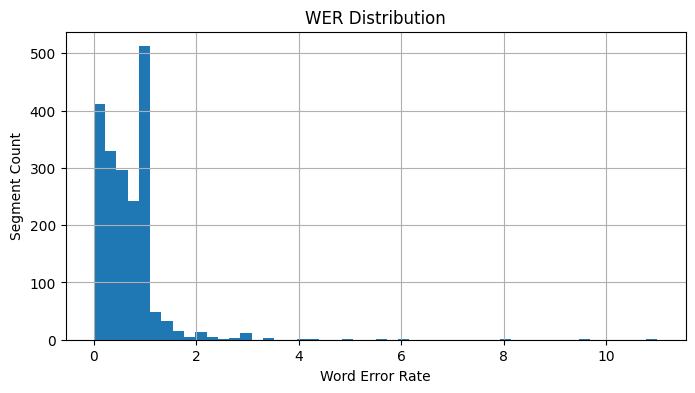

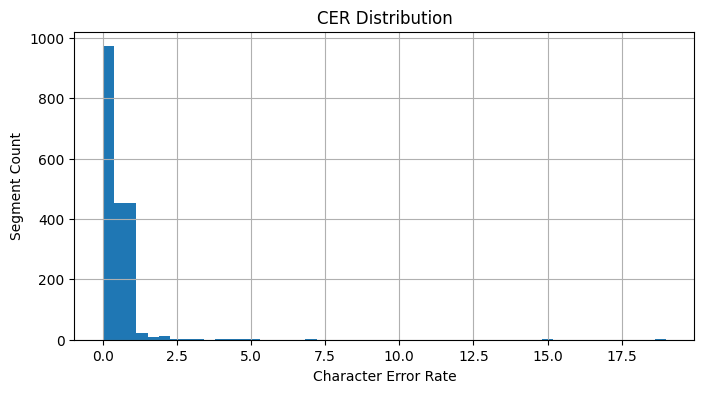

In [ ]:
import matplotlib.pyplot as plt


# WER histogram
plt.figure(figsize=(8, 4))
results_df['WER'].hist(bins=50)
plt.title("WER Distribution")
plt.xlabel("Word Error Rate")
plt.ylabel("Segment Count")
plt.grid(True)
plt.savefig(OUT_DIR / "whisper_init_transcription_WER.png")
plt.show()

# CER histogram
plt.figure(figsize=(8, 4))
results_df['CER'].hist(bins=50)
plt.title("CER Distribution")
plt.xlabel("Character Error Rate")
plt.ylabel("Segment Count")
plt.grid(True)
plt.savefig(OUT_DIR / "whisper_init_transcription_CER.png")
plt.show()


###Correlation with Segment Duration

Duration vs WER:
  Pearson r = -0.012
  Spearman ρ = 0.016



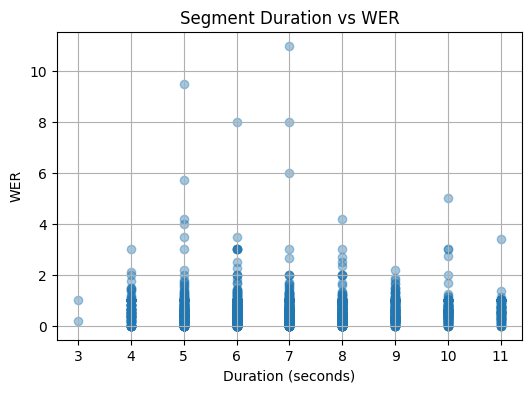


Duration vs CER:
  Pearson r = -0.022
  Spearman ρ = 0.027



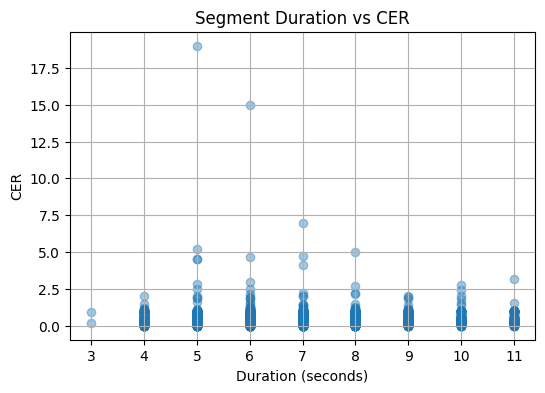

In [ ]:
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

# Compute correlations
def print_corr(x, y, label):
    pearson_r, _ = pearsonr(x, y)
    spearman_r, _ = spearmanr(x, y)
    print(f"{label}:\n  Pearson r = {pearson_r:.3f}\n  Spearman ρ = {spearman_r:.3f}\n")

# Duration vs WER
print_corr(results_df['Duration'], results_df['WER'], "Duration vs WER")

# Scatter: Duration vs WER
plt.figure(figsize=(6, 4))
plt.scatter(results_df['Duration'], results_df['WER'], alpha=0.4)
plt.title("Segment Duration vs WER")
plt.xlabel("Duration (seconds)")
plt.ylabel("WER")
plt.grid(True)
plt.savefig(OUT_DIR / "whisper_init_segment_duration_vs_WER.png")
plt.show()

# Duration vs CER
print()
print_corr(results_df['Duration'], results_df['CER'], "Duration vs CER")

# Scatter: Duration vs CER
plt.figure(figsize=(6, 4))
plt.scatter(results_df['Duration'], results_df['CER'], alpha=0.4)
plt.title("Segment Duration vs CER")
plt.xlabel("Duration (seconds)")
plt.ylabel("CER")
plt.grid(True)
plt.savefig(OUT_DIR / "whisper_init_segment_duration_vs_CER.png")
plt.show()


###Correlation with Word Count

Word Count vs WER:
  Pearson r = -0.183
  Spearman ρ = -0.268



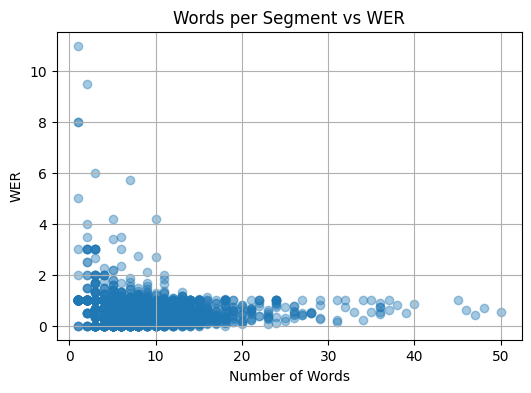


Word Count vs CER:
  Pearson r = -0.184
  Spearman ρ = -0.288



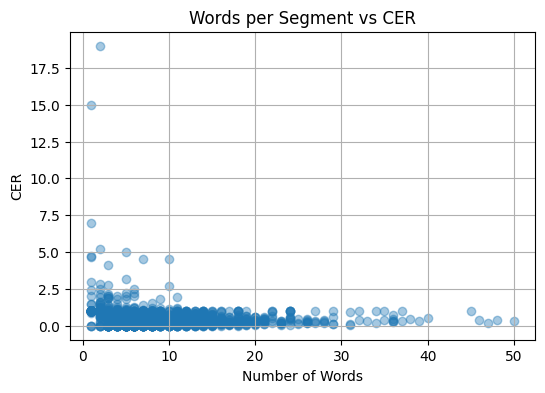

In [ ]:
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt

# Compute correlations
def print_corr(x, y, label):
    pearson_r, _ = pearsonr(x, y)
    spearman_r, _ = spearmanr(x, y)
    print(f"{label}:\n  Pearson r = {pearson_r:.3f}\n  Spearman ρ = {spearman_r:.3f}\n")

# Words vs WER
print_corr(results_df['Words'], results_df['WER'], "Word Count vs WER")

# Scatter: Words vs WER
plt.figure(figsize=(6, 4))
plt.scatter(results_df['Words'], results_df['WER'], alpha=0.4)
plt.title("Words per Segment vs WER")
plt.xlabel("Number of Words")
plt.ylabel("WER")
plt.grid(True)
plt.savefig(OUT_DIR / "whisper_init_words_per_segment_vs_WER.png")
plt.show()

# Words vs CER
print()
print_corr(results_df['Words'], results_df['CER'], "Word Count vs CER")

# Scatter: Words vs CER
plt.figure(figsize=(6, 4))
plt.scatter(results_df['Words'], results_df['CER'], alpha=0.4)
plt.title("Words per Segment vs CER")
plt.xlabel("Number of Words")
plt.ylabel("CER")
plt.grid(True)
plt.savefig(OUT_DIR / "whisper_init_words_per_segment_vs_CER.png")
plt.show()


###Summary by Song

In [ ]:
# Mean WER/CER per song
song_summary = results_df.groupby("Song")[["WER", "CER"]].mean().sort_values("WER", ascending=False)
song_summary.head()  # View worst performing songs


,WER,CER
Song,,
Chris Durban - Celebrate,1.500926,1.012334
Leaf - Come Around,1.315975,1.123066
Hollow Ground - Left Blind,1.215729,0.886320
Wall Of Death - Femme,1.171154,0.923392
Titanium - Haunted Age,1.123810,0.891931


###Levenshtein Edit Distance Loss

In [ ]:
from Levenshtein import distance as levenshtein_distance
import numpy as np

# Compute raw edit distance between lyric and prediction
results_df['Edit_Dist'] = results_df.apply(
    lambda row: levenshtein_distance(row['Lyric_clean'], row['Prediction_clean']) if pd.notnull(row['Prediction_clean']) else np.nan,
    axis=1
)

# Mean and max edit distance
mean_edit_dist = results_df['Edit_Dist'].mean()
max_edit_dist = results_df['Edit_Dist'].max()
print(f"Average Levenshtein Distance: {mean_edit_dist:.2f}")
print(f"Max Levenshtein Distance: {max_edit_dist}")


Average Levenshtein Distance: 16.17
Max Levenshtein Distance: 199.0


###Normalize Levenshtein distance by string length

In [ ]:
# Avoid divide-by-zero: use max length of reference or prediction
results_df['Ref_len'] = results_df['Lyric_clean'].apply(len)
results_df['Pred_len'] = results_df['Prediction_clean'].apply(lambda x: len(x) if pd.notnull(x) else 0)

results_df['Norm_Levenshtein'] = results_df['Edit_Dist'] / results_df[['Ref_len', 'Pred_len']].max(axis=1)

# Summary stats
print(f"Average Normalized Levenshtein: {results_df['Norm_Levenshtein'].mean():.3f}")
print(f"Max Normalized Levenshtein: {results_df['Norm_Levenshtein'].max():.3f}")


Average Normalized Levenshtein: 0.351
Max Normalized Levenshtein: 1.000


###Correlate normalized Levenshtein distance with segment features

In [ ]:
from scipy.stats import pearsonr, spearmanr

# Helper
def print_corr(x, y, label):
    pearson_r, _ = pearsonr(x, y)
    spearman_r, _ = spearmanr(x, y)
    print(f"{label}:\n  Pearson r = {pearson_r:.3f}\n  Spearman ρ = {spearman_r:.3f}\n")

# Drop rows with missing or infinite values in Norm_Levenshtein
corr_df = results_df[
    results_df['Norm_Levenshtein'].notnull() &
    results_df['Norm_Levenshtein'].apply(np.isfinite)
]

# Duration vs Norm Levenshtein
print_corr(corr_df['Duration'], corr_df['Norm_Levenshtein'], "Duration vs Normalized Levenshtein")

# Word Count vs Norm Levenshtein
print_corr(corr_df['Words'], corr_df['Norm_Levenshtein'], "Word Count vs Normalized Levenshtein")


Duration vs Normalized Levenshtein:
  Pearson r = -0.017
  Spearman ρ = 0.006

Word Count vs Normalized Levenshtein:
  Pearson r = -0.134
  Spearman ρ = -0.132



# Extracting Individual Audio Stems from `.stem.mp4` Files

To prepare for SNR-based data augmentation and full control over training audio -  extract the five separate audio channels embedded in each `.stem.mp4` file in MUSDB18:

- **mixture** (full mix)
- **vocals**
- **drums**
- **bass**
- **other** (guitar, synths, etc.)

uses `stempeg` library to load and extract each channel as a separate `.wav` file, then organized them into dedicated folders:



## Unpack stems

save each stem in stem sub-folder


Train dataset

In [ ]:
import os
import stempeg
import soundfile as sf
from tqdm import tqdm

# Input directory containing full training set of .stem.mp4 files
input_dir = DATA_RAW / "train"
# Output base directory
output_base = DATA_RAW / "train/stems"

# Create stem subfolders (if not exist)
stem_names = ["mixture", "drums", "bass", "other", "vocals"]
for stem in stem_names:
    os.makedirs(os.path.join(output_base, stem), exist_ok=True)

# Iterate over all stem.mp4 files
for filename in tqdm(os.listdir(input_dir)):
    if not filename.endswith(".stem.mp4"):
        continue

    trackname = filename.replace(".stem.mp4", "")
    input_path = os.path.join(input_dir, filename)

    try:
        # Load all 5 stereo stems
        audio, rate = stempeg.read_stems(input_path)

        # Save each to the correct subfolder
        for i, stem in enumerate(stem_names):
            output_path = os.path.join(output_base, stem, f"{trackname}.wav")
            sf.write(output_path, audio[i], rate)

    except Exception as e:
        print(f"Failed to process {filename}: {e}")


100%|██████████| 101/101 [15:43<00:00,  9.34s/it]


test dataset

In [ ]:
import os
import stempeg
import soundfile as sf
from tqdm import tqdm

# Input directory containing full test set of .stem.mp4 files
input_dir = DATA_RAW / "test"
# Output base directory
output_base = DATA_RAW / "test/stems"

# Create stem subfolders (if not exist)
stem_names = ["mixture", "drums", "bass", "other", "vocals"]
for stem in stem_names:
    os.makedirs(os.path.join(output_base, stem), exist_ok=True)

# Iterate over all stem.mp4 files
for filename in tqdm(os.listdir(input_dir)):
    if not filename.endswith(".stem.mp4"):
        continue

    trackname = filename.replace(".stem.mp4", "")
    input_path = os.path.join(input_dir, filename)

    try:
        # Load all 5 stereo stems
        audio, rate = stempeg.read_stems(input_path)

        # Save each to the correct subfolder
        for i, stem in enumerate(stem_names):
            output_path = os.path.join(output_base, stem, f"{trackname}.wav")
            sf.write(output_path, audio[i], rate)

    except Exception as e:
        print(f"Failed to process {filename}: {e}")


100%|██████████| 51/51 [13:05<00:00, 15.40s/it]


### Chunking Separated Stems by Lyrics Timing

Train sataset

In [ ]:
import os
from pathlib import Path
import pandas as pd
import librosa
import soundfile as sf
from tqdm import tqdm

# === Load train segment metadata ===
segments_df = pd.read_csv(DATA_PROCESSED / "train_segments.csv")

# === Set base paths ===
base_stem_dir = Path(DATA_RAW / "train/stems")
chunk_output_base = Path(DATA_PROCESSED / "train_chunks")

# === Stem names ===
stem_names = ["mixture", "drums", "bass", "other", "vocals"]

# === Process each stem type ===
for stem in stem_names:
    print(f"🔄 Processing stem: {stem}")
    output_dir = chunk_output_base / stem
    output_dir.mkdir(parents=True, exist_ok=True)

    # Group by song to avoid reloading
    for song, group in tqdm(segments_df.groupby("Song")):
        stem_path = base_stem_dir / stem / f"{song}.wav"
        if not stem_path.exists():
            continue

        try:
            y, sr = librosa.load(stem_path, sr=None, mono=False)

            for _, row in group.iterrows():
                start_sample = int(row["Start"] * sr)
                end_sample = int(row["End"] * sr)
                chunk_audio = y[:, start_sample:end_sample] if y.ndim == 2 else y[start_sample:end_sample]

                chunk_name = f"{song}_{int(row['Start'])}_{int(row['End'])}.wav"
                chunk_path = output_dir / chunk_name
                sf.write(chunk_path, chunk_audio.T, sr)
        except Exception as e:
            print(f" Error in {song} ({stem}): {e}")


🔄 Processing stem: mixture


100%|██████████| 95/95 [03:10<00:00,  2.01s/it]


🔄 Processing stem: drums


100%|██████████| 95/95 [03:18<00:00,  2.09s/it]


🔄 Processing stem: bass


100%|██████████| 95/95 [03:32<00:00,  2.24s/it]


🔄 Processing stem: other


100%|██████████| 95/95 [03:19<00:00,  2.10s/it]


🔄 Processing stem: vocals


100%|██████████| 95/95 [03:15<00:00,  2.05s/it]


Test dataset

In [ ]:
import os
from pathlib import Path
import pandas as pd
import librosa
import soundfile as sf
from tqdm import tqdm

# === Load test segment metadata ===
segments_df = pd.read_csv(DATA_PROCESSED / "test_segments.csv")

# === Set base paths ===
base_stem_dir = Path(DATA_RAW / "test/stems")
chunk_output_base = Path(DATA_PROCESSED / "test_chunks")

# === Stem names ===
stem_names = ["mixture", "drums", "bass", "other", "vocals"]

# === Process each stem type ===
for stem in stem_names:
    print(f"🔄 Processing stem: {stem}")
    output_dir = chunk_output_base / stem
    output_dir.mkdir(parents=True, exist_ok=True)

    # Group by song to avoid reloading
    for song, group in tqdm(segments_df.groupby("Song")):
        stem_path = base_stem_dir / stem / f"{song}.wav"
        if not stem_path.exists():
            continue

        try:
            y, sr = librosa.load(stem_path, sr=None, mono=False)

            for _, row in group.iterrows():
                start_sample = int(row["Start"] * sr)
                end_sample = int(row["End"] * sr)
                chunk_audio = y[:, start_sample:end_sample] if y.ndim == 2 else y[start_sample:end_sample]

                chunk_name = f"{song}_{int(row['Start'])}_{int(row['End'])}.wav"
                chunk_path = output_dir / chunk_name
                sf.write(chunk_path, chunk_audio.T, sr)
        except Exception as e:
            print(f" Error in {song} ({stem}): {e}")


🔄 Processing stem: mixture


100%|██████████| 45/45 [01:58<00:00,  2.63s/it]


🔄 Processing stem: drums


100%|██████████| 45/45 [01:50<00:00,  2.47s/it]


🔄 Processing stem: bass


100%|██████████| 45/45 [02:10<00:00,  2.90s/it]


🔄 Processing stem: other


100%|██████████| 45/45 [02:12<00:00,  2.94s/it]


🔄 Processing stem: vocals


100%|██████████| 45/45 [02:12<00:00,  2.95s/it]


###Reload the full dataset

In [ ]:
import pandas as pd
# Re-load the full CSV without filtering
csv_path = DATA_PROCESSED / "train_segments_chunked.csv"
train_full_df = pd.read_csv(csv_path)

In [ ]:
import pandas as pd
# Re-load the full CSV without filtering
csv_path = DATA_PROCESSED / "test_segments_chunked.csv"
test_full_df = pd.read_csv(csv_path)

###Add stem chunk paths to DataFrame

train

In [ ]:
import os

# Define base directory
chunk_base = Path(DATA_PROCESSED / "train_chunks")

# List of stem types
stems = ["mixture", "drums", "bass", "other", "vocals"]

# For each stem type, construct file path column
for stem in stems:
    col_name = f"{stem}_chunk_path"
    train_full_df[col_name] = train_full_df.apply(
        lambda row: os.path.join(
            chunk_base,
            stem,
            f"{row['Song']}_{int(row['Start'])}_{int(row['End'])}.wav"
        ),
        axis=1
    )

# Preview
train_full_df.head()

# Save interim results
train_full_df.to_csv(DATA_PROCESSED / "train_full_df.csv", index=False)

,Song,Split,Start,End,Duration,Words,Lyric,chunk_path,has_lyrics,mixture_chunk_path,drums_chunk_path,bass_chunk_path,other_chunk_path,vocals_chunk_path
0,A Classic Education - NightOwl,Train,0.0,8.0,8.0,6,i think you're right i do,/content/drive/MyDrive/DS_course/Deep_Learning...,True,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...
1,A Classic Education - NightOwl,Train,8.0,18.0,10.0,5,only feel us or you,/content/drive/MyDrive/DS_course/Deep_Learning...,True,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...
2,A Classic Education - NightOwl,Train,18.0,23.0,5.0,5,i know the reasons why,/content/drive/MyDrive/DS_course/Deep_Learning...,True,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...
3,A Classic Education - NightOwl,Train,23.0,28.0,5.0,3,you crave more,/content/drive/MyDrive/DS_course/Deep_Learning...,True,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...
4,A Classic Education - NightOwl,Train,28.0,34.0,6.0,3,harder than one,/content/drive/MyDrive/DS_course/Deep_Learning...,True,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...,/content/drive/MyDrive/DS_course/Deep_Learning...


test

In [ ]:
import os

# Define base directory
chunk_base = Path(DATA_PROCESSED / "test_chunks")

# List of stem types
stems = ["mixture", "drums", "bass", "other", "vocals"]

# For each stem type, construct file path column
for stem in stems:
    col_name = f"{stem}_chunk_path"
    test_full_df[col_name] = test_full_df.apply(
        lambda row: os.path.join(
            chunk_base,
            stem,
            f"{row['Song']}_{int(row['Start'])}_{int(row['End'])}.wav"
        ),
        axis=1
    )

# Preview
print(test_full_df.head())

# Save interim results
test_full_df.to_csv(DATA_PROCESSED / "test_full_df.csv", index=False)

                           Song Split  Start   End  Duration  Words  \
0  AM Contra - Heart Peripheral  Test    0.0  10.0      10.0      1   
1  AM Contra - Heart Peripheral  Test   10.0  16.0       6.0      1   
2  AM Contra - Heart Peripheral  Test   16.0  21.0       5.0      8   
3  AM Contra - Heart Peripheral  Test   23.0  30.0       7.0      8   
4  AM Contra - Heart Peripheral  Test   30.0  38.0       8.0      6   

                                     Lyric  has_lyrics  \
0                                        -       False   
1                                        -       False   
2           take on big bite of life to go        True   
3  take an apple please from the front row        True   
4         oh soon enough never good enough        True   

                                          chunk_path  \
0  /content/drive/MyDrive/DS_course/Deep_Learning...   
1  /content/drive/MyDrive/DS_course/Deep_Learning...   
2  /content/drive/MyDrive/DS_course/Deep_Learning...   


# Whisper Inference on Clean Vocals Only

Run Whisper model on the vocals channel only (clean vocals)




In [ ]:
from tqdm import tqdm
import whisper
import pandas as pd

# Load the full DataFrame
df = pd.read_csv(DATA_PROCESSED /"train_full_df.csv")

# Load model
model = whisper.load_model("small")

# Prepare output list
results = []

# Transcribe vocals-only audio chunks
for i, row in tqdm(df.iterrows(), total=len(df)):
    audio_path = row["vocals_chunk_path"]
    try:
        result = model.transcribe(audio_path, fp16=True)  # on GPU
        results.append(result["text"])
    except Exception as e:
        results.append(None)

# Add predictions to DataFrame
df["vocals_prediction"] = results

# Optional: Save interim results
df.to_csv(DATA_PROCESSED /"whisper_vocals_predictions.csv", index=False)


100%|███████████████████████████████████████| 461M/461M [00:11<00:00, 41.0MiB/s]
100%|██████████| 2789/2789 [1:37:54<00:00,  2.11s/it]


### Whisper clean-vocals Evaluation

Normalize the Whisper transcription output (`vocals_prediction`) obtained from clean vocals (no background music), and compare it to the already normalized ground-truth lyrics (`Lyrics`).

Compute standard transcription accuracy metrics:

- **WER (Word Error Rate)**: word-level edit distance
- **CER (Character Error Rate)**: character-level edit distance


In [ ]:
from tqdm import tqdm
from jiwer import wer, cer
import re

# Normalize function (lowercase, strip, remove punctuation)
def normalize(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.strip()
    text = re.sub(r"[^\w\s]", "", text)  # remove punctuation
    return text

# Create results list
results = []

# Iterate through all segments
for _, row in tqdm(df.iterrows(), total=len(df)):

    true_lyric = row['Lyric']
    vocals_prediction = row['vocals_prediction']

    # Normalize
    true_clean = normalize(true_lyric)
    pred_clean = normalize(vocals_prediction)

    # Compute metrics
    wer_score = wer(true_clean, pred_clean)
    cer_score = cer(true_clean, pred_clean)

    # Store result
    results.append({
        "Song": row['Song'],
        "Start": row['Start'],
        "End": row['End'],
        "Duration": row['Duration'],
        "Lyric": true_lyric,
        "Lyric_clean": true_clean,
        "Prediction": vocals_prediction,
        "Prediction_clean": pred_clean,
        "WER": wer_score,
        "CER": cer_score,
        "Words": row['Words']
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
output_path = DATA_PROCESSED /"whisper_vocals_transcription_results.csv"
results_df.to_csv(output_path, index=False)
print(f"\n✅ Exported results to: {output_path}")
print(f"Average WER: {results_df['WER'].mean():.3f}")
print(f"Average CER: {results_df['CER'].mean():.3f}")


100%|██████████| 2789/2789 [00:00<00:00, 4066.85it/s]


✅ Exported results to: /content/drive/MyDrive/DS_course/Deep_Learning/Final Project/musdb18/whisper_vocals_transcription_results.csv
Average WER: 0.456
Average CER: 0.932


### Analyze False Positives: Whisper Predictions When No Lyrics Were Expected

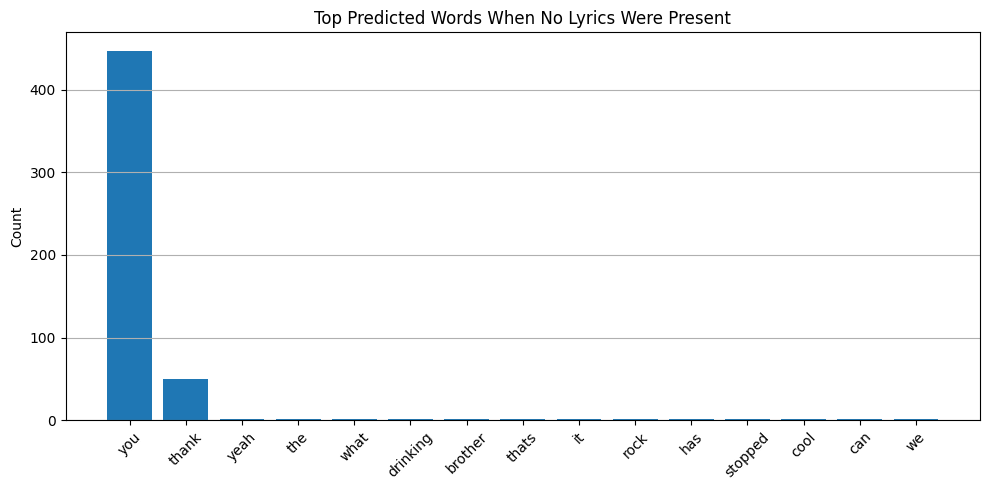


Segments with hallucinated lyrics (false positives): 455/2789 (16.31%)
86.81% of them is the hallucinations  of the word 'you'


In [ ]:
import pandas as pd
import random
import matplotlib.pyplot as plt
from collections import Counter

# Load results CSV
df = pd.read_csv(DATA_PROCESSED / "whisper_vocals_transcription_results.csv")

# Identify false positives: prediction exists but no ground truth lyric
false_positives = df[
    (df["Lyric_clean"].isna() | (df["Lyric_clean"].str.strip() == "")) &
    (df["Prediction_clean"].fillna("").str.strip() != "")
]

# Tokenize all predictions from false positives
all_tokens = []
for text in false_positives["Prediction_clean"].dropna():
    all_tokens.extend(text.lower().strip().split())

# Count and plot top 15 most common predicted words
top_words = Counter(all_tokens).most_common(15)
words, counts = zip(*top_words)

plt.figure(figsize=(10, 5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top Predicted Words When No Lyrics Were Present")
plt.ylabel("Count")
plt.grid(axis="y")
plt.tight_layout()
plt.savefig(OUT_DIR / "whisper_vocal_pred_top_words.png")
plt.show()

# Report false positive rate
num_false_positives = len(false_positives)
total_segments = len(df)
rate = num_false_positives / total_segments
print(f"\nSegments with hallucinated lyrics (false positives): {num_false_positives}/{total_segments} ({rate:.2%})")


# Calculate 'you' percent
you_percent = len(false_positives[false_positives['Prediction_clean']=='you'])/num_false_positives
print(f"{you_percent:.2%} of them is the hallucinations  of the word 'you'")

In [ ]:
you_percent = len(false_positives[false_positives['Prediction_clean']=='you'])/num_false_positives
you_percent

0.8681318681318682

# Data Augmentation

# Vocal-Only audio Augmentation

Pitch shifting (+2, -2 semitones)

Time stretching (0.9× and 1.1×)

In [ ]:
import os
import torch
import torchaudio
from torchaudio.functional import pitch_shift
from torchaudio.transforms import TimeStretch
from tqdm import tqdm
import pandas as pd

# === Parameters ===
CHUNK_DIR = DATA_PROCESSED / "/train_chunks/vocals"
OUTPUT_BASE = DATA_PROCESSED / "train_chunks_augmented/vocals"
SAMPLE_RATE = 16000

# === Only augment chunks that contain lyrics ===
df = pd.read_csv(DATA_PROCESSED / "train_segments_chunked.csv")
df = df[df["has_lyrics"] == True]
# Modify to match the format of filenames in CHUNK_DIR
valid_filenames = set([
    f"{row['Song']}_{int(row['Start'])}_{int(row['End'])}.wav"
    for _, row in df.iterrows()
])

# === Define pitch shift augmentations ===
AUG_TYPES = {
    "pitch+2": lambda y: pitch_shift(y, SAMPLE_RATE, n_steps=2),
    "pitch-2": lambda y: pitch_shift(y, SAMPLE_RATE, n_steps=-2),
}

# === TimeStretch setup ===
time_stretch = TimeStretch(hop_length=320, n_freq=513).to("cuda")
hann_window = torch.hann_window(1024).to("cuda")

# === Create output directories ===
for aug_name in list(AUG_TYPES.keys()) + ["stretch_090", "stretch_110"]:
    os.makedirs(os.path.join(OUTPUT_BASE, aug_name), exist_ok=True)

# === Process files ===
for fname in tqdm(os.listdir(CHUNK_DIR)):
    if fname not in valid_filenames:
        continue

    fpath = os.path.join(CHUNK_DIR, fname)
    waveform, sr = torchaudio.load(fpath)

    if sr != SAMPLE_RATE:
        waveform = torchaudio.functional.resample(waveform, sr, SAMPLE_RATE)
    if waveform.size(0) > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Pitch shift
    for aug_name, aug_fn in AUG_TYPES.items():
        try:
            aug_wave = aug_fn(waveform)
            out_path = os.path.join(OUTPUT_BASE, aug_name, fname)
            torchaudio.save(out_path, aug_wave.cpu(), SAMPLE_RATE)
        except Exception as e:
            print(f"⚠️ Pitch shift {aug_name} failed on {fname}: {e}")

    # Time stretch
    try:
        stft = torch.stft(
            waveform.cuda(),
            n_fft=1024,
            hop_length=320,
            win_length=1024,
            return_complex=True,
            window=hann_window
        )

        for rate, name in zip([0.9, 1.1], ["stretch_090", "stretch_110"]):
            try:
                stretched = time_stretch(stft, rate)
                y_out = torch.istft(
                    stretched[0],
                    n_fft=1024,
                    hop_length=320,
                    win_length=1024,
                    window=hann_window
                ).unsqueeze(0)
                out_path = os.path.join(OUTPUT_BASE, name, fname)
                torchaudio.save(out_path, y_out.cpu(), SAMPLE_RATE)
            except Exception as e:
                print(f"⚠️ Time stretch {name} failed on {fname}: {e}")
    except Exception as e:
        print(f"⚠️ STFT failed on {fname}: {e}")

100%|██████████| 2789/2789 [1:38:01<00:00,  2.11s/it]


## Add augmented dataset to training csv

In [ ]:
import os
import pandas as pd

# Load training full stemmed segment metadata
df_full = pd.read_csv(DATA_PROCESSED / "train_full_df.csv")
# Filter to segments with lyrics and extract only vocal paths
df_orig = df_full[df_full["has_lyrics"] == True].copy()

# Rename 'vocals' column to 'chunk_path' to match augmented structure
df_orig["chunk_path"] = df_orig["vocals_chunk_path"]
df_orig["augmented_from"] = "none"

# Keep only necessary columns to match df_aug
df_orig = df_orig[["chunk_path", "Song", "Start", "End", "Lyric", "has_lyrics", "augmented_from"]].reset_index(drop=True)

# Set up augmented directories
AUG_DIR = DATA_PROCESSED / "train_chunks_augmented/vocals"
AUG_TYPES = ["pitch+2", "pitch-2", "stretch_090", "stretch_110"]

aug_rows = []

for aug in AUG_TYPES:
    aug_path = os.path.join(AUG_DIR, aug)
    for fname in os.listdir(aug_path):
        if not fname.endswith(".wav"):
            continue

        # Parse filename
        parts = fname.replace(".wav", "").rsplit("_", 2)
        song, start, end = parts[0], int(parts[1]), int(parts[2])

        # Find matching original row
        match = df_orig[
            (df_orig["Song"] == song) &
            (df_orig["Start"].astype(int) == start) &
            (df_orig["End"].astype(int) == end)
        ]

        if match.empty:
            print(f"❌ No match for: {fname}")
            continue

        row = match.iloc[0].copy()
        row["chunk_path"] = os.path.join(aug_path, fname)
        row["augmented_from"] = aug
        aug_rows.append(row)

# Create DataFrame of augmented rows
df_aug = pd.DataFrame(aug_rows)
print(f"✅ Added {len(df_aug)} augmented rows")

# Combine with original
df_combined = pd.concat([df_orig, df_aug], ignore_index=True)

# Save combined dataset
df_combined.to_csv(DATA_PROCESSED /"train_segments_vocal_combined.csv", index=False)


✅ Added 7760 augmented rows


In [ ]:
len(df_combined)

9700